# Import delle librerie necessarie

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !git clone https://github.com/AntonioDelleCanne/tesi.git

In [3]:
%cd DeepLearning_Financial

/data/home/dsvm_server_admin/notebooks/fastai/tesi/DeepLearning_Financial


In [4]:
## EXTERNAL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance
from pandas import Series
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import time
import os
import random 
from sklearn.datasets import make_regression
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetRegressor
from torch.nn.modules.loss import MSELoss
import tensorflow as tf
from tensorflow import keras
from skorch.dataset import CVSplit
from skorch import callbacks
import pickle
from sklearn.model_selection import train_test_split
from functools import partial
import skorch
import pywt
from sklearn import preprocessing
import joblib


##INTERNAL
from models import Autoencoder, Sequence, waveletSmooth, SequenceDouble, SequenceDoubleAtt, SequenceAtt
from utils import prepare_data_lstm, ExampleDataset, save_checkpoint, evaluate_lstm, backtest

In [5]:
def save(model, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(model, f)
        
def load(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
#returns open high low close volume
def get_index(index="^DJI", start_date="2000-01-01", end_date="2018-12-31"):
    security = yfinance.Ticker(index)# TODO trova mercato asiatico e indiano
    security_data = security.history(start=start_date, end=end_date, actions=False)
    return security_data

In [7]:
def split_index(security_data):
    return security_data["Open"], security_data["High"], security_data["Low"], security_data["Close"], security_data["Volume"]

# Allenamento modello

## Metriche
Come metrica principale per valutare la bonta' dele predizioni utilizzeremo il Return of Investment (ROI).

Con questa metrica assumiamo di utilizzare l'algoritmo di trading precedentemente descritto, e calcoliamo il guadango che avremmo ottenuto se lo avessimo utilizzato sul dataset che stiamo valutando.

In [8]:
def gain(C, C_pred, opn):
    O = opn.reindex_like(C)
    CO_diff = C - O
    growth = C_pred > O
    decline = C_pred < O
    return CO_diff[growth].sum() - CO_diff[decline].sum()
def roi(C, C_pred, opn):
    mean_opn = opn.reindex_like(C).mean()
    return gain(C, C_pred, opn) / mean_opn

## Preparazione dei dati
Come spiegato in precedenza, visto che alcune feature non sono disponibili all'inizio della giornata, per poterle utilizzare nel nostro modello, utilizzeremo i dati dei giori passati, servendoci della funzione shift.

Visto che l'utilizzo di questa funzione fara' si che in alcune riche vi saranno dei vaolri NaN, dobbiamo assicurarci di eliminare queste osservazioni sia nelle serie relative ale features che in quella della variabile da predire.
Questo compito e' svolto dalla funzione prepare_data.

In [ ]:
def prepare_data(features, target):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    Y = target.reindex_like(X)
    return X, Y

Con questa funzione dividiamo i dati in training set e validation set come è stato fatto nel paper

In [ ]:
def s_split_before_2010_06_30(X):
    is_train = X.index.date < datetime.date(2010,6,30)
    X_train = X.loc[is_train]
    X_val = X.loc[~is_train]
    return X_train, X_val

In [ ]:
def split_before_2010_06_30(X, y):
    is_train = X.index.date < datetime.date(2010,6,30)
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

# Preparazione del dataset

In [12]:
# def get_dataset(opn, close, high, low, volume, name, usd_index='DX-Y.NYB', train=size, encoder='ohlcv_encoder_DJIA', encoder_stats='ohlcv_stats_encoder_DJIA'):
#     features={}
#     dataset = None
#     volume = volume/1000 # prescaling the volume
    
#     us_dollar_opn = get_index(usd_index, start_date=opn.index.min(), end_date=opn.index.max())["Open"]
    
#     if(zero_mean):
#         opn = zero_mean(opn)
#         close = zero_mean(close)
#         high = zero_mean(high)
#         low = zero_mean(low)
#         volume = zero_mean(volume)
#         us_dollar_opn = zero_mean(us_dollar_opn)
    
#     if(wavelet):
#         opn = apply_wavelet_transform(opn)
#         close = apply_wavelet_transform(close)
#         high = apply_wavelet_transform(high)
#         low = apply_wavelet_transform(low)
#         volume = apply_wavelet_transform(volume)
#         us_dollar_opn = apply_wavelet_transform(us_dollar_opn)
    
#     #calucate derived indicators
#     TP = ((high + low + close) / 3 ).shift(1)
#     trs = pd.DataFrame(index=high.index)
#     trs['tr0'] = abs(high - close)
#     trs['tr1'] = abs(high - close.shift(1))
#     trs['tr2'] = abs(low - close.shift(1))
#     TR = trs[['tr0', 'tr1', 'tr2']].max(axis=1).shift(1)
#     ema20 = opn.ewm(span=20).mean()
#     ma10 = opn.rolling(window=10).mean()
#     ma5 = opn.rolling(window=5).mean()
#     macd = opn.ewm(span=26).mean() - opn.ewm(span=12).mean()
#     cci_ndays=20
#     cci = (TP - TP.rolling(cci_ndays).mean()) / (0.015 * TP.rolling(cci_ndays).std())
#     atr = TR.ewm(span = 10).mean()
#     ma20 = opn.rolling(window=20).mean()
#     std20 = opn.rolling(window=20).std()
#     k=2
#     boll_up =  ma20 + (k*std20)
#     boll_down = ma20 - (k*std20)
#     roc = (opn - opn.shift(9))*100/opn.shift(9)
#     mtm6 = (opn - opn.shift(127))
#     mtm12 = (opn - opn.shift(253)) #length of a trading year is on average 253 days
#     wvad = (((close - low) - (high - close)) * volume/(high - low)).shift(1)
#     smi = (close - (high - low)/2).shift(1)
    
    
#     ohlcv_encoder = load(encoder)
# #     ohlcv_stats_encoder = load(encoder_stats)
#     if(z_norm):
#         opn= z_score(opn)
#         close = z_score(close)
#         high = z_score(high)
#         low = z_score(low)
#         volume = z_score(volume)
#     target=close
#     if(name is "open"):
#         features["Open"] = opn
#     elif(name is "ohlcv" or "sa_ohlcv"):
#         features["Open"] = opn
#         features["CloseL1"] = close.shift(1)
#         features["HighL1"] = high.shift(1)
#         features["LowL1"] = low.shift(1)
#         features["VolumeL1"] = volume.shift(1)
#         if(name is "sa_ohlcv"):
#             #ricava altri parametri e aggiungi a features
#             temp_dset = prepare_data(features, target)
#             features = {}
            
#             for i, feature in enumerate(encode(temp_dset[0].to_numpy().astype(np.float32), ohlcv_encoder).T):
#                 features["deep{}".format(i)] = pd.Series(feature, index=temp_dset[0].index)
#     elif(name is "ohlcv_stats" or "sa_ohlcv_stats"):
#         features["Open"] = opn
#         features["CloseL1"] = close.shift(1)
#         features["HighL1"] = high.shift(1)
#         features["LowL1"] = low.shift(1)
#         features["VolumeL1"] = volume.shift(1)
#         features["EMA20"] = ema20
#         features["MA5"] = ma5
#         features["MA10"] = ma10
#         features["MA20"] = ma20
#         features["MACD"] = macd
#         features["CCI"] = cci
#         features["ATR"] = atr
#         features["BollUp"] = boll_up
#         features["BollDown"] = boll_down
#         features["WVAD"] = wvad
#         features["MTM6"] = mtm6
#         features["MTM12"] = mtm12
#         features["SMI"] = smi
#         features["ROC"] = roc
#         features["USD_Open"] = us_dollar_opn 
#         #TODO
#         if(name is "sa_ohlcv_stats"):
#             #ricava altri parametri e aggiungi a features
#             temp_dset = prepare_data(features, target)
#             features = {}
#             for i, feature in enumerate(encode(temp_dset[0].to_numpy().astype(np.float32), ohlcv_encoder).T):
#                 features["deep{}".format(i)] = pd.Series(feature, index=temp_dset[0].index)
#     else:
#         raise Exception('Nome del feature-set non valido')
        
#     return prepare_data(features, target)

In [75]:
def get_ext_feats(ohlcv):
    res = ohlcv.copy()
    
    opn = res["Open"]
    close = res["Close"]
    high = res["High"]
    low = res["Low"]
    volume = res["Volume"]
    
    #calucate derived indicators
    TP = ((high + low + close) / 3 ).shift(1)
    trs = pd.DataFrame(index=high.index)
    trs['tr0'] = abs(high - close)
    trs['tr1'] = abs(high - close.shift(1))
    trs['tr2'] = abs(low - close.shift(1))
    TR = trs[['tr0', 'tr1', 'tr2']].max(axis=1).shift(1)
    ema20 = opn.ewm(span=20).mean()
    ma10 = opn.rolling(window=10).mean()
    ma5 = opn.rolling(window=5).mean()
    macd = opn.ewm(span=26).mean() - opn.ewm(span=12).mean()
    cci_ndays=20
    cci = (TP - TP.rolling(cci_ndays).mean()) / (0.015 * TP.rolling(cci_ndays).std())
    atr = TR.ewm(span = 10).mean()
    ma20 = opn.rolling(window=20).mean()
    std20 = opn.rolling(window=20).std()
    k=2
    boll_up =  ma20 + (k*std20)
    boll_down = ma20 - (k*std20)
    roc = (opn - opn.shift(9))/opn.shift(9)
    mtm6 = (opn - opn.shift(127))
    mtm12 = (opn - opn.shift(253)) #length of a trading year is on average 253 days
    wvad = (((close - low) - (high - close)) * volume/(high - low)).shift(1)
    smi = (close - (high - low)/2).shift(1)
    
    res["CloseL1"] = close.shift(1)
    res["HighL1"] = high.shift(1)
    res["LowL1"] = low.shift(1)
    res["VolumeL1"] = volume.shift(1)
    res["EMA20"] = ema20
    res["MA5"] = ma5
    res["MA10"] = ma10
    res["MA20"] = ma20
    res["MACD"] = macd
    res["CCI"] = cci
    res["ATR"] = atr
    res["BollUp"] = boll_up
    res["BollDown"] = boll_down
    res["WVAD"] = wvad
    res["MTM6"] = mtm6
    res["MTM12"] = mtm12
    res["SMI"] = smi
    res["ROC"] = roc
    
    return res

In [79]:
# takes as input ohlcv dataframe
def get_data_set(ohlcv, ext_feats=True, usd_index='DX-Y.NYB', wavelet=True):
    feats = ohlcv.copy()
    usd_open = get_index(usd_index, start_date=opn.index.min(), end_date=opn.index.max())["Open"]
    
    if(wavelet):
    #apply transforms
        for f_name in ('Open', 'Close', 'High', 'Low'):
            feats[f_name] = apply_wavelet_transform(feats[f_name]) 
        usd_open = apply_wavelet_transform(usd_open)
    
    if(ext_feats):
        feats = get_ext_feats(feats)
        feats["USDOpen"]  = usd_open
    return feats

In [80]:
def get_dataset_by_name(ohlcv, name):
    if(name is "open"):
        return get_data_set(ohlcv, ext_feats=False)[["Open", "Close"]]
    elif(name is "ohlcv"):
        return get_data_set(ohlcv, ext_feats=False)
    elif(name is "ext"):
        return get_data_set(ohlcv)
    raise Exception('Nome del feature-set non valido')

In [15]:
#TODO per features con SA
# if(name is "sa_ohlcv"):
#             #ricava altri parametri e aggisungi a features
#             temp_dset = prepare_data(features, target)
#             features = {}
            
#             for i, feature in enumerate(encode(temp_dset[0].to_numpy().astype(np.float32), ohlcv_encoder).T):
#                 features["deep{}".format(i)] = pd.Series(feature, index=temp_dset[0].index)

## Regolarizzazione

### Wavelet

In [16]:
def apply_wavelet_transform(data, consider_future=False, wavelet='haar'):
    res = data.copy()
    if(consider_future):
        res, _ = pywt.dwt(data.copy(), wavelet=wavelet)
    else:
        for i in range(res.shape[0]):
            if(i > 0):
                cA =  waveletSmooth(data.iloc[:i+1].copy(), wavelet=wavelet, level=4, DecLvl=3)
                res.iloc[i] = cA[-1]
    return res

In [17]:
# def apply_wavelet_transform(data, consider_future=False, wavelet='haar'):
#     res = data.copy()
#     if(consider_future):
#         res, _ = pywt.dwt(data.copy(), wavelet=wavelet)
#     else:
#         for i in range(res.shape[0]):
#             if(i > 0):
#                 cA, cD = pywt.dwt(data.iloc[:i+1].copy(), wavelet=wavelet)
#                 res.iloc[i] = cA[-1]
#     return res

In [18]:
opn =get_index()["Open"]
haar = apply_wavelet_transform(opn, consider_future=False, wavelet='haar')
coif3 = apply_wavelet_transform(opn, consider_future=False, wavelet='coif3')

/data/anaconda/envs/fastai/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/data/anaconda/envs/fastai/lib/python3.6/site-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in true_divide
  thresholded = (1 - value/magnitude)


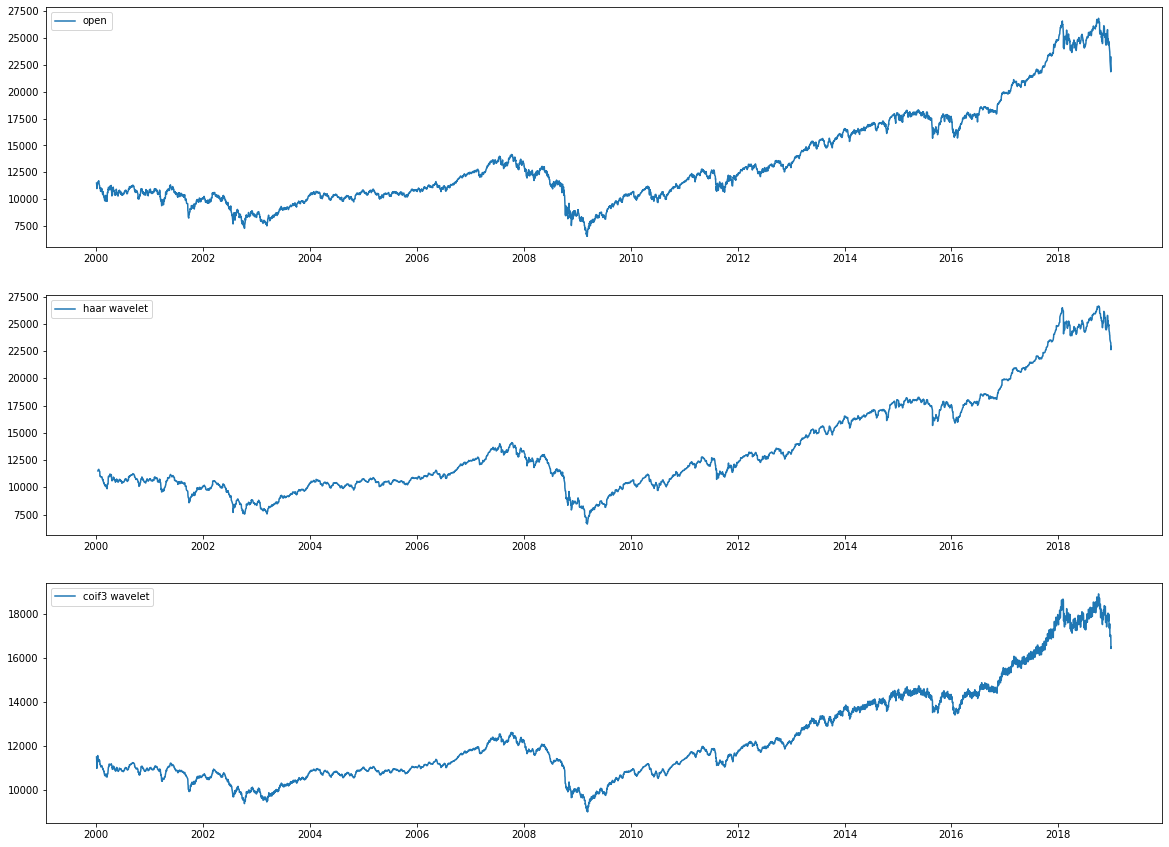

In [19]:
fig, ax = plt.subplots(3,1, sharex=False, figsize=(20,15))
ax[0].plot(opn, label='open')
ax[1].plot(haar, label='haar wavelet')
ax[2].plot(coif3, label ='coif3 wavelet')
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Normalizzazione 
Le seguenti funzioni sono utilizzate per normalizzare i dati, pianifichiamo di utilizzare queste funzioni anche sulla variabile da predire dovremo implementarne anche l'inversa, di modo da poter denormalizzare le predizioni fatte dal modello.
Questo passo sarà importante nella valutazione del modello, ad esempio per calcolare il ROI.

## Scaler

In [20]:
data = get_index()
ohlcv_dataset = get_data_set(data, ext_feats=False).dropna()
ext_dataset = get_data_set(data).dropna()

/data/anaconda/envs/fastai/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))
/data/anaconda/envs/fastai/lib/python3.6/site-packages/pywt/_thresholding.py:23: RuntimeWarning: invalid value encountered in true_divide
  thresholded = (1 - value/magnitude)


In [21]:
# ohlcv_scaler = StandardScaler()
# ext_scaler = StandardScaler()
# ohlcv_scaler.fit(ohlcv_dataset)
# ext_train = ext_scaler.fit_transform(s_split_before_2010_06_30(ext_dataset)[0])
# ohlcv_train = ohlcv_scaler.fit_transform(s_split_before_2010_06_30(ohlcv_dataset)[0])

In [22]:
# #save scalers
# joblib.dump(ext_scaler, 'ext_scaler.bin', compress=True)
# joblib.dump(ohlcv_scaler, 'ohlcv_scaler.bin', compress=True)

In [23]:
ext_scaler=joblib.load('ext_scaler.bin')
ohlcv_scaler = joblib.load('ohlcv_scaler.bin')

In [24]:
#TODO prendi training set per tutte features
# poi allena entrambi scalers(vedi se basta solo quello ext)
# poi allena atoencoder su train scalato

## Stacked Autoencoder

In [36]:
def get_encoder(X, val=None, sa_hidden_size=10):
    X_train_f = X.astype(np.float32)
    if(val is not None):
        X_val_f = val.astype(np.float32)
    #Initialize the autoencoder
    sa_hidden_size= np.ceil(X.shape[1] / 2).astype(int) # Con tutte le features 10

    num_hidden_1 = sa_hidden_size
    num_hidden_2 = sa_hidden_size
    num_hidden_3 = sa_hidden_size
    num_hidden_4 = sa_hidden_size

    n_epoch1=15000 #10000
    n_epoch2 = 2000
    n_epoch3 = 600
    n_epoch4 = 500
    batch_size=20

    # ---- train using training data

    # The n==0 statement is done because we only want to initialize the network once and then keep training
    # as we move through time 

    auto1 = Autoencoder(X_train_f.shape[1], num_hidden_1)
    auto2 = Autoencoder(num_hidden_1, num_hidden_2)
    auto3 = Autoencoder(num_hidden_2, num_hidden_3)
    auto4 = Autoencoder(num_hidden_3, num_hidden_4)
    
    # Train the autoencoder 
    # switch to training mode
    auto1.train()      
    auto2.train()
    auto3.train()
    auto4.train()

    inputs = torch.from_numpy(X_train_f)
    val_in = torch.from_numpy(X_val_f)
    auto1.fit(X_train_f, X_val_f, n_epoch=n_epoch1, batch_size=batch_size)

    auto1_out = auto1.encoder(inputs).data.numpy()
    val1_out = auto1.encoder(val_in).data.numpy()
    auto2.fit(auto1_out, val1_out, n_epoch=n_epoch2, batch_size=batch_size)


    auto1_out = torch.from_numpy(auto1_out.astype(np.float32))
    auto2_out = auto2.encoder(auto1_out).data.numpy()
    val1_out = torch.from_numpy(val1_out.astype(np.float32))
    val2_out = auto2.encoder(val1_out).data.numpy()
    auto3.fit(auto2_out, val2_out, n_epoch=n_epoch3, batch_size=batch_size)


    auto2_out = torch.from_numpy(auto2_out.astype(np.float32))
    auto3_out = auto3.encoder(auto2_out).data.numpy()
    val2_out = torch.from_numpy(val2_out.astype(np.float32))
    val3_out = auto3.encoder(val2_out).data.numpy()
    auto4.fit(auto3_out, val3_out, n_epoch=n_epoch4, batch_size=batch_size)

    # Change to evaluation mode, in this mode the network behaves differently, e.g. dropout is switched off and so on
    auto1.eval()        
    auto2.eval()
    auto3.eval()
    auto4.eval()
    return [auto1, auto2, auto3, auto4]

In [27]:
def encode(feat_matrix, encoder):
    encoded = torch.from_numpy(feat_matrix)
    for auto in encoder:
        encoded = auto.encoder(encoded)
    return encoded.data.numpy()
    

In [28]:
def encoder_score(data, encoder):
    for auto in encoder:
        auto.eval()
    auto
    for auto in encoder:
        auto.train()

In [29]:
ext_train = ext_scaler.transform(s_split_before_2010_06_30(ext_dataset)[0])
ext_eval = ext_scaler.transform(s_split_before_2010_06_30(ext_dataset)[1])
ohlcv_train = ohlcv_scaler.transform(s_split_before_2010_06_30(ohlcv_dataset)[0])

In [37]:
ext_encoder = get_encoder(ext_train, ext_eval, sa_hidden_size=10)

Data Shuffled
Epoch 1/15000 | train loss: 4.3169 | train_error 0.7174 | valid_error 1.4258
Data Shuffled
Epoch 2/15000 | train loss: 3.4086 | train_error 0.4778 | valid_error 1.4825
Data Shuffled
Epoch 3/15000 | train loss: 2.6773 | train_error 0.4221 | valid_error 1.4717
Data Shuffled
Epoch 4/15000 | train loss: 1.9764 | train_error 0.3893 | valid_error 1.4243
Data Shuffled
Epoch 5/15000 | train loss: 1.5407 | train_error 0.3613 | valid_error 1.3773
Data Shuffled
Epoch 6/15000 | train loss: 1.2482 | train_error 0.3361 | valid_error 1.3372
Data Shuffled
Epoch 7/15000 | train loss: 1.1073 | train_error 0.3160 | valid_error 1.3031
Data Shuffled
Epoch 8/15000 | train loss: 1.0156 | train_error 0.3001 | valid_error 1.2739
Data Shuffled
Epoch 9/15000 | train loss: 0.9952 | train_error 0.2882 | valid_error 1.2543
Data Shuffled
Epoch 10/15000 | train loss: 0.9700 | train_error 0.2778 | valid_error 1.2377
Data Shuffled
Epoch 11/15000 | train loss: 0.9569 | train_error 0.2688 | valid_error 1.22

Epoch 90/15000 | train loss: 1.3016 | train_error 0.0574 | valid_error 0.9027
Data Shuffled
Epoch 91/15000 | train loss: 1.2982 | train_error 0.0594 | valid_error 0.9030
Data Shuffled
Epoch 92/15000 | train loss: 1.2967 | train_error 0.0569 | valid_error 0.9023
Data Shuffled
Epoch 93/15000 | train loss: 1.3039 | train_error 0.0557 | valid_error 0.9012
Data Shuffled
Epoch 94/15000 | train loss: 1.3069 | train_error 0.0562 | valid_error 0.9009
Data Shuffled
Epoch 95/15000 | train loss: 1.3020 | train_error 0.0552 | valid_error 0.8993
Data Shuffled
Epoch 96/15000 | train loss: 1.2935 | train_error 0.0559 | valid_error 0.8988
Data Shuffled
Epoch 97/15000 | train loss: 1.2948 | train_error 0.0547 | valid_error 0.8978
Data Shuffled
Epoch 98/15000 | train loss: 1.2891 | train_error 0.0537 | valid_error 0.8954
Data Shuffled
Epoch 99/15000 | train loss: 1.2901 | train_error 0.0534 | valid_error 0.8953
Data Shuffled
Epoch 100/15000 | train loss: 1.2908 | train_error 0.0537 | valid_error 0.8945
D

Epoch 180/15000 | train loss: 1.3148 | train_error 0.0351 | valid_error 0.8405
Data Shuffled
Epoch 181/15000 | train loss: 1.3076 | train_error 0.0359 | valid_error 0.8402
Data Shuffled
Epoch 182/15000 | train loss: 1.3094 | train_error 0.0353 | valid_error 0.8387
Data Shuffled
Epoch 183/15000 | train loss: 1.3186 | train_error 0.0340 | valid_error 0.8380
Data Shuffled
Epoch 184/15000 | train loss: 1.3148 | train_error 0.0346 | valid_error 0.8377
Data Shuffled
Epoch 185/15000 | train loss: 1.3166 | train_error 0.0341 | valid_error 0.8387
Data Shuffled
Epoch 186/15000 | train loss: 1.3129 | train_error 0.0339 | valid_error 0.8379
Data Shuffled
Epoch 187/15000 | train loss: 1.3170 | train_error 0.0348 | valid_error 0.8360
Data Shuffled
Epoch 188/15000 | train loss: 1.3127 | train_error 0.0339 | valid_error 0.8358
Data Shuffled
Epoch 189/15000 | train loss: 1.3150 | train_error 0.0334 | valid_error 0.8344
Data Shuffled
Epoch 190/15000 | train loss: 1.3204 | train_error 0.0334 | valid_erro

Epoch 270/15000 | train loss: 1.3971 | train_error 0.0301 | valid_error 0.7995
Data Shuffled
Epoch 271/15000 | train loss: 1.4029 | train_error 0.0294 | valid_error 0.7992
Data Shuffled
Epoch 272/15000 | train loss: 1.3968 | train_error 0.0344 | valid_error 0.8015
Data Shuffled
Epoch 273/15000 | train loss: 1.4015 | train_error 0.0300 | valid_error 0.8002
Data Shuffled
Epoch 274/15000 | train loss: 1.4007 | train_error 0.0337 | valid_error 0.7999
Data Shuffled
Epoch 275/15000 | train loss: 1.4098 | train_error 0.0297 | valid_error 0.7986
Data Shuffled
Epoch 276/15000 | train loss: 1.4055 | train_error 0.0296 | valid_error 0.8004
Data Shuffled
Epoch 277/15000 | train loss: 1.4044 | train_error 0.0302 | valid_error 0.7975
Data Shuffled
Epoch 278/15000 | train loss: 1.4076 | train_error 0.0308 | valid_error 0.7963
Data Shuffled
Epoch 279/15000 | train loss: 1.4131 | train_error 0.0316 | valid_error 0.7959
Data Shuffled
Epoch 280/15000 | train loss: 1.4132 | train_error 0.0304 | valid_erro

Epoch 360/15000 | train loss: 1.4892 | train_error 0.0270 | valid_error 0.7690
Data Shuffled
Epoch 361/15000 | train loss: 1.4888 | train_error 0.0269 | valid_error 0.7701
Data Shuffled
Epoch 362/15000 | train loss: 1.4889 | train_error 0.0277 | valid_error 0.7689
Data Shuffled
Epoch 363/15000 | train loss: 1.4891 | train_error 0.0298 | valid_error 0.7696
Data Shuffled
Epoch 364/15000 | train loss: 1.4890 | train_error 0.0278 | valid_error 0.7697
Data Shuffled
Epoch 365/15000 | train loss: 1.4886 | train_error 0.0275 | valid_error 0.7690
Data Shuffled
Epoch 366/15000 | train loss: 1.4923 | train_error 0.0272 | valid_error 0.7678
Data Shuffled
Epoch 367/15000 | train loss: 1.4876 | train_error 0.0278 | valid_error 0.7685
Data Shuffled
Epoch 368/15000 | train loss: 1.4926 | train_error 0.0266 | valid_error 0.7694
Data Shuffled
Epoch 369/15000 | train loss: 1.4908 | train_error 0.0276 | valid_error 0.7664
Data Shuffled
Epoch 370/15000 | train loss: 1.4953 | train_error 0.0264 | valid_erro

Epoch 450/15000 | train loss: 1.5605 | train_error 0.0266 | valid_error 0.7469
Data Shuffled
Epoch 451/15000 | train loss: 1.5615 | train_error 0.0274 | valid_error 0.7479
Data Shuffled
Epoch 452/15000 | train loss: 1.5603 | train_error 0.0305 | valid_error 0.7493
Data Shuffled
Epoch 453/15000 | train loss: 1.5611 | train_error 0.0259 | valid_error 0.7475
Data Shuffled
Epoch 454/15000 | train loss: 1.5582 | train_error 0.0275 | valid_error 0.7472
Data Shuffled
Epoch 455/15000 | train loss: 1.5599 | train_error 0.0261 | valid_error 0.7466
Data Shuffled
Epoch 456/15000 | train loss: 1.5644 | train_error 0.0252 | valid_error 0.7442
Data Shuffled
Epoch 457/15000 | train loss: 1.5652 | train_error 0.0265 | valid_error 0.7447
Data Shuffled
Epoch 458/15000 | train loss: 1.5661 | train_error 0.0270 | valid_error 0.7443
Data Shuffled
Epoch 459/15000 | train loss: 1.5697 | train_error 0.0252 | valid_error 0.7445
Data Shuffled
Epoch 460/15000 | train loss: 1.5689 | train_error 0.0256 | valid_erro

Epoch 540/15000 | train loss: 1.6219 | train_error 0.0250 | valid_error 0.7265
Data Shuffled
Epoch 541/15000 | train loss: 1.6226 | train_error 0.0251 | valid_error 0.7270
Data Shuffled
Epoch 542/15000 | train loss: 1.6265 | train_error 0.0275 | valid_error 0.7267
Data Shuffled
Epoch 543/15000 | train loss: 1.6276 | train_error 0.0275 | valid_error 0.7257
Data Shuffled
Epoch 544/15000 | train loss: 1.6270 | train_error 0.0244 | valid_error 0.7271
Data Shuffled
Epoch 545/15000 | train loss: 1.6291 | train_error 0.0246 | valid_error 0.7266
Data Shuffled
Epoch 546/15000 | train loss: 1.6310 | train_error 0.0246 | valid_error 0.7255
Data Shuffled
Epoch 547/15000 | train loss: 1.6284 | train_error 0.0250 | valid_error 0.7260
Data Shuffled
Epoch 548/15000 | train loss: 1.6313 | train_error 0.0247 | valid_error 0.7254
Data Shuffled
Epoch 549/15000 | train loss: 1.6339 | train_error 0.0279 | valid_error 0.7243
Data Shuffled
Epoch 550/15000 | train loss: 1.6308 | train_error 0.0244 | valid_erro

Epoch 630/15000 | train loss: 1.6889 | train_error 0.0269 | valid_error 0.7104
Data Shuffled
Epoch 631/15000 | train loss: 1.6821 | train_error 0.0230 | valid_error 0.7114
Data Shuffled
Epoch 632/15000 | train loss: 1.6807 | train_error 0.0254 | valid_error 0.7101
Data Shuffled
Epoch 633/15000 | train loss: 1.6865 | train_error 0.0244 | valid_error 0.7104
Data Shuffled
Epoch 634/15000 | train loss: 1.6901 | train_error 0.0246 | valid_error 0.7095
Data Shuffled
Epoch 635/15000 | train loss: 1.6847 | train_error 0.0234 | valid_error 0.7099
Data Shuffled
Epoch 636/15000 | train loss: 1.6841 | train_error 0.0231 | valid_error 0.7107
Data Shuffled
Epoch 637/15000 | train loss: 1.6862 | train_error 0.0245 | valid_error 0.7110
Data Shuffled
Epoch 638/15000 | train loss: 1.6887 | train_error 0.0245 | valid_error 0.7094
Data Shuffled
Epoch 639/15000 | train loss: 1.6886 | train_error 0.0231 | valid_error 0.7094
Data Shuffled
Epoch 640/15000 | train loss: 1.6927 | train_error 0.0236 | valid_erro

Epoch 720/15000 | train loss: 1.7371 | train_error 0.0249 | valid_error 0.6944
Data Shuffled
Epoch 721/15000 | train loss: 1.7403 | train_error 0.0234 | valid_error 0.6968
Data Shuffled
Epoch 722/15000 | train loss: 1.7359 | train_error 0.0241 | valid_error 0.6949
Data Shuffled
Epoch 723/15000 | train loss: 1.7371 | train_error 0.0225 | valid_error 0.6966
Data Shuffled
Epoch 724/15000 | train loss: 1.7420 | train_error 0.0248 | valid_error 0.6997
Data Shuffled
Epoch 725/15000 | train loss: 1.7370 | train_error 0.0239 | valid_error 0.6965
Data Shuffled
Epoch 726/15000 | train loss: 1.7387 | train_error 0.0233 | valid_error 0.6980
Data Shuffled
Epoch 727/15000 | train loss: 1.7372 | train_error 0.0238 | valid_error 0.6965
Data Shuffled
Epoch 728/15000 | train loss: 1.7408 | train_error 0.0227 | valid_error 0.6967
Data Shuffled
Epoch 729/15000 | train loss: 1.7384 | train_error 0.0247 | valid_error 0.6970
Data Shuffled
Epoch 730/15000 | train loss: 1.7422 | train_error 0.0221 | valid_erro

Epoch 810/15000 | train loss: 1.7854 | train_error 0.0225 | valid_error 0.6847
Data Shuffled
Epoch 811/15000 | train loss: 1.7913 | train_error 0.0230 | valid_error 0.6831
Data Shuffled
Epoch 812/15000 | train loss: 1.7853 | train_error 0.0221 | valid_error 0.6849
Data Shuffled
Epoch 813/15000 | train loss: 1.7880 | train_error 0.0221 | valid_error 0.6846
Data Shuffled
Epoch 814/15000 | train loss: 1.7852 | train_error 0.0218 | valid_error 0.6821
Data Shuffled
Epoch 815/15000 | train loss: 1.7919 | train_error 0.0224 | valid_error 0.6833
Data Shuffled
Epoch 816/15000 | train loss: 1.7908 | train_error 0.0228 | valid_error 0.6835
Data Shuffled
Epoch 817/15000 | train loss: 1.7890 | train_error 0.0226 | valid_error 0.6856
Data Shuffled
Epoch 818/15000 | train loss: 1.7881 | train_error 0.0219 | valid_error 0.6836
Data Shuffled
Epoch 819/15000 | train loss: 1.7916 | train_error 0.0253 | valid_error 0.6838
Data Shuffled
Epoch 820/15000 | train loss: 1.7905 | train_error 0.0213 | valid_erro

Epoch 900/15000 | train loss: 1.8343 | train_error 0.0218 | valid_error 0.6735
Data Shuffled
Epoch 901/15000 | train loss: 1.8337 | train_error 0.0229 | valid_error 0.6734
Data Shuffled
Epoch 902/15000 | train loss: 1.8345 | train_error 0.0214 | valid_error 0.6712
Data Shuffled
Epoch 903/15000 | train loss: 1.8329 | train_error 0.0224 | valid_error 0.6728
Data Shuffled
Epoch 904/15000 | train loss: 1.8343 | train_error 0.0238 | valid_error 0.6718
Data Shuffled
Epoch 905/15000 | train loss: 1.8353 | train_error 0.0220 | valid_error 0.6723
Data Shuffled
Epoch 906/15000 | train loss: 1.8335 | train_error 0.0229 | valid_error 0.6716
Data Shuffled
Epoch 907/15000 | train loss: 1.8304 | train_error 0.0226 | valid_error 0.6713
Data Shuffled
Epoch 908/15000 | train loss: 1.8327 | train_error 0.0216 | valid_error 0.6715
Data Shuffled
Epoch 909/15000 | train loss: 1.8370 | train_error 0.0210 | valid_error 0.6716
Data Shuffled
Epoch 910/15000 | train loss: 1.8336 | train_error 0.0222 | valid_erro

Epoch 990/15000 | train loss: 1.8750 | train_error 0.0217 | valid_error 0.6622
Data Shuffled
Epoch 991/15000 | train loss: 1.8757 | train_error 0.0213 | valid_error 0.6633
Data Shuffled
Epoch 992/15000 | train loss: 1.8739 | train_error 0.0225 | valid_error 0.6615
Data Shuffled
Epoch 993/15000 | train loss: 1.8767 | train_error 0.0219 | valid_error 0.6628
Data Shuffled
Epoch 994/15000 | train loss: 1.8728 | train_error 0.0215 | valid_error 0.6616
Data Shuffled
Epoch 995/15000 | train loss: 1.8754 | train_error 0.0220 | valid_error 0.6622
Data Shuffled
Epoch 996/15000 | train loss: 1.8771 | train_error 0.0216 | valid_error 0.6636
Data Shuffled
Epoch 997/15000 | train loss: 1.8740 | train_error 0.0213 | valid_error 0.6619
Data Shuffled
Epoch 998/15000 | train loss: 1.8741 | train_error 0.0217 | valid_error 0.6616
Data Shuffled
Epoch 999/15000 | train loss: 1.8825 | train_error 0.0253 | valid_error 0.6618
Data Shuffled
Epoch 1000/15000 | train loss: 1.8798 | train_error 0.0214 | valid_err

Epoch 1078/15000 | train loss: 1.9167 | train_error 0.0224 | valid_error 0.6534
Data Shuffled
Epoch 1079/15000 | train loss: 1.9150 | train_error 0.0240 | valid_error 0.6544
Data Shuffled
Epoch 1080/15000 | train loss: 1.9114 | train_error 0.0202 | valid_error 0.6542
Data Shuffled
Epoch 1081/15000 | train loss: 1.9129 | train_error 0.0211 | valid_error 0.6542
Data Shuffled
Epoch 1082/15000 | train loss: 1.9141 | train_error 0.0209 | valid_error 0.6523
Data Shuffled
Epoch 1083/15000 | train loss: 1.9139 | train_error 0.0207 | valid_error 0.6520
Data Shuffled
Epoch 1084/15000 | train loss: 1.9161 | train_error 0.0234 | valid_error 0.6533
Data Shuffled
Epoch 1085/15000 | train loss: 1.9179 | train_error 0.0200 | valid_error 0.6523
Data Shuffled
Epoch 1086/15000 | train loss: 1.9163 | train_error 0.0215 | valid_error 0.6537
Data Shuffled
Epoch 1087/15000 | train loss: 1.9192 | train_error 0.0204 | valid_error 0.6528
Data Shuffled
Epoch 1088/15000 | train loss: 1.9167 | train_error 0.0219 |

Epoch 1166/15000 | train loss: 1.9517 | train_error 0.0201 | valid_error 0.6441
Data Shuffled
Epoch 1167/15000 | train loss: 1.9528 | train_error 0.0246 | valid_error 0.6437
Data Shuffled
Epoch 1168/15000 | train loss: 1.9469 | train_error 0.0200 | valid_error 0.6470
Data Shuffled
Epoch 1169/15000 | train loss: 1.9505 | train_error 0.0241 | valid_error 0.6474
Data Shuffled
Epoch 1170/15000 | train loss: 1.9505 | train_error 0.0216 | valid_error 0.6453
Data Shuffled
Epoch 1171/15000 | train loss: 1.9512 | train_error 0.0204 | valid_error 0.6455
Data Shuffled
Epoch 1172/15000 | train loss: 1.9537 | train_error 0.0205 | valid_error 0.6451
Data Shuffled
Epoch 1173/15000 | train loss: 1.9546 | train_error 0.0201 | valid_error 0.6454
Data Shuffled
Epoch 1174/15000 | train loss: 1.9496 | train_error 0.0203 | valid_error 0.6454
Data Shuffled
Epoch 1175/15000 | train loss: 1.9572 | train_error 0.0204 | valid_error 0.6445
Data Shuffled
Epoch 1176/15000 | train loss: 1.9539 | train_error 0.0219 |

Epoch 1254/15000 | train loss: 1.9883 | train_error 0.0191 | valid_error 0.6353
Data Shuffled
Epoch 1255/15000 | train loss: 1.9891 | train_error 0.0228 | valid_error 0.6354
Data Shuffled
Epoch 1256/15000 | train loss: 1.9898 | train_error 0.0236 | valid_error 0.6356
Data Shuffled
Epoch 1257/15000 | train loss: 1.9869 | train_error 0.0205 | valid_error 0.6355
Data Shuffled
Epoch 1258/15000 | train loss: 1.9856 | train_error 0.0238 | valid_error 0.6403
Data Shuffled
Epoch 1259/15000 | train loss: 1.9901 | train_error 0.0203 | valid_error 0.6374
Data Shuffled
Epoch 1260/15000 | train loss: 1.9912 | train_error 0.0191 | valid_error 0.6385
Data Shuffled
Epoch 1261/15000 | train loss: 1.9875 | train_error 0.0191 | valid_error 0.6384
Data Shuffled
Epoch 1262/15000 | train loss: 1.9867 | train_error 0.0206 | valid_error 0.6366
Data Shuffled
Epoch 1263/15000 | train loss: 1.9908 | train_error 0.0190 | valid_error 0.6376
Data Shuffled
Epoch 1264/15000 | train loss: 1.9877 | train_error 0.0232 |

Epoch 1342/15000 | train loss: 2.0247 | train_error 0.0187 | valid_error 0.6302
Data Shuffled
Epoch 1343/15000 | train loss: 2.0242 | train_error 0.0191 | valid_error 0.6300
Data Shuffled
Epoch 1344/15000 | train loss: 2.0211 | train_error 0.0196 | valid_error 0.6298
Data Shuffled
Epoch 1345/15000 | train loss: 2.0178 | train_error 0.0190 | valid_error 0.6312
Data Shuffled
Epoch 1346/15000 | train loss: 2.0221 | train_error 0.0189 | valid_error 0.6306
Data Shuffled
Epoch 1347/15000 | train loss: 2.0228 | train_error 0.0184 | valid_error 0.6312
Data Shuffled
Epoch 1348/15000 | train loss: 2.0217 | train_error 0.0205 | valid_error 0.6308
Data Shuffled
Epoch 1349/15000 | train loss: 2.0232 | train_error 0.0198 | valid_error 0.6301
Data Shuffled
Epoch 1350/15000 | train loss: 2.0265 | train_error 0.0192 | valid_error 0.6302
Data Shuffled
Epoch 1351/15000 | train loss: 2.0235 | train_error 0.0192 | valid_error 0.6307
Data Shuffled
Epoch 1352/15000 | train loss: 2.0231 | train_error 0.0197 |

Epoch 1430/15000 | train loss: 2.0537 | train_error 0.0177 | valid_error 0.6243
Data Shuffled
Epoch 1431/15000 | train loss: 2.0572 | train_error 0.0178 | valid_error 0.6257
Data Shuffled
Epoch 1432/15000 | train loss: 2.0565 | train_error 0.0208 | valid_error 0.6243
Data Shuffled
Epoch 1433/15000 | train loss: 2.0562 | train_error 0.0178 | valid_error 0.6225
Data Shuffled
Epoch 1434/15000 | train loss: 2.0561 | train_error 0.0184 | valid_error 0.6233
Data Shuffled
Epoch 1435/15000 | train loss: 2.0554 | train_error 0.0181 | valid_error 0.6235
Data Shuffled
Epoch 1436/15000 | train loss: 2.0585 | train_error 0.0184 | valid_error 0.6229
Data Shuffled
Epoch 1437/15000 | train loss: 2.0590 | train_error 0.0198 | valid_error 0.6209
Data Shuffled
Epoch 1438/15000 | train loss: 2.0546 | train_error 0.0213 | valid_error 0.6240
Data Shuffled
Epoch 1439/15000 | train loss: 2.0617 | train_error 0.0192 | valid_error 0.6203
Data Shuffled
Epoch 1440/15000 | train loss: 2.0593 | train_error 0.0219 |

Epoch 1518/15000 | train loss: 2.0889 | train_error 0.0191 | valid_error 0.6152
Data Shuffled
Epoch 1519/15000 | train loss: 2.0873 | train_error 0.0177 | valid_error 0.6181
Data Shuffled
Epoch 1520/15000 | train loss: 2.0878 | train_error 0.0197 | valid_error 0.6167
Data Shuffled
Epoch 1521/15000 | train loss: 2.0909 | train_error 0.0196 | valid_error 0.6166
Data Shuffled
Epoch 1522/15000 | train loss: 2.0892 | train_error 0.0186 | valid_error 0.6165
Data Shuffled
Epoch 1523/15000 | train loss: 2.0904 | train_error 0.0208 | valid_error 0.6170
Data Shuffled
Epoch 1524/15000 | train loss: 2.0877 | train_error 0.0206 | valid_error 0.6184
Data Shuffled
Epoch 1525/15000 | train loss: 2.0886 | train_error 0.0217 | valid_error 0.6159
Data Shuffled
Epoch 1526/15000 | train loss: 2.0908 | train_error 0.0181 | valid_error 0.6173
Data Shuffled
Epoch 1527/15000 | train loss: 2.0910 | train_error 0.0237 | valid_error 0.6149
Data Shuffled
Epoch 1528/15000 | train loss: 2.0901 | train_error 0.0180 |

Epoch 1606/15000 | train loss: 2.1204 | train_error 0.0170 | valid_error 0.6120
Data Shuffled
Epoch 1607/15000 | train loss: 2.1186 | train_error 0.0195 | valid_error 0.6125
Data Shuffled
Epoch 1608/15000 | train loss: 2.1178 | train_error 0.0191 | valid_error 0.6116
Data Shuffled
Epoch 1609/15000 | train loss: 2.1189 | train_error 0.0175 | valid_error 0.6120
Data Shuffled
Epoch 1610/15000 | train loss: 2.1187 | train_error 0.0175 | valid_error 0.6095
Data Shuffled
Epoch 1611/15000 | train loss: 2.1248 | train_error 0.0167 | valid_error 0.6095
Data Shuffled
Epoch 1612/15000 | train loss: 2.1231 | train_error 0.0196 | valid_error 0.6102
Data Shuffled
Epoch 1613/15000 | train loss: 2.1209 | train_error 0.0191 | valid_error 0.6102
Data Shuffled
Epoch 1614/15000 | train loss: 2.1232 | train_error 0.0186 | valid_error 0.6085
Data Shuffled
Epoch 1615/15000 | train loss: 2.1212 | train_error 0.0176 | valid_error 0.6108
Data Shuffled
Epoch 1616/15000 | train loss: 2.1274 | train_error 0.0188 |

Epoch 1694/15000 | train loss: 2.1502 | train_error 0.0187 | valid_error 0.6062
Data Shuffled
Epoch 1695/15000 | train loss: 2.1510 | train_error 0.0196 | valid_error 0.6032
Data Shuffled
Epoch 1696/15000 | train loss: 2.1522 | train_error 0.0173 | valid_error 0.6048
Data Shuffled
Epoch 1697/15000 | train loss: 2.1501 | train_error 0.0175 | valid_error 0.6057
Data Shuffled
Epoch 1698/15000 | train loss: 2.1464 | train_error 0.0209 | valid_error 0.6068
Data Shuffled
Epoch 1699/15000 | train loss: 2.1513 | train_error 0.0186 | valid_error 0.6050
Data Shuffled
Epoch 1700/15000 | train loss: 2.1501 | train_error 0.0186 | valid_error 0.6069
Data Shuffled
Epoch 1701/15000 | train loss: 2.1500 | train_error 0.0220 | valid_error 0.6060
Data Shuffled
Epoch 1702/15000 | train loss: 2.1508 | train_error 0.0169 | valid_error 0.6043
Data Shuffled
Epoch 1703/15000 | train loss: 2.1522 | train_error 0.0176 | valid_error 0.6065
Data Shuffled
Epoch 1704/15000 | train loss: 2.1527 | train_error 0.0179 |

Epoch 1782/15000 | train loss: 2.1773 | train_error 0.0168 | valid_error 0.5986
Data Shuffled
Epoch 1783/15000 | train loss: 2.1799 | train_error 0.0174 | valid_error 0.6000
Data Shuffled
Epoch 1784/15000 | train loss: 2.1760 | train_error 0.0173 | valid_error 0.6000
Data Shuffled
Epoch 1785/15000 | train loss: 2.1784 | train_error 0.0169 | valid_error 0.5979
Data Shuffled
Epoch 1786/15000 | train loss: 2.1779 | train_error 0.0199 | valid_error 0.6015
Data Shuffled
Epoch 1787/15000 | train loss: 2.1772 | train_error 0.0175 | valid_error 0.5975
Data Shuffled
Epoch 1788/15000 | train loss: 2.1804 | train_error 0.0183 | valid_error 0.6001
Data Shuffled
Epoch 1789/15000 | train loss: 2.1804 | train_error 0.0168 | valid_error 0.6005
Data Shuffled
Epoch 1790/15000 | train loss: 2.1794 | train_error 0.0171 | valid_error 0.5980
Data Shuffled
Epoch 1791/15000 | train loss: 2.1827 | train_error 0.0166 | valid_error 0.6001
Data Shuffled
Epoch 1792/15000 | train loss: 2.1813 | train_error 0.0166 |

Epoch 1870/15000 | train loss: 2.2062 | train_error 0.0178 | valid_error 0.5938
Data Shuffled
Epoch 1871/15000 | train loss: 2.2099 | train_error 0.0190 | valid_error 0.5950
Data Shuffled
Epoch 1872/15000 | train loss: 2.2055 | train_error 0.0170 | valid_error 0.5926
Data Shuffled
Epoch 1873/15000 | train loss: 2.2084 | train_error 0.0164 | valid_error 0.5924
Data Shuffled
Epoch 1874/15000 | train loss: 2.2062 | train_error 0.0172 | valid_error 0.5930
Data Shuffled
Epoch 1875/15000 | train loss: 2.2094 | train_error 0.0207 | valid_error 0.5925
Data Shuffled
Epoch 1876/15000 | train loss: 2.2030 | train_error 0.0171 | valid_error 0.5942
Data Shuffled
Epoch 1877/15000 | train loss: 2.2057 | train_error 0.0180 | valid_error 0.5937
Data Shuffled
Epoch 1878/15000 | train loss: 2.2075 | train_error 0.0162 | valid_error 0.5942
Data Shuffled
Epoch 1879/15000 | train loss: 2.2096 | train_error 0.0171 | valid_error 0.5957
Data Shuffled
Epoch 1880/15000 | train loss: 2.2091 | train_error 0.0181 |

Epoch 1958/15000 | train loss: 2.2303 | train_error 0.0182 | valid_error 0.5881
Data Shuffled
Epoch 1959/15000 | train loss: 2.2293 | train_error 0.0168 | valid_error 0.5892
Data Shuffled
Epoch 1960/15000 | train loss: 2.2308 | train_error 0.0169 | valid_error 0.5898
Data Shuffled
Epoch 1961/15000 | train loss: 2.2275 | train_error 0.0180 | valid_error 0.5884
Data Shuffled
Epoch 1962/15000 | train loss: 2.2333 | train_error 0.0179 | valid_error 0.5894
Data Shuffled
Epoch 1963/15000 | train loss: 2.2320 | train_error 0.0171 | valid_error 0.5898
Data Shuffled
Epoch 1964/15000 | train loss: 2.2346 | train_error 0.0186 | valid_error 0.5905
Data Shuffled
Epoch 1965/15000 | train loss: 2.2356 | train_error 0.0173 | valid_error 0.5896
Data Shuffled
Epoch 1966/15000 | train loss: 2.2355 | train_error 0.0168 | valid_error 0.5882
Data Shuffled
Epoch 1967/15000 | train loss: 2.2365 | train_error 0.0195 | valid_error 0.5888
Data Shuffled
Epoch 1968/15000 | train loss: 2.2362 | train_error 0.0179 |

Epoch 2046/15000 | train loss: 2.2543 | train_error 0.0168 | valid_error 0.5817
Data Shuffled
Epoch 2047/15000 | train loss: 2.2591 | train_error 0.0175 | valid_error 0.5862
Data Shuffled
Epoch 2048/15000 | train loss: 2.2605 | train_error 0.0189 | valid_error 0.5824
Data Shuffled
Epoch 2049/15000 | train loss: 2.2624 | train_error 0.0182 | valid_error 0.5846
Data Shuffled
Epoch 2050/15000 | train loss: 2.2595 | train_error 0.0175 | valid_error 0.5868
Data Shuffled
Epoch 2051/15000 | train loss: 2.2578 | train_error 0.0166 | valid_error 0.5871
Data Shuffled
Epoch 2052/15000 | train loss: 2.2561 | train_error 0.0210 | valid_error 0.5883
Data Shuffled
Epoch 2053/15000 | train loss: 2.2612 | train_error 0.0176 | valid_error 0.5849
Data Shuffled
Epoch 2054/15000 | train loss: 2.2625 | train_error 0.0187 | valid_error 0.5841
Data Shuffled
Epoch 2055/15000 | train loss: 2.2605 | train_error 0.0178 | valid_error 0.5838
Data Shuffled
Epoch 2056/15000 | train loss: 2.2609 | train_error 0.0205 |

Epoch 2134/15000 | train loss: 2.2830 | train_error 0.0169 | valid_error 0.5822
Data Shuffled
Epoch 2135/15000 | train loss: 2.2837 | train_error 0.0200 | valid_error 0.5805
Data Shuffled
Epoch 2136/15000 | train loss: 2.2840 | train_error 0.0164 | valid_error 0.5807
Data Shuffled
Epoch 2137/15000 | train loss: 2.2820 | train_error 0.0161 | valid_error 0.5802
Data Shuffled
Epoch 2138/15000 | train loss: 2.2855 | train_error 0.0181 | valid_error 0.5819
Data Shuffled
Epoch 2139/15000 | train loss: 2.2838 | train_error 0.0169 | valid_error 0.5809
Data Shuffled
Epoch 2140/15000 | train loss: 2.2874 | train_error 0.0161 | valid_error 0.5807
Data Shuffled
Epoch 2141/15000 | train loss: 2.2876 | train_error 0.0160 | valid_error 0.5792
Data Shuffled
Epoch 2142/15000 | train loss: 2.2858 | train_error 0.0169 | valid_error 0.5793
Data Shuffled
Epoch 2143/15000 | train loss: 2.2810 | train_error 0.0159 | valid_error 0.5789
Data Shuffled
Epoch 2144/15000 | train loss: 2.2826 | train_error 0.0193 |

Epoch 2222/15000 | train loss: 2.3052 | train_error 0.0272 | valid_error 0.5808
Data Shuffled
Epoch 2223/15000 | train loss: 2.3061 | train_error 0.0227 | valid_error 0.5747
Data Shuffled
Epoch 2224/15000 | train loss: 2.3051 | train_error 0.0173 | valid_error 0.5775
Data Shuffled
Epoch 2225/15000 | train loss: 2.3072 | train_error 0.0166 | valid_error 0.5756
Data Shuffled
Epoch 2226/15000 | train loss: 2.3112 | train_error 0.0169 | valid_error 0.5754
Data Shuffled
Epoch 2227/15000 | train loss: 2.3107 | train_error 0.0170 | valid_error 0.5766
Data Shuffled
Epoch 2228/15000 | train loss: 2.3059 | train_error 0.0176 | valid_error 0.5752
Data Shuffled
Epoch 2229/15000 | train loss: 2.3086 | train_error 0.0156 | valid_error 0.5751
Data Shuffled
Epoch 2230/15000 | train loss: 2.3070 | train_error 0.0162 | valid_error 0.5750
Data Shuffled
Epoch 2231/15000 | train loss: 2.3062 | train_error 0.0174 | valid_error 0.5757
Data Shuffled
Epoch 2232/15000 | train loss: 2.3067 | train_error 0.0179 |

Epoch 2310/15000 | train loss: 2.3283 | train_error 0.0160 | valid_error 0.5714
Data Shuffled
Epoch 2311/15000 | train loss: 2.3322 | train_error 0.0158 | valid_error 0.5710
Data Shuffled
Epoch 2312/15000 | train loss: 2.3317 | train_error 0.0204 | valid_error 0.5743
Data Shuffled
Epoch 2313/15000 | train loss: 2.3288 | train_error 0.0161 | valid_error 0.5724
Data Shuffled
Epoch 2314/15000 | train loss: 2.3323 | train_error 0.0173 | valid_error 0.5690
Data Shuffled
Epoch 2315/15000 | train loss: 2.3297 | train_error 0.0184 | valid_error 0.5722
Data Shuffled
Epoch 2316/15000 | train loss: 2.3304 | train_error 0.0171 | valid_error 0.5694
Data Shuffled
Epoch 2317/15000 | train loss: 2.3305 | train_error 0.0186 | valid_error 0.5689
Data Shuffled
Epoch 2318/15000 | train loss: 2.3291 | train_error 0.0197 | valid_error 0.5721
Data Shuffled
Epoch 2319/15000 | train loss: 2.3303 | train_error 0.0222 | valid_error 0.5717
Data Shuffled
Epoch 2320/15000 | train loss: 2.3339 | train_error 0.0210 |

Epoch 2398/15000 | train loss: 2.3539 | train_error 0.0161 | valid_error 0.5666
Data Shuffled
Epoch 2399/15000 | train loss: 2.3495 | train_error 0.0166 | valid_error 0.5661
Data Shuffled
Epoch 2400/15000 | train loss: 2.3518 | train_error 0.0191 | valid_error 0.5697
Data Shuffled
Epoch 2401/15000 | train loss: 2.3498 | train_error 0.0254 | valid_error 0.5716
Data Shuffled
Epoch 2402/15000 | train loss: 2.3531 | train_error 0.0220 | valid_error 0.5709
Data Shuffled
Epoch 2403/15000 | train loss: 2.3526 | train_error 0.0163 | valid_error 0.5651
Data Shuffled
Epoch 2404/15000 | train loss: 2.3541 | train_error 0.0157 | valid_error 0.5663
Data Shuffled
Epoch 2405/15000 | train loss: 2.3556 | train_error 0.0172 | valid_error 0.5673
Data Shuffled
Epoch 2406/15000 | train loss: 2.3516 | train_error 0.0178 | valid_error 0.5647
Data Shuffled
Epoch 2407/15000 | train loss: 2.3508 | train_error 0.0166 | valid_error 0.5661
Data Shuffled
Epoch 2408/15000 | train loss: 2.3523 | train_error 0.0165 |

Epoch 2486/15000 | train loss: 2.3740 | train_error 0.0157 | valid_error 0.5663
Data Shuffled
Epoch 2487/15000 | train loss: 2.3783 | train_error 0.0168 | valid_error 0.5636
Data Shuffled
Epoch 2488/15000 | train loss: 2.3759 | train_error 0.0212 | valid_error 0.5652
Data Shuffled
Epoch 2489/15000 | train loss: 2.3746 | train_error 0.0159 | valid_error 0.5633
Data Shuffled
Epoch 2490/15000 | train loss: 2.3757 | train_error 0.0164 | valid_error 0.5632
Data Shuffled
Epoch 2491/15000 | train loss: 2.3771 | train_error 0.0173 | valid_error 0.5653
Data Shuffled
Epoch 2492/15000 | train loss: 2.3750 | train_error 0.0176 | valid_error 0.5656
Data Shuffled
Epoch 2493/15000 | train loss: 2.3732 | train_error 0.0160 | valid_error 0.5627
Data Shuffled
Epoch 2494/15000 | train loss: 2.3773 | train_error 0.0173 | valid_error 0.5619
Data Shuffled
Epoch 2495/15000 | train loss: 2.3745 | train_error 0.0175 | valid_error 0.5622
Data Shuffled
Epoch 2496/15000 | train loss: 2.3722 | train_error 0.0192 |

Epoch 2574/15000 | train loss: 2.3980 | train_error 0.0156 | valid_error 0.5593
Data Shuffled
Epoch 2575/15000 | train loss: 2.3924 | train_error 0.0177 | valid_error 0.5576
Data Shuffled
Epoch 2576/15000 | train loss: 2.3950 | train_error 0.0158 | valid_error 0.5599
Data Shuffled
Epoch 2577/15000 | train loss: 2.3941 | train_error 0.0169 | valid_error 0.5591
Data Shuffled
Epoch 2578/15000 | train loss: 2.3951 | train_error 0.0174 | valid_error 0.5607
Data Shuffled
Epoch 2579/15000 | train loss: 2.3986 | train_error 0.0174 | valid_error 0.5603
Data Shuffled
Epoch 2580/15000 | train loss: 2.3968 | train_error 0.0166 | valid_error 0.5596
Data Shuffled
Epoch 2581/15000 | train loss: 2.3973 | train_error 0.0181 | valid_error 0.5613
Data Shuffled
Epoch 2582/15000 | train loss: 2.3982 | train_error 0.0161 | valid_error 0.5599
Data Shuffled
Epoch 2583/15000 | train loss: 2.3948 | train_error 0.0163 | valid_error 0.5604
Data Shuffled
Epoch 2584/15000 | train loss: 2.3973 | train_error 0.0171 |

Epoch 2662/15000 | train loss: 2.4144 | train_error 0.0181 | valid_error 0.5560
Data Shuffled
Epoch 2663/15000 | train loss: 2.4152 | train_error 0.0177 | valid_error 0.5539
Data Shuffled
Epoch 2664/15000 | train loss: 2.4124 | train_error 0.0158 | valid_error 0.5569
Data Shuffled
Epoch 2665/15000 | train loss: 2.4155 | train_error 0.0164 | valid_error 0.5573
Data Shuffled
Epoch 2666/15000 | train loss: 2.4139 | train_error 0.0194 | valid_error 0.5582
Data Shuffled
Epoch 2667/15000 | train loss: 2.4157 | train_error 0.0195 | valid_error 0.5598
Data Shuffled
Epoch 2668/15000 | train loss: 2.4157 | train_error 0.0176 | valid_error 0.5575
Data Shuffled
Epoch 2669/15000 | train loss: 2.4111 | train_error 0.0176 | valid_error 0.5594
Data Shuffled
Epoch 2670/15000 | train loss: 2.4147 | train_error 0.0161 | valid_error 0.5557
Data Shuffled
Epoch 2671/15000 | train loss: 2.4180 | train_error 0.0153 | valid_error 0.5572
Data Shuffled
Epoch 2672/15000 | train loss: 2.4132 | train_error 0.0168 |

Epoch 2750/15000 | train loss: 2.4359 | train_error 0.0177 | valid_error 0.5505
Data Shuffled
Epoch 2751/15000 | train loss: 2.4354 | train_error 0.0160 | valid_error 0.5555
Data Shuffled
Epoch 2752/15000 | train loss: 2.4363 | train_error 0.0153 | valid_error 0.5540
Data Shuffled
Epoch 2753/15000 | train loss: 2.4387 | train_error 0.0163 | valid_error 0.5532
Data Shuffled
Epoch 2754/15000 | train loss: 2.4363 | train_error 0.0160 | valid_error 0.5546
Data Shuffled
Epoch 2755/15000 | train loss: 2.4367 | train_error 0.0181 | valid_error 0.5570
Data Shuffled
Epoch 2756/15000 | train loss: 2.4359 | train_error 0.0184 | valid_error 0.5537
Data Shuffled
Epoch 2757/15000 | train loss: 2.4344 | train_error 0.0167 | valid_error 0.5531
Data Shuffled
Epoch 2758/15000 | train loss: 2.4427 | train_error 0.0182 | valid_error 0.5523
Data Shuffled
Epoch 2759/15000 | train loss: 2.4368 | train_error 0.0153 | valid_error 0.5527
Data Shuffled
Epoch 2760/15000 | train loss: 2.4400 | train_error 0.0160 |

Epoch 2838/15000 | train loss: 2.4499 | train_error 0.0181 | valid_error 0.5514
Data Shuffled
Epoch 2839/15000 | train loss: 2.4577 | train_error 0.0198 | valid_error 0.5518
Data Shuffled
Epoch 2840/15000 | train loss: 2.4535 | train_error 0.0153 | valid_error 0.5490
Data Shuffled
Epoch 2841/15000 | train loss: 2.4559 | train_error 0.0166 | valid_error 0.5479
Data Shuffled
Epoch 2842/15000 | train loss: 2.4554 | train_error 0.0193 | valid_error 0.5522
Data Shuffled
Epoch 2843/15000 | train loss: 2.4560 | train_error 0.0164 | valid_error 0.5492
Data Shuffled
Epoch 2844/15000 | train loss: 2.4520 | train_error 0.0166 | valid_error 0.5522
Data Shuffled
Epoch 2845/15000 | train loss: 2.4582 | train_error 0.0182 | valid_error 0.5462
Data Shuffled
Epoch 2846/15000 | train loss: 2.4579 | train_error 0.0183 | valid_error 0.5490
Data Shuffled
Epoch 2847/15000 | train loss: 2.4553 | train_error 0.0170 | valid_error 0.5485
Data Shuffled
Epoch 2848/15000 | train loss: 2.4561 | train_error 0.0178 |

Epoch 2926/15000 | train loss: 2.4752 | train_error 0.0167 | valid_error 0.5453
Data Shuffled
Epoch 2927/15000 | train loss: 2.4722 | train_error 0.0157 | valid_error 0.5476
Data Shuffled
Epoch 2928/15000 | train loss: 2.4764 | train_error 0.0166 | valid_error 0.5494
Data Shuffled
Epoch 2929/15000 | train loss: 2.4735 | train_error 0.0177 | valid_error 0.5478
Data Shuffled
Epoch 2930/15000 | train loss: 2.4753 | train_error 0.0170 | valid_error 0.5453
Data Shuffled
Epoch 2931/15000 | train loss: 2.4741 | train_error 0.0181 | valid_error 0.5481
Data Shuffled
Epoch 2932/15000 | train loss: 2.4709 | train_error 0.0166 | valid_error 0.5470
Data Shuffled
Epoch 2933/15000 | train loss: 2.4789 | train_error 0.0162 | valid_error 0.5474
Data Shuffled
Epoch 2934/15000 | train loss: 2.4739 | train_error 0.0173 | valid_error 0.5484
Data Shuffled
Epoch 2935/15000 | train loss: 2.4759 | train_error 0.0156 | valid_error 0.5480
Data Shuffled
Epoch 2936/15000 | train loss: 2.4768 | train_error 0.0162 |

Epoch 3014/15000 | train loss: 2.4950 | train_error 0.0153 | valid_error 0.5453
Data Shuffled
Epoch 3015/15000 | train loss: 2.4919 | train_error 0.0183 | valid_error 0.5429
Data Shuffled
Epoch 3016/15000 | train loss: 2.4914 | train_error 0.0202 | valid_error 0.5471
Data Shuffled
Epoch 3017/15000 | train loss: 2.4936 | train_error 0.0170 | valid_error 0.5455
Data Shuffled
Epoch 3018/15000 | train loss: 2.4956 | train_error 0.0169 | valid_error 0.5459
Data Shuffled
Epoch 3019/15000 | train loss: 2.4926 | train_error 0.0171 | valid_error 0.5456
Data Shuffled
Epoch 3020/15000 | train loss: 2.4935 | train_error 0.0162 | valid_error 0.5437
Data Shuffled
Epoch 3021/15000 | train loss: 2.4938 | train_error 0.0178 | valid_error 0.5440
Data Shuffled
Epoch 3022/15000 | train loss: 2.4911 | train_error 0.0165 | valid_error 0.5428
Data Shuffled
Epoch 3023/15000 | train loss: 2.4907 | train_error 0.0165 | valid_error 0.5446
Data Shuffled
Epoch 3024/15000 | train loss: 2.4930 | train_error 0.0165 |

Epoch 3102/15000 | train loss: 2.5073 | train_error 0.0165 | valid_error 0.5429
Data Shuffled
Epoch 3103/15000 | train loss: 2.5084 | train_error 0.0154 | valid_error 0.5417
Data Shuffled
Epoch 3104/15000 | train loss: 2.5099 | train_error 0.0166 | valid_error 0.5411
Data Shuffled
Epoch 3105/15000 | train loss: 2.5090 | train_error 0.0169 | valid_error 0.5408
Data Shuffled
Epoch 3106/15000 | train loss: 2.5103 | train_error 0.0157 | valid_error 0.5435
Data Shuffled
Epoch 3107/15000 | train loss: 2.5110 | train_error 0.0165 | valid_error 0.5411
Data Shuffled
Epoch 3108/15000 | train loss: 2.5084 | train_error 0.0162 | valid_error 0.5422
Data Shuffled
Epoch 3109/15000 | train loss: 2.5087 | train_error 0.0165 | valid_error 0.5424
Data Shuffled
Epoch 3110/15000 | train loss: 2.5116 | train_error 0.0156 | valid_error 0.5409
Data Shuffled
Epoch 3111/15000 | train loss: 2.5128 | train_error 0.0160 | valid_error 0.5399
Data Shuffled
Epoch 3112/15000 | train loss: 2.5103 | train_error 0.0165 |

Epoch 3190/15000 | train loss: 2.5269 | train_error 0.0211 | valid_error 0.5435
Data Shuffled
Epoch 3191/15000 | train loss: 2.5278 | train_error 0.0167 | valid_error 0.5403
Data Shuffled
Epoch 3192/15000 | train loss: 2.5253 | train_error 0.0162 | valid_error 0.5396
Data Shuffled
Epoch 3193/15000 | train loss: 2.5256 | train_error 0.0167 | valid_error 0.5405
Data Shuffled
Epoch 3194/15000 | train loss: 2.5305 | train_error 0.0155 | valid_error 0.5374
Data Shuffled
Epoch 3195/15000 | train loss: 2.5275 | train_error 0.0158 | valid_error 0.5389
Data Shuffled
Epoch 3196/15000 | train loss: 2.5268 | train_error 0.0160 | valid_error 0.5382
Data Shuffled
Epoch 3197/15000 | train loss: 2.5279 | train_error 0.0180 | valid_error 0.5410
Data Shuffled
Epoch 3198/15000 | train loss: 2.5305 | train_error 0.0163 | valid_error 0.5381
Data Shuffled
Epoch 3199/15000 | train loss: 2.5314 | train_error 0.0167 | valid_error 0.5360
Data Shuffled
Epoch 3200/15000 | train loss: 2.5259 | train_error 0.0199 |

Epoch 3278/15000 | train loss: 2.5466 | train_error 0.0148 | valid_error 0.5374
Data Shuffled
Epoch 3279/15000 | train loss: 2.5463 | train_error 0.0153 | valid_error 0.5386
Data Shuffled
Epoch 3280/15000 | train loss: 2.5461 | train_error 0.0152 | valid_error 0.5380
Data Shuffled
Epoch 3281/15000 | train loss: 2.5445 | train_error 0.0148 | valid_error 0.5364
Data Shuffled
Epoch 3282/15000 | train loss: 2.5461 | train_error 0.0152 | valid_error 0.5371
Data Shuffled
Epoch 3283/15000 | train loss: 2.5412 | train_error 0.0226 | valid_error 0.5388
Data Shuffled
Epoch 3284/15000 | train loss: 2.5435 | train_error 0.0167 | valid_error 0.5357
Data Shuffled
Epoch 3285/15000 | train loss: 2.5474 | train_error 0.0153 | valid_error 0.5354
Data Shuffled
Epoch 3286/15000 | train loss: 2.5478 | train_error 0.0166 | valid_error 0.5368
Data Shuffled
Epoch 3287/15000 | train loss: 2.5448 | train_error 0.0160 | valid_error 0.5355
Data Shuffled
Epoch 3288/15000 | train loss: 2.5468 | train_error 0.0163 |

Epoch 3366/15000 | train loss: 2.5611 | train_error 0.0156 | valid_error 0.5361
Data Shuffled
Epoch 3367/15000 | train loss: 2.5594 | train_error 0.0158 | valid_error 0.5344
Data Shuffled
Epoch 3368/15000 | train loss: 2.5599 | train_error 0.0185 | valid_error 0.5313
Data Shuffled
Epoch 3369/15000 | train loss: 2.5646 | train_error 0.0154 | valid_error 0.5331
Data Shuffled
Epoch 3370/15000 | train loss: 2.5637 | train_error 0.0166 | valid_error 0.5357
Data Shuffled
Epoch 3371/15000 | train loss: 2.5633 | train_error 0.0172 | valid_error 0.5341
Data Shuffled
Epoch 3372/15000 | train loss: 2.5605 | train_error 0.0208 | valid_error 0.5368
Data Shuffled
Epoch 3373/15000 | train loss: 2.5613 | train_error 0.0159 | valid_error 0.5309
Data Shuffled
Epoch 3374/15000 | train loss: 2.5631 | train_error 0.0184 | valid_error 0.5354
Data Shuffled
Epoch 3375/15000 | train loss: 2.5654 | train_error 0.0164 | valid_error 0.5351
Data Shuffled
Epoch 3376/15000 | train loss: 2.5630 | train_error 0.0219 |

Epoch 3454/15000 | train loss: 2.5764 | train_error 0.0164 | valid_error 0.5339
Data Shuffled
Epoch 3455/15000 | train loss: 2.5772 | train_error 0.0158 | valid_error 0.5306
Data Shuffled
Epoch 3456/15000 | train loss: 2.5755 | train_error 0.0160 | valid_error 0.5332
Data Shuffled
Epoch 3457/15000 | train loss: 2.5795 | train_error 0.0164 | valid_error 0.5329
Data Shuffled
Epoch 3458/15000 | train loss: 2.5785 | train_error 0.0152 | valid_error 0.5308
Data Shuffled
Epoch 3459/15000 | train loss: 2.5796 | train_error 0.0168 | valid_error 0.5324
Data Shuffled
Epoch 3460/15000 | train loss: 2.5763 | train_error 0.0163 | valid_error 0.5336
Data Shuffled
Epoch 3461/15000 | train loss: 2.5793 | train_error 0.0169 | valid_error 0.5287
Data Shuffled
Epoch 3462/15000 | train loss: 2.5772 | train_error 0.0162 | valid_error 0.5317
Data Shuffled
Epoch 3463/15000 | train loss: 2.5783 | train_error 0.0164 | valid_error 0.5316
Data Shuffled
Epoch 3464/15000 | train loss: 2.5789 | train_error 0.0150 |

Epoch 3542/15000 | train loss: 2.5937 | train_error 0.0182 | valid_error 0.5283
Data Shuffled
Epoch 3543/15000 | train loss: 2.5965 | train_error 0.0161 | valid_error 0.5320
Data Shuffled
Epoch 3544/15000 | train loss: 2.5944 | train_error 0.0168 | valid_error 0.5274
Data Shuffled
Epoch 3545/15000 | train loss: 2.5965 | train_error 0.0178 | valid_error 0.5272
Data Shuffled
Epoch 3546/15000 | train loss: 2.5958 | train_error 0.0152 | valid_error 0.5289
Data Shuffled
Epoch 3547/15000 | train loss: 2.5937 | train_error 0.0162 | valid_error 0.5286
Data Shuffled
Epoch 3548/15000 | train loss: 2.5944 | train_error 0.0174 | valid_error 0.5302
Data Shuffled
Epoch 3549/15000 | train loss: 2.5967 | train_error 0.0177 | valid_error 0.5283
Data Shuffled
Epoch 3550/15000 | train loss: 2.5980 | train_error 0.0174 | valid_error 0.5276
Data Shuffled
Epoch 3551/15000 | train loss: 2.5971 | train_error 0.0166 | valid_error 0.5288
Data Shuffled
Epoch 3552/15000 | train loss: 2.5944 | train_error 0.0163 |

Epoch 3630/15000 | train loss: 2.6079 | train_error 0.0142 | valid_error 0.5266
Data Shuffled
Epoch 3631/15000 | train loss: 2.6103 | train_error 0.0150 | valid_error 0.5265
Data Shuffled
Epoch 3632/15000 | train loss: 2.6073 | train_error 0.0153 | valid_error 0.5247
Data Shuffled
Epoch 3633/15000 | train loss: 2.6076 | train_error 0.0158 | valid_error 0.5269
Data Shuffled
Epoch 3634/15000 | train loss: 2.6132 | train_error 0.0171 | valid_error 0.5276
Data Shuffled
Epoch 3635/15000 | train loss: 2.6135 | train_error 0.0155 | valid_error 0.5243
Data Shuffled
Epoch 3636/15000 | train loss: 2.6121 | train_error 0.0216 | valid_error 0.5242
Data Shuffled
Epoch 3637/15000 | train loss: 2.6109 | train_error 0.0165 | valid_error 0.5273
Data Shuffled
Epoch 3638/15000 | train loss: 2.6120 | train_error 0.0162 | valid_error 0.5288
Data Shuffled
Epoch 3639/15000 | train loss: 2.6079 | train_error 0.0185 | valid_error 0.5281
Data Shuffled
Epoch 3640/15000 | train loss: 2.6090 | train_error 0.0149 |

Epoch 3718/15000 | train loss: 2.6211 | train_error 0.0168 | valid_error 0.5229
Data Shuffled
Epoch 3719/15000 | train loss: 2.6244 | train_error 0.0157 | valid_error 0.5242
Data Shuffled
Epoch 3720/15000 | train loss: 2.6244 | train_error 0.0183 | valid_error 0.5267
Data Shuffled
Epoch 3721/15000 | train loss: 2.6247 | train_error 0.0193 | valid_error 0.5266
Data Shuffled
Epoch 3722/15000 | train loss: 2.6234 | train_error 0.0159 | valid_error 0.5237
Data Shuffled
Epoch 3723/15000 | train loss: 2.6250 | train_error 0.0146 | valid_error 0.5248
Data Shuffled
Epoch 3724/15000 | train loss: 2.6294 | train_error 0.0163 | valid_error 0.5248
Data Shuffled
Epoch 3725/15000 | train loss: 2.6220 | train_error 0.0148 | valid_error 0.5240
Data Shuffled
Epoch 3726/15000 | train loss: 2.6250 | train_error 0.0162 | valid_error 0.5238
Data Shuffled
Epoch 3727/15000 | train loss: 2.6301 | train_error 0.0173 | valid_error 0.5237
Data Shuffled
Epoch 3728/15000 | train loss: 2.6290 | train_error 0.0150 |

Epoch 3806/15000 | train loss: 2.6379 | train_error 0.0153 | valid_error 0.5224
Data Shuffled
Epoch 3807/15000 | train loss: 2.6405 | train_error 0.0183 | valid_error 0.5236
Data Shuffled
Epoch 3808/15000 | train loss: 2.6431 | train_error 0.0165 | valid_error 0.5225
Data Shuffled
Epoch 3809/15000 | train loss: 2.6383 | train_error 0.0151 | valid_error 0.5215
Data Shuffled
Epoch 3810/15000 | train loss: 2.6370 | train_error 0.0176 | valid_error 0.5217
Data Shuffled
Epoch 3811/15000 | train loss: 2.6407 | train_error 0.0154 | valid_error 0.5229
Data Shuffled
Epoch 3812/15000 | train loss: 2.6422 | train_error 0.0159 | valid_error 0.5252
Data Shuffled
Epoch 3813/15000 | train loss: 2.6383 | train_error 0.0156 | valid_error 0.5209
Data Shuffled
Epoch 3814/15000 | train loss: 2.6373 | train_error 0.0192 | valid_error 0.5252
Data Shuffled
Epoch 3815/15000 | train loss: 2.6404 | train_error 0.0170 | valid_error 0.5228
Data Shuffled
Epoch 3816/15000 | train loss: 2.6407 | train_error 0.0208 |

Epoch 3894/15000 | train loss: 2.6536 | train_error 0.0149 | valid_error 0.5185
Data Shuffled
Epoch 3895/15000 | train loss: 2.6532 | train_error 0.0154 | valid_error 0.5187
Data Shuffled
Epoch 3896/15000 | train loss: 2.6556 | train_error 0.0190 | valid_error 0.5172
Data Shuffled
Epoch 3897/15000 | train loss: 2.6540 | train_error 0.0145 | valid_error 0.5200
Data Shuffled
Epoch 3898/15000 | train loss: 2.6580 | train_error 0.0180 | valid_error 0.5198
Data Shuffled
Epoch 3899/15000 | train loss: 2.6565 | train_error 0.0177 | valid_error 0.5225
Data Shuffled
Epoch 3900/15000 | train loss: 2.6550 | train_error 0.0167 | valid_error 0.5188
Data Shuffled
Epoch 3901/15000 | train loss: 2.6551 | train_error 0.0152 | valid_error 0.5202
Data Shuffled
Epoch 3902/15000 | train loss: 2.6544 | train_error 0.0174 | valid_error 0.5229
Data Shuffled
Epoch 3903/15000 | train loss: 2.6562 | train_error 0.0157 | valid_error 0.5199
Data Shuffled
Epoch 3904/15000 | train loss: 2.6599 | train_error 0.0195 |

Epoch 3982/15000 | train loss: 2.6683 | train_error 0.0157 | valid_error 0.5154
Data Shuffled
Epoch 3983/15000 | train loss: 2.6674 | train_error 0.0171 | valid_error 0.5195
Data Shuffled
Epoch 3984/15000 | train loss: 2.6713 | train_error 0.0163 | valid_error 0.5196
Data Shuffled
Epoch 3985/15000 | train loss: 2.6693 | train_error 0.0148 | valid_error 0.5193
Data Shuffled
Epoch 3986/15000 | train loss: 2.6690 | train_error 0.0184 | valid_error 0.5187
Data Shuffled
Epoch 3987/15000 | train loss: 2.6641 | train_error 0.0183 | valid_error 0.5184
Data Shuffled
Epoch 3988/15000 | train loss: 2.6692 | train_error 0.0158 | valid_error 0.5176
Data Shuffled
Epoch 3989/15000 | train loss: 2.6663 | train_error 0.0152 | valid_error 0.5171
Data Shuffled
Epoch 3990/15000 | train loss: 2.6702 | train_error 0.0169 | valid_error 0.5176
Data Shuffled
Epoch 3991/15000 | train loss: 2.6701 | train_error 0.0158 | valid_error 0.5174
Data Shuffled
Epoch 3992/15000 | train loss: 2.6716 | train_error 0.0174 |

Epoch 4070/15000 | train loss: 2.6812 | train_error 0.0159 | valid_error 0.5158
Data Shuffled
Epoch 4071/15000 | train loss: 2.6812 | train_error 0.0184 | valid_error 0.5133
Data Shuffled
Epoch 4072/15000 | train loss: 2.6823 | train_error 0.0154 | valid_error 0.5154
Data Shuffled
Epoch 4073/15000 | train loss: 2.6828 | train_error 0.0146 | valid_error 0.5158
Data Shuffled
Epoch 4074/15000 | train loss: 2.6834 | train_error 0.0180 | valid_error 0.5172
Data Shuffled
Epoch 4075/15000 | train loss: 2.6844 | train_error 0.0193 | valid_error 0.5174
Data Shuffled
Epoch 4076/15000 | train loss: 2.6796 | train_error 0.0179 | valid_error 0.5154
Data Shuffled
Epoch 4077/15000 | train loss: 2.6832 | train_error 0.0155 | valid_error 0.5149
Data Shuffled
Epoch 4078/15000 | train loss: 2.6845 | train_error 0.0146 | valid_error 0.5163
Data Shuffled
Epoch 4079/15000 | train loss: 2.6836 | train_error 0.0154 | valid_error 0.5163
Data Shuffled
Epoch 4080/15000 | train loss: 2.6874 | train_error 0.0162 |

Epoch 4158/15000 | train loss: 2.6946 | train_error 0.0148 | valid_error 0.5131
Data Shuffled
Epoch 4159/15000 | train loss: 2.6991 | train_error 0.0152 | valid_error 0.5164
Data Shuffled
Epoch 4160/15000 | train loss: 2.6962 | train_error 0.0200 | valid_error 0.5163
Data Shuffled
Epoch 4161/15000 | train loss: 2.6970 | train_error 0.0153 | valid_error 0.5145
Data Shuffled
Epoch 4162/15000 | train loss: 2.6958 | train_error 0.0171 | valid_error 0.5160
Data Shuffled
Epoch 4163/15000 | train loss: 2.6964 | train_error 0.0168 | valid_error 0.5158
Data Shuffled
Epoch 4164/15000 | train loss: 2.6958 | train_error 0.0153 | valid_error 0.5121
Data Shuffled
Epoch 4165/15000 | train loss: 2.6984 | train_error 0.0198 | valid_error 0.5171
Data Shuffled
Epoch 4166/15000 | train loss: 2.6960 | train_error 0.0142 | valid_error 0.5134
Data Shuffled
Epoch 4167/15000 | train loss: 2.7004 | train_error 0.0169 | valid_error 0.5124
Data Shuffled
Epoch 4168/15000 | train loss: 2.6941 | train_error 0.0167 |

Epoch 4246/15000 | train loss: 2.7097 | train_error 0.0151 | valid_error 0.5117
Data Shuffled
Epoch 4247/15000 | train loss: 2.7100 | train_error 0.0203 | valid_error 0.5092
Data Shuffled
Epoch 4248/15000 | train loss: 2.7100 | train_error 0.0209 | valid_error 0.5097
Data Shuffled
Epoch 4249/15000 | train loss: 2.7094 | train_error 0.0162 | valid_error 0.5119
Data Shuffled
Epoch 4250/15000 | train loss: 2.7092 | train_error 0.0169 | valid_error 0.5150
Data Shuffled
Epoch 4251/15000 | train loss: 2.7103 | train_error 0.0149 | valid_error 0.5120
Data Shuffled
Epoch 4252/15000 | train loss: 2.7101 | train_error 0.0151 | valid_error 0.5111
Data Shuffled
Epoch 4253/15000 | train loss: 2.7102 | train_error 0.0170 | valid_error 0.5141
Data Shuffled
Epoch 4254/15000 | train loss: 2.7067 | train_error 0.0165 | valid_error 0.5131
Data Shuffled
Epoch 4255/15000 | train loss: 2.7127 | train_error 0.0179 | valid_error 0.5125
Data Shuffled
Epoch 4256/15000 | train loss: 2.7119 | train_error 0.0163 |

Epoch 4334/15000 | train loss: 2.7262 | train_error 0.0162 | valid_error 0.5086
Data Shuffled
Epoch 4335/15000 | train loss: 2.7222 | train_error 0.0169 | valid_error 0.5086
Data Shuffled
Epoch 4336/15000 | train loss: 2.7250 | train_error 0.0145 | valid_error 0.5086
Data Shuffled
Epoch 4337/15000 | train loss: 2.7217 | train_error 0.0151 | valid_error 0.5098
Data Shuffled
Epoch 4338/15000 | train loss: 2.7238 | train_error 0.0168 | valid_error 0.5065
Data Shuffled
Epoch 4339/15000 | train loss: 2.7214 | train_error 0.0156 | valid_error 0.5100
Data Shuffled
Epoch 4340/15000 | train loss: 2.7244 | train_error 0.0168 | valid_error 0.5101
Data Shuffled
Epoch 4341/15000 | train loss: 2.7249 | train_error 0.0151 | valid_error 0.5093
Data Shuffled
Epoch 4342/15000 | train loss: 2.7258 | train_error 0.0174 | valid_error 0.5102
Data Shuffled
Epoch 4343/15000 | train loss: 2.7286 | train_error 0.0169 | valid_error 0.5102
Data Shuffled
Epoch 4344/15000 | train loss: 2.7261 | train_error 0.0168 |

Epoch 4422/15000 | train loss: 2.7391 | train_error 0.0184 | valid_error 0.5047
Data Shuffled
Epoch 4423/15000 | train loss: 2.7366 | train_error 0.0202 | valid_error 0.5103
Data Shuffled
Epoch 4424/15000 | train loss: 2.7379 | train_error 0.0159 | valid_error 0.5091
Data Shuffled
Epoch 4425/15000 | train loss: 2.7337 | train_error 0.0154 | valid_error 0.5082
Data Shuffled
Epoch 4426/15000 | train loss: 2.7395 | train_error 0.0188 | valid_error 0.5073
Data Shuffled
Epoch 4427/15000 | train loss: 2.7416 | train_error 0.0145 | valid_error 0.5083
Data Shuffled
Epoch 4428/15000 | train loss: 2.7392 | train_error 0.0150 | valid_error 0.5078
Data Shuffled
Epoch 4429/15000 | train loss: 2.7373 | train_error 0.0154 | valid_error 0.5067
Data Shuffled
Epoch 4430/15000 | train loss: 2.7392 | train_error 0.0150 | valid_error 0.5084
Data Shuffled
Epoch 4431/15000 | train loss: 2.7402 | train_error 0.0166 | valid_error 0.5086
Data Shuffled
Epoch 4432/15000 | train loss: 2.7401 | train_error 0.0166 |

Epoch 4510/15000 | train loss: 2.7497 | train_error 0.0161 | valid_error 0.5059
Data Shuffled
Epoch 4511/15000 | train loss: 2.7477 | train_error 0.0157 | valid_error 0.5093
Data Shuffled
Epoch 4512/15000 | train loss: 2.7481 | train_error 0.0221 | valid_error 0.5099
Data Shuffled
Epoch 4513/15000 | train loss: 2.7497 | train_error 0.0151 | valid_error 0.5051
Data Shuffled
Epoch 4514/15000 | train loss: 2.7483 | train_error 0.0165 | valid_error 0.5091
Data Shuffled
Epoch 4515/15000 | train loss: 2.7488 | train_error 0.0155 | valid_error 0.5073
Data Shuffled
Epoch 4516/15000 | train loss: 2.7519 | train_error 0.0152 | valid_error 0.5059
Data Shuffled
Epoch 4517/15000 | train loss: 2.7502 | train_error 0.0174 | valid_error 0.5081
Data Shuffled
Epoch 4518/15000 | train loss: 2.7502 | train_error 0.0152 | valid_error 0.5055
Data Shuffled
Epoch 4519/15000 | train loss: 2.7499 | train_error 0.0159 | valid_error 0.5045
Data Shuffled
Epoch 4520/15000 | train loss: 2.7510 | train_error 0.0171 |

Epoch 4598/15000 | train loss: 2.7608 | train_error 0.0194 | valid_error 0.5080
Data Shuffled
Epoch 4599/15000 | train loss: 2.7631 | train_error 0.0174 | valid_error 0.5022
Data Shuffled
Epoch 4600/15000 | train loss: 2.7625 | train_error 0.0157 | valid_error 0.5078
Data Shuffled
Epoch 4601/15000 | train loss: 2.7645 | train_error 0.0161 | valid_error 0.5074
Data Shuffled
Epoch 4602/15000 | train loss: 2.7614 | train_error 0.0175 | valid_error 0.5017
Data Shuffled
Epoch 4603/15000 | train loss: 2.7628 | train_error 0.0160 | valid_error 0.5044
Data Shuffled
Epoch 4604/15000 | train loss: 2.7636 | train_error 0.0180 | valid_error 0.5048
Data Shuffled
Epoch 4605/15000 | train loss: 2.7613 | train_error 0.0254 | valid_error 0.5075
Data Shuffled
Epoch 4606/15000 | train loss: 2.7613 | train_error 0.0147 | valid_error 0.5040
Data Shuffled
Epoch 4607/15000 | train loss: 2.7655 | train_error 0.0155 | valid_error 0.5030
Data Shuffled
Epoch 4608/15000 | train loss: 2.7649 | train_error 0.0209 |

Epoch 4686/15000 | train loss: 2.7751 | train_error 0.0160 | valid_error 0.5049
Data Shuffled
Epoch 4687/15000 | train loss: 2.7710 | train_error 0.0145 | valid_error 0.5029
Data Shuffled
Epoch 4688/15000 | train loss: 2.7740 | train_error 0.0150 | valid_error 0.5055
Data Shuffled
Epoch 4689/15000 | train loss: 2.7728 | train_error 0.0145 | valid_error 0.5031
Data Shuffled
Epoch 4690/15000 | train loss: 2.7738 | train_error 0.0140 | valid_error 0.5026
Data Shuffled
Epoch 4691/15000 | train loss: 2.7745 | train_error 0.0157 | valid_error 0.5030
Data Shuffled
Epoch 4692/15000 | train loss: 2.7767 | train_error 0.0162 | valid_error 0.5027
Data Shuffled
Epoch 4693/15000 | train loss: 2.7737 | train_error 0.0165 | valid_error 0.5029
Data Shuffled
Epoch 4694/15000 | train loss: 2.7716 | train_error 0.0171 | valid_error 0.5051
Data Shuffled
Epoch 4695/15000 | train loss: 2.7742 | train_error 0.0155 | valid_error 0.5019
Data Shuffled
Epoch 4696/15000 | train loss: 2.7777 | train_error 0.0171 |

Epoch 4774/15000 | train loss: 2.7843 | train_error 0.0146 | valid_error 0.5015
Data Shuffled
Epoch 4775/15000 | train loss: 2.7841 | train_error 0.0184 | valid_error 0.5031
Data Shuffled
Epoch 4776/15000 | train loss: 2.7849 | train_error 0.0146 | valid_error 0.5009
Data Shuffled
Epoch 4777/15000 | train loss: 2.7872 | train_error 0.0146 | valid_error 0.4991
Data Shuffled
Epoch 4778/15000 | train loss: 2.7876 | train_error 0.0149 | valid_error 0.5015
Data Shuffled
Epoch 4779/15000 | train loss: 2.7847 | train_error 0.0146 | valid_error 0.5006
Data Shuffled
Epoch 4780/15000 | train loss: 2.7883 | train_error 0.0146 | valid_error 0.5019
Data Shuffled
Epoch 4781/15000 | train loss: 2.7828 | train_error 0.0148 | valid_error 0.5016
Data Shuffled
Epoch 4782/15000 | train loss: 2.7879 | train_error 0.0195 | valid_error 0.5063
Data Shuffled
Epoch 4783/15000 | train loss: 2.7874 | train_error 0.0149 | valid_error 0.5026
Data Shuffled
Epoch 4784/15000 | train loss: 2.7891 | train_error 0.0152 |

Epoch 4862/15000 | train loss: 2.7972 | train_error 0.0153 | valid_error 0.5004
Data Shuffled
Epoch 4863/15000 | train loss: 2.8006 | train_error 0.0149 | valid_error 0.4988
Data Shuffled
Epoch 4864/15000 | train loss: 2.7956 | train_error 0.0163 | valid_error 0.4996
Data Shuffled
Epoch 4865/15000 | train loss: 2.7985 | train_error 0.0158 | valid_error 0.5001
Data Shuffled
Epoch 4866/15000 | train loss: 2.8016 | train_error 0.0196 | valid_error 0.4985
Data Shuffled
Epoch 4867/15000 | train loss: 2.8010 | train_error 0.0204 | valid_error 0.5002
Data Shuffled
Epoch 4868/15000 | train loss: 2.7995 | train_error 0.0149 | valid_error 0.4979
Data Shuffled
Epoch 4869/15000 | train loss: 2.8003 | train_error 0.0175 | valid_error 0.5000
Data Shuffled
Epoch 4870/15000 | train loss: 2.8002 | train_error 0.0157 | valid_error 0.4993
Data Shuffled
Epoch 4871/15000 | train loss: 2.8001 | train_error 0.0156 | valid_error 0.5003
Data Shuffled
Epoch 4872/15000 | train loss: 2.7994 | train_error 0.0152 |

Epoch 4950/15000 | train loss: 2.8101 | train_error 0.0212 | valid_error 0.4989
Data Shuffled
Epoch 4951/15000 | train loss: 2.8132 | train_error 0.0142 | valid_error 0.4974
Data Shuffled
Epoch 4952/15000 | train loss: 2.8116 | train_error 0.0144 | valid_error 0.4980
Data Shuffled
Epoch 4953/15000 | train loss: 2.8085 | train_error 0.0154 | valid_error 0.4965
Data Shuffled
Epoch 4954/15000 | train loss: 2.8122 | train_error 0.0144 | valid_error 0.5007
Data Shuffled
Epoch 4955/15000 | train loss: 2.8121 | train_error 0.0174 | valid_error 0.4981
Data Shuffled
Epoch 4956/15000 | train loss: 2.8084 | train_error 0.0233 | valid_error 0.5012
Data Shuffled
Epoch 4957/15000 | train loss: 2.8127 | train_error 0.0174 | valid_error 0.4972
Data Shuffled
Epoch 4958/15000 | train loss: 2.8147 | train_error 0.0149 | valid_error 0.4982
Data Shuffled
Epoch 4959/15000 | train loss: 2.8103 | train_error 0.0170 | valid_error 0.4991
Data Shuffled
Epoch 4960/15000 | train loss: 2.8123 | train_error 0.0184 |

Epoch 5038/15000 | train loss: 2.8258 | train_error 0.0171 | valid_error 0.4964
Data Shuffled
Epoch 5039/15000 | train loss: 2.8219 | train_error 0.0149 | valid_error 0.4985
Data Shuffled
Epoch 5040/15000 | train loss: 2.8211 | train_error 0.0153 | valid_error 0.4969
Data Shuffled
Epoch 5041/15000 | train loss: 2.8237 | train_error 0.0170 | valid_error 0.4985
Data Shuffled
Epoch 5042/15000 | train loss: 2.8181 | train_error 0.0163 | valid_error 0.4982
Data Shuffled
Epoch 5043/15000 | train loss: 2.8221 | train_error 0.0156 | valid_error 0.4972
Data Shuffled
Epoch 5044/15000 | train loss: 2.8190 | train_error 0.0140 | valid_error 0.4963
Data Shuffled
Epoch 5045/15000 | train loss: 2.8228 | train_error 0.0155 | valid_error 0.4966
Data Shuffled
Epoch 5046/15000 | train loss: 2.8212 | train_error 0.0146 | valid_error 0.4966
Data Shuffled
Epoch 5047/15000 | train loss: 2.8234 | train_error 0.0153 | valid_error 0.4960
Data Shuffled
Epoch 5048/15000 | train loss: 2.8197 | train_error 0.0155 |

Epoch 5126/15000 | train loss: 2.8349 | train_error 0.0149 | valid_error 0.4955
Data Shuffled
Epoch 5127/15000 | train loss: 2.8338 | train_error 0.0147 | valid_error 0.4960
Data Shuffled
Epoch 5128/15000 | train loss: 2.8355 | train_error 0.0144 | valid_error 0.4949
Data Shuffled
Epoch 5129/15000 | train loss: 2.8321 | train_error 0.0214 | valid_error 0.4990
Data Shuffled
Epoch 5130/15000 | train loss: 2.8347 | train_error 0.0153 | valid_error 0.4979
Data Shuffled
Epoch 5131/15000 | train loss: 2.8333 | train_error 0.0180 | valid_error 0.4973
Data Shuffled
Epoch 5132/15000 | train loss: 2.8336 | train_error 0.0147 | valid_error 0.4948
Data Shuffled
Epoch 5133/15000 | train loss: 2.8342 | train_error 0.0154 | valid_error 0.4952
Data Shuffled
Epoch 5134/15000 | train loss: 2.8381 | train_error 0.0179 | valid_error 0.4951
Data Shuffled
Epoch 5135/15000 | train loss: 2.8349 | train_error 0.0180 | valid_error 0.4932
Data Shuffled
Epoch 5136/15000 | train loss: 2.8358 | train_error 0.0172 |

Epoch 5214/15000 | train loss: 2.8452 | train_error 0.0158 | valid_error 0.4928
Data Shuffled
Epoch 5215/15000 | train loss: 2.8439 | train_error 0.0159 | valid_error 0.4947
Data Shuffled
Epoch 5216/15000 | train loss: 2.8436 | train_error 0.0148 | valid_error 0.4935
Data Shuffled
Epoch 5217/15000 | train loss: 2.8471 | train_error 0.0182 | valid_error 0.4916
Data Shuffled
Epoch 5218/15000 | train loss: 2.8460 | train_error 0.0166 | valid_error 0.4955
Data Shuffled
Epoch 5219/15000 | train loss: 2.8477 | train_error 0.0175 | valid_error 0.4909
Data Shuffled
Epoch 5220/15000 | train loss: 2.8442 | train_error 0.0160 | valid_error 0.4922
Data Shuffled
Epoch 5221/15000 | train loss: 2.8431 | train_error 0.0148 | valid_error 0.4945
Data Shuffled
Epoch 5222/15000 | train loss: 2.8458 | train_error 0.0158 | valid_error 0.4925
Data Shuffled
Epoch 5223/15000 | train loss: 2.8484 | train_error 0.0144 | valid_error 0.4931
Data Shuffled
Epoch 5224/15000 | train loss: 2.8439 | train_error 0.0152 |

Epoch 5302/15000 | train loss: 2.8605 | train_error 0.0165 | valid_error 0.4948
Data Shuffled
Epoch 5303/15000 | train loss: 2.8559 | train_error 0.0148 | valid_error 0.4913
Data Shuffled
Epoch 5304/15000 | train loss: 2.8538 | train_error 0.0181 | valid_error 0.4929
Data Shuffled
Epoch 5305/15000 | train loss: 2.8557 | train_error 0.0155 | valid_error 0.4936
Data Shuffled
Epoch 5306/15000 | train loss: 2.8565 | train_error 0.0146 | valid_error 0.4915
Data Shuffled
Epoch 5307/15000 | train loss: 2.8560 | train_error 0.0149 | valid_error 0.4930
Data Shuffled
Epoch 5308/15000 | train loss: 2.8560 | train_error 0.0161 | valid_error 0.4923
Data Shuffled
Epoch 5309/15000 | train loss: 2.8560 | train_error 0.0149 | valid_error 0.4931
Data Shuffled
Epoch 5310/15000 | train loss: 2.8574 | train_error 0.0150 | valid_error 0.4936
Data Shuffled
Epoch 5311/15000 | train loss: 2.8577 | train_error 0.0146 | valid_error 0.4932
Data Shuffled
Epoch 5312/15000 | train loss: 2.8584 | train_error 0.0164 |

Epoch 5390/15000 | train loss: 2.8646 | train_error 0.0148 | valid_error 0.4897
Data Shuffled
Epoch 5391/15000 | train loss: 2.8700 | train_error 0.0157 | valid_error 0.4923
Data Shuffled
Epoch 5392/15000 | train loss: 2.8674 | train_error 0.0162 | valid_error 0.4913
Data Shuffled
Epoch 5393/15000 | train loss: 2.8673 | train_error 0.0149 | valid_error 0.4918
Data Shuffled
Epoch 5394/15000 | train loss: 2.8689 | train_error 0.0173 | valid_error 0.4895
Data Shuffled
Epoch 5395/15000 | train loss: 2.8663 | train_error 0.0159 | valid_error 0.4927
Data Shuffled
Epoch 5396/15000 | train loss: 2.8665 | train_error 0.0164 | valid_error 0.4926
Data Shuffled
Epoch 5397/15000 | train loss: 2.8667 | train_error 0.0147 | valid_error 0.4915
Data Shuffled
Epoch 5398/15000 | train loss: 2.8687 | train_error 0.0184 | valid_error 0.4929
Data Shuffled
Epoch 5399/15000 | train loss: 2.8685 | train_error 0.0159 | valid_error 0.4896
Data Shuffled
Epoch 5400/15000 | train loss: 2.8668 | train_error 0.0169 |

Epoch 5478/15000 | train loss: 2.8769 | train_error 0.0152 | valid_error 0.4898
Data Shuffled
Epoch 5479/15000 | train loss: 2.8797 | train_error 0.0158 | valid_error 0.4867
Data Shuffled
Epoch 5480/15000 | train loss: 2.8757 | train_error 0.0152 | valid_error 0.4882
Data Shuffled
Epoch 5481/15000 | train loss: 2.8773 | train_error 0.0144 | valid_error 0.4898
Data Shuffled
Epoch 5482/15000 | train loss: 2.8761 | train_error 0.0168 | valid_error 0.4931
Data Shuffled
Epoch 5483/15000 | train loss: 2.8773 | train_error 0.0139 | valid_error 0.4901
Data Shuffled
Epoch 5484/15000 | train loss: 2.8803 | train_error 0.0159 | valid_error 0.4897
Data Shuffled
Epoch 5485/15000 | train loss: 2.8728 | train_error 0.0147 | valid_error 0.4880
Data Shuffled
Epoch 5486/15000 | train loss: 2.8763 | train_error 0.0201 | valid_error 0.4932
Data Shuffled
Epoch 5487/15000 | train loss: 2.8789 | train_error 0.0146 | valid_error 0.4912
Data Shuffled
Epoch 5488/15000 | train loss: 2.8794 | train_error 0.0186 |

Epoch 5566/15000 | train loss: 2.8844 | train_error 0.0150 | valid_error 0.4860
Data Shuffled
Epoch 5567/15000 | train loss: 2.8884 | train_error 0.0149 | valid_error 0.4876
Data Shuffled
Epoch 5568/15000 | train loss: 2.8880 | train_error 0.0151 | valid_error 0.4901
Data Shuffled
Epoch 5569/15000 | train loss: 2.8865 | train_error 0.0197 | valid_error 0.4911
Data Shuffled
Epoch 5570/15000 | train loss: 2.8907 | train_error 0.0152 | valid_error 0.4883
Data Shuffled
Epoch 5571/15000 | train loss: 2.8876 | train_error 0.0158 | valid_error 0.4883
Data Shuffled
Epoch 5572/15000 | train loss: 2.8895 | train_error 0.0170 | valid_error 0.4884
Data Shuffled
Epoch 5573/15000 | train loss: 2.8894 | train_error 0.0162 | valid_error 0.4896
Data Shuffled
Epoch 5574/15000 | train loss: 2.8919 | train_error 0.0165 | valid_error 0.4871
Data Shuffled
Epoch 5575/15000 | train loss: 2.8882 | train_error 0.0144 | valid_error 0.4877
Data Shuffled
Epoch 5576/15000 | train loss: 2.8909 | train_error 0.0151 |

Epoch 5654/15000 | train loss: 2.8986 | train_error 0.0138 | valid_error 0.4880
Data Shuffled
Epoch 5655/15000 | train loss: 2.8988 | train_error 0.0189 | valid_error 0.4892
Data Shuffled
Epoch 5656/15000 | train loss: 2.9000 | train_error 0.0154 | valid_error 0.4859
Data Shuffled
Epoch 5657/15000 | train loss: 2.8974 | train_error 0.0160 | valid_error 0.4864
Data Shuffled
Epoch 5658/15000 | train loss: 2.8980 | train_error 0.0147 | valid_error 0.4872
Data Shuffled
Epoch 5659/15000 | train loss: 2.9010 | train_error 0.0144 | valid_error 0.4869
Data Shuffled
Epoch 5660/15000 | train loss: 2.8965 | train_error 0.0147 | valid_error 0.4867
Data Shuffled
Epoch 5661/15000 | train loss: 2.9011 | train_error 0.0156 | valid_error 0.4873
Data Shuffled
Epoch 5662/15000 | train loss: 2.9018 | train_error 0.0165 | valid_error 0.4837
Data Shuffled
Epoch 5663/15000 | train loss: 2.9003 | train_error 0.0159 | valid_error 0.4873
Data Shuffled
Epoch 5664/15000 | train loss: 2.9034 | train_error 0.0156 |

Epoch 5742/15000 | train loss: 2.9067 | train_error 0.0146 | valid_error 0.4841
Data Shuffled
Epoch 5743/15000 | train loss: 2.9068 | train_error 0.0187 | valid_error 0.4874
Data Shuffled
Epoch 5744/15000 | train loss: 2.9106 | train_error 0.0138 | valid_error 0.4855
Data Shuffled
Epoch 5745/15000 | train loss: 2.9084 | train_error 0.0158 | valid_error 0.4868
Data Shuffled
Epoch 5746/15000 | train loss: 2.9110 | train_error 0.0154 | valid_error 0.4837
Data Shuffled
Epoch 5747/15000 | train loss: 2.9101 | train_error 0.0145 | valid_error 0.4843
Data Shuffled
Epoch 5748/15000 | train loss: 2.9100 | train_error 0.0171 | valid_error 0.4862
Data Shuffled
Epoch 5749/15000 | train loss: 2.9111 | train_error 0.0190 | valid_error 0.4883
Data Shuffled
Epoch 5750/15000 | train loss: 2.9094 | train_error 0.0150 | valid_error 0.4851
Data Shuffled
Epoch 5751/15000 | train loss: 2.9076 | train_error 0.0155 | valid_error 0.4836
Data Shuffled
Epoch 5752/15000 | train loss: 2.9092 | train_error 0.0156 |

Epoch 5830/15000 | train loss: 2.9223 | train_error 0.0182 | valid_error 0.4826
Data Shuffled
Epoch 5831/15000 | train loss: 2.9218 | train_error 0.0157 | valid_error 0.4837
Data Shuffled
Epoch 5832/15000 | train loss: 2.9241 | train_error 0.0224 | valid_error 0.4840
Data Shuffled
Epoch 5833/15000 | train loss: 2.9202 | train_error 0.0150 | valid_error 0.4826
Data Shuffled
Epoch 5834/15000 | train loss: 2.9197 | train_error 0.0149 | valid_error 0.4840
Data Shuffled
Epoch 5835/15000 | train loss: 2.9215 | train_error 0.0154 | valid_error 0.4835
Data Shuffled
Epoch 5836/15000 | train loss: 2.9222 | train_error 0.0173 | valid_error 0.4795
Data Shuffled
Epoch 5837/15000 | train loss: 2.9164 | train_error 0.0174 | valid_error 0.4856
Data Shuffled
Epoch 5838/15000 | train loss: 2.9216 | train_error 0.0159 | valid_error 0.4846
Data Shuffled
Epoch 5839/15000 | train loss: 2.9168 | train_error 0.0155 | valid_error 0.4851
Data Shuffled
Epoch 5840/15000 | train loss: 2.9204 | train_error 0.0146 |

Epoch 5918/15000 | train loss: 2.9292 | train_error 0.0136 | valid_error 0.4826
Data Shuffled
Epoch 5919/15000 | train loss: 2.9267 | train_error 0.0163 | valid_error 0.4855
Data Shuffled
Epoch 5920/15000 | train loss: 2.9286 | train_error 0.0197 | valid_error 0.4830
Data Shuffled
Epoch 5921/15000 | train loss: 2.9281 | train_error 0.0141 | valid_error 0.4823
Data Shuffled
Epoch 5922/15000 | train loss: 2.9279 | train_error 0.0141 | valid_error 0.4837
Data Shuffled
Epoch 5923/15000 | train loss: 2.9338 | train_error 0.0160 | valid_error 0.4831
Data Shuffled
Epoch 5924/15000 | train loss: 2.9285 | train_error 0.0145 | valid_error 0.4819
Data Shuffled
Epoch 5925/15000 | train loss: 2.9284 | train_error 0.0157 | valid_error 0.4816
Data Shuffled
Epoch 5926/15000 | train loss: 2.9300 | train_error 0.0147 | valid_error 0.4836
Data Shuffled
Epoch 5927/15000 | train loss: 2.9314 | train_error 0.0157 | valid_error 0.4852
Data Shuffled
Epoch 5928/15000 | train loss: 2.9272 | train_error 0.0172 |

Epoch 6006/15000 | train loss: 2.9385 | train_error 0.0152 | valid_error 0.4821
Data Shuffled
Epoch 6007/15000 | train loss: 2.9360 | train_error 0.0155 | valid_error 0.4822
Data Shuffled
Epoch 6008/15000 | train loss: 2.9415 | train_error 0.0182 | valid_error 0.4792
Data Shuffled
Epoch 6009/15000 | train loss: 2.9422 | train_error 0.0158 | valid_error 0.4802
Data Shuffled
Epoch 6010/15000 | train loss: 2.9410 | train_error 0.0161 | valid_error 0.4829
Data Shuffled
Epoch 6011/15000 | train loss: 2.9400 | train_error 0.0147 | valid_error 0.4820
Data Shuffled
Epoch 6012/15000 | train loss: 2.9385 | train_error 0.0154 | valid_error 0.4809
Data Shuffled
Epoch 6013/15000 | train loss: 2.9420 | train_error 0.0168 | valid_error 0.4796
Data Shuffled
Epoch 6014/15000 | train loss: 2.9418 | train_error 0.0146 | valid_error 0.4820
Data Shuffled
Epoch 6015/15000 | train loss: 2.9385 | train_error 0.0173 | valid_error 0.4820
Data Shuffled
Epoch 6016/15000 | train loss: 2.9434 | train_error 0.0179 |

Epoch 6094/15000 | train loss: 2.9490 | train_error 0.0146 | valid_error 0.4810
Data Shuffled
Epoch 6095/15000 | train loss: 2.9491 | train_error 0.0158 | valid_error 0.4782
Data Shuffled
Epoch 6096/15000 | train loss: 2.9498 | train_error 0.0169 | valid_error 0.4826
Data Shuffled
Epoch 6097/15000 | train loss: 2.9483 | train_error 0.0171 | valid_error 0.4788
Data Shuffled
Epoch 6098/15000 | train loss: 2.9458 | train_error 0.0151 | valid_error 0.4816
Data Shuffled
Epoch 6099/15000 | train loss: 2.9485 | train_error 0.0169 | valid_error 0.4819
Data Shuffled
Epoch 6100/15000 | train loss: 2.9491 | train_error 0.0162 | valid_error 0.4784
Data Shuffled
Epoch 6101/15000 | train loss: 2.9455 | train_error 0.0143 | valid_error 0.4787
Data Shuffled
Epoch 6102/15000 | train loss: 2.9494 | train_error 0.0152 | valid_error 0.4806
Data Shuffled
Epoch 6103/15000 | train loss: 2.9493 | train_error 0.0147 | valid_error 0.4795
Data Shuffled
Epoch 6104/15000 | train loss: 2.9479 | train_error 0.0151 |

Epoch 6182/15000 | train loss: 2.9611 | train_error 0.0185 | valid_error 0.4797
Data Shuffled
Epoch 6183/15000 | train loss: 2.9574 | train_error 0.0147 | valid_error 0.4782
Data Shuffled
Epoch 6184/15000 | train loss: 2.9637 | train_error 0.0254 | valid_error 0.4750
Data Shuffled
Epoch 6185/15000 | train loss: 2.9599 | train_error 0.0174 | valid_error 0.4809
Data Shuffled
Epoch 6186/15000 | train loss: 2.9553 | train_error 0.0173 | valid_error 0.4788
Data Shuffled
Epoch 6187/15000 | train loss: 2.9583 | train_error 0.0139 | valid_error 0.4794
Data Shuffled
Epoch 6188/15000 | train loss: 2.9573 | train_error 0.0163 | valid_error 0.4783
Data Shuffled
Epoch 6189/15000 | train loss: 2.9547 | train_error 0.0183 | valid_error 0.4810
Data Shuffled
Epoch 6190/15000 | train loss: 2.9604 | train_error 0.0162 | valid_error 0.4824
Data Shuffled
Epoch 6191/15000 | train loss: 2.9622 | train_error 0.0160 | valid_error 0.4798
Data Shuffled
Epoch 6192/15000 | train loss: 2.9617 | train_error 0.0186 |

Epoch 6270/15000 | train loss: 2.9707 | train_error 0.0174 | valid_error 0.4804
Data Shuffled
Epoch 6271/15000 | train loss: 2.9682 | train_error 0.0144 | valid_error 0.4781
Data Shuffled
Epoch 6272/15000 | train loss: 2.9669 | train_error 0.0150 | valid_error 0.4791
Data Shuffled
Epoch 6273/15000 | train loss: 2.9709 | train_error 0.0155 | valid_error 0.4787
Data Shuffled
Epoch 6274/15000 | train loss: 2.9710 | train_error 0.0177 | valid_error 0.4825
Data Shuffled
Epoch 6275/15000 | train loss: 2.9679 | train_error 0.0148 | valid_error 0.4774
Data Shuffled
Epoch 6276/15000 | train loss: 2.9684 | train_error 0.0153 | valid_error 0.4781
Data Shuffled
Epoch 6277/15000 | train loss: 2.9692 | train_error 0.0153 | valid_error 0.4777
Data Shuffled
Epoch 6278/15000 | train loss: 2.9652 | train_error 0.0150 | valid_error 0.4808
Data Shuffled
Epoch 6279/15000 | train loss: 2.9674 | train_error 0.0137 | valid_error 0.4776
Data Shuffled
Epoch 6280/15000 | train loss: 2.9689 | train_error 0.0147 |

Epoch 6358/15000 | train loss: 2.9774 | train_error 0.0169 | valid_error 0.4804
Data Shuffled
Epoch 6359/15000 | train loss: 2.9753 | train_error 0.0160 | valid_error 0.4762
Data Shuffled
Epoch 6360/15000 | train loss: 2.9766 | train_error 0.0163 | valid_error 0.4758
Data Shuffled
Epoch 6361/15000 | train loss: 2.9769 | train_error 0.0162 | valid_error 0.4745
Data Shuffled
Epoch 6362/15000 | train loss: 2.9768 | train_error 0.0154 | valid_error 0.4774
Data Shuffled
Epoch 6363/15000 | train loss: 2.9789 | train_error 0.0140 | valid_error 0.4769
Data Shuffled
Epoch 6364/15000 | train loss: 2.9783 | train_error 0.0147 | valid_error 0.4786
Data Shuffled
Epoch 6365/15000 | train loss: 2.9799 | train_error 0.0146 | valid_error 0.4766
Data Shuffled
Epoch 6366/15000 | train loss: 2.9803 | train_error 0.0142 | valid_error 0.4779
Data Shuffled
Epoch 6367/15000 | train loss: 2.9740 | train_error 0.0184 | valid_error 0.4789
Data Shuffled
Epoch 6368/15000 | train loss: 2.9745 | train_error 0.0154 |

Epoch 6446/15000 | train loss: 2.9880 | train_error 0.0139 | valid_error 0.4784
Data Shuffled
Epoch 6447/15000 | train loss: 2.9847 | train_error 0.0168 | valid_error 0.4770
Data Shuffled
Epoch 6448/15000 | train loss: 2.9872 | train_error 0.0155 | valid_error 0.4756
Data Shuffled
Epoch 6449/15000 | train loss: 2.9879 | train_error 0.0144 | valid_error 0.4775
Data Shuffled
Epoch 6450/15000 | train loss: 2.9894 | train_error 0.0155 | valid_error 0.4774
Data Shuffled
Epoch 6451/15000 | train loss: 2.9890 | train_error 0.0148 | valid_error 0.4769
Data Shuffled
Epoch 6452/15000 | train loss: 2.9849 | train_error 0.0148 | valid_error 0.4749
Data Shuffled
Epoch 6453/15000 | train loss: 2.9872 | train_error 0.0173 | valid_error 0.4763
Data Shuffled
Epoch 6454/15000 | train loss: 2.9864 | train_error 0.0143 | valid_error 0.4751
Data Shuffled
Epoch 6455/15000 | train loss: 2.9893 | train_error 0.0170 | valid_error 0.4760
Data Shuffled
Epoch 6456/15000 | train loss: 2.9887 | train_error 0.0177 |

Epoch 6534/15000 | train loss: 2.9994 | train_error 0.0152 | valid_error 0.4755
Data Shuffled
Epoch 6535/15000 | train loss: 2.9955 | train_error 0.0153 | valid_error 0.4744
Data Shuffled
Epoch 6536/15000 | train loss: 3.0007 | train_error 0.0165 | valid_error 0.4751
Data Shuffled
Epoch 6537/15000 | train loss: 2.9968 | train_error 0.0143 | valid_error 0.4729
Data Shuffled
Epoch 6538/15000 | train loss: 2.9958 | train_error 0.0157 | valid_error 0.4765
Data Shuffled
Epoch 6539/15000 | train loss: 2.9955 | train_error 0.0164 | valid_error 0.4771
Data Shuffled
Epoch 6540/15000 | train loss: 2.9951 | train_error 0.0165 | valid_error 0.4740
Data Shuffled
Epoch 6541/15000 | train loss: 2.9955 | train_error 0.0178 | valid_error 0.4733
Data Shuffled
Epoch 6542/15000 | train loss: 2.9966 | train_error 0.0145 | valid_error 0.4755
Data Shuffled
Epoch 6543/15000 | train loss: 2.9959 | train_error 0.0141 | valid_error 0.4741
Data Shuffled
Epoch 6544/15000 | train loss: 2.9928 | train_error 0.0159 |

Epoch 6622/15000 | train loss: 3.0027 | train_error 0.0138 | valid_error 0.4747
Data Shuffled
Epoch 6623/15000 | train loss: 3.0015 | train_error 0.0135 | valid_error 0.4726
Data Shuffled
Epoch 6624/15000 | train loss: 3.0028 | train_error 0.0155 | valid_error 0.4739
Data Shuffled
Epoch 6625/15000 | train loss: 3.0040 | train_error 0.0155 | valid_error 0.4742
Data Shuffled
Epoch 6626/15000 | train loss: 3.0004 | train_error 0.0178 | valid_error 0.4747
Data Shuffled
Epoch 6627/15000 | train loss: 3.0073 | train_error 0.0198 | valid_error 0.4694
Data Shuffled
Epoch 6628/15000 | train loss: 3.0039 | train_error 0.0150 | valid_error 0.4736
Data Shuffled
Epoch 6629/15000 | train loss: 3.0096 | train_error 0.0146 | valid_error 0.4767
Data Shuffled
Epoch 6630/15000 | train loss: 3.0037 | train_error 0.0176 | valid_error 0.4732
Data Shuffled
Epoch 6631/15000 | train loss: 3.0041 | train_error 0.0155 | valid_error 0.4724
Data Shuffled
Epoch 6632/15000 | train loss: 3.0059 | train_error 0.0144 |

Epoch 6710/15000 | train loss: 3.0101 | train_error 0.0185 | valid_error 0.4724
Data Shuffled
Epoch 6711/15000 | train loss: 3.0125 | train_error 0.0149 | valid_error 0.4698
Data Shuffled
Epoch 6712/15000 | train loss: 3.0170 | train_error 0.0163 | valid_error 0.4723
Data Shuffled
Epoch 6713/15000 | train loss: 3.0120 | train_error 0.0140 | valid_error 0.4725
Data Shuffled
Epoch 6714/15000 | train loss: 3.0107 | train_error 0.0145 | valid_error 0.4732
Data Shuffled
Epoch 6715/15000 | train loss: 3.0108 | train_error 0.0204 | valid_error 0.4781
Data Shuffled
Epoch 6716/15000 | train loss: 3.0164 | train_error 0.0140 | valid_error 0.4728
Data Shuffled
Epoch 6717/15000 | train loss: 3.0147 | train_error 0.0152 | valid_error 0.4749
Data Shuffled
Epoch 6718/15000 | train loss: 3.0126 | train_error 0.0166 | valid_error 0.4732
Data Shuffled
Epoch 6719/15000 | train loss: 3.0101 | train_error 0.0173 | valid_error 0.4736
Data Shuffled
Epoch 6720/15000 | train loss: 3.0096 | train_error 0.0144 |

Epoch 6798/15000 | train loss: 3.0216 | train_error 0.0149 | valid_error 0.4736
Data Shuffled
Epoch 6799/15000 | train loss: 3.0166 | train_error 0.0199 | valid_error 0.4762
Data Shuffled
Epoch 6800/15000 | train loss: 3.0231 | train_error 0.0141 | valid_error 0.4718
Data Shuffled
Epoch 6801/15000 | train loss: 3.0224 | train_error 0.0153 | valid_error 0.4701
Data Shuffled
Epoch 6802/15000 | train loss: 3.0201 | train_error 0.0147 | valid_error 0.4700
Data Shuffled
Epoch 6803/15000 | train loss: 3.0220 | train_error 0.0143 | valid_error 0.4723
Data Shuffled
Epoch 6804/15000 | train loss: 3.0224 | train_error 0.0145 | valid_error 0.4723
Data Shuffled
Epoch 6805/15000 | train loss: 3.0242 | train_error 0.0181 | valid_error 0.4736
Data Shuffled
Epoch 6806/15000 | train loss: 3.0228 | train_error 0.0144 | valid_error 0.4719
Data Shuffled
Epoch 6807/15000 | train loss: 3.0216 | train_error 0.0160 | valid_error 0.4690
Data Shuffled
Epoch 6808/15000 | train loss: 3.0251 | train_error 0.0139 |

Epoch 6886/15000 | train loss: 3.0297 | train_error 0.0159 | valid_error 0.4706
Data Shuffled
Epoch 6887/15000 | train loss: 3.0325 | train_error 0.0145 | valid_error 0.4699
Data Shuffled
Epoch 6888/15000 | train loss: 3.0290 | train_error 0.0152 | valid_error 0.4711
Data Shuffled
Epoch 6889/15000 | train loss: 3.0312 | train_error 0.0149 | valid_error 0.4705
Data Shuffled
Epoch 6890/15000 | train loss: 3.0294 | train_error 0.0140 | valid_error 0.4717
Data Shuffled
Epoch 6891/15000 | train loss: 3.0303 | train_error 0.0179 | valid_error 0.4744
Data Shuffled
Epoch 6892/15000 | train loss: 3.0305 | train_error 0.0142 | valid_error 0.4707
Data Shuffled
Epoch 6893/15000 | train loss: 3.0310 | train_error 0.0146 | valid_error 0.4711
Data Shuffled
Epoch 6894/15000 | train loss: 3.0298 | train_error 0.0149 | valid_error 0.4715
Data Shuffled
Epoch 6895/15000 | train loss: 3.0311 | train_error 0.0151 | valid_error 0.4725
Data Shuffled
Epoch 6896/15000 | train loss: 3.0330 | train_error 0.0163 |

Epoch 6974/15000 | train loss: 3.0410 | train_error 0.0154 | valid_error 0.4691
Data Shuffled
Epoch 6975/15000 | train loss: 3.0412 | train_error 0.0146 | valid_error 0.4693
Data Shuffled
Epoch 6976/15000 | train loss: 3.0384 | train_error 0.0137 | valid_error 0.4700
Data Shuffled
Epoch 6977/15000 | train loss: 3.0406 | train_error 0.0162 | valid_error 0.4675
Data Shuffled
Epoch 6978/15000 | train loss: 3.0404 | train_error 0.0148 | valid_error 0.4686
Data Shuffled
Epoch 6979/15000 | train loss: 3.0391 | train_error 0.0148 | valid_error 0.4717
Data Shuffled
Epoch 6980/15000 | train loss: 3.0410 | train_error 0.0153 | valid_error 0.4686
Data Shuffled
Epoch 6981/15000 | train loss: 3.0424 | train_error 0.0140 | valid_error 0.4690
Data Shuffled
Epoch 6982/15000 | train loss: 3.0385 | train_error 0.0156 | valid_error 0.4718
Data Shuffled
Epoch 6983/15000 | train loss: 3.0368 | train_error 0.0151 | valid_error 0.4709
Data Shuffled
Epoch 6984/15000 | train loss: 3.0354 | train_error 0.0144 |

Epoch 7062/15000 | train loss: 3.0500 | train_error 0.0175 | valid_error 0.4667
Data Shuffled
Epoch 7063/15000 | train loss: 3.0444 | train_error 0.0142 | valid_error 0.4694
Data Shuffled
Epoch 7064/15000 | train loss: 3.0481 | train_error 0.0155 | valid_error 0.4711
Data Shuffled
Epoch 7065/15000 | train loss: 3.0486 | train_error 0.0159 | valid_error 0.4687
Data Shuffled
Epoch 7066/15000 | train loss: 3.0461 | train_error 0.0152 | valid_error 0.4680
Data Shuffled
Epoch 7067/15000 | train loss: 3.0434 | train_error 0.0195 | valid_error 0.4705
Data Shuffled
Epoch 7068/15000 | train loss: 3.0458 | train_error 0.0162 | valid_error 0.4669
Data Shuffled
Epoch 7069/15000 | train loss: 3.0448 | train_error 0.0160 | valid_error 0.4672
Data Shuffled
Epoch 7070/15000 | train loss: 3.0457 | train_error 0.0153 | valid_error 0.4685
Data Shuffled
Epoch 7071/15000 | train loss: 3.0469 | train_error 0.0143 | valid_error 0.4683
Data Shuffled
Epoch 7072/15000 | train loss: 3.0514 | train_error 0.0177 |

Epoch 7150/15000 | train loss: 3.0547 | train_error 0.0140 | valid_error 0.4667
Data Shuffled
Epoch 7151/15000 | train loss: 3.0589 | train_error 0.0154 | valid_error 0.4693
Data Shuffled
Epoch 7152/15000 | train loss: 3.0602 | train_error 0.0174 | valid_error 0.4686
Data Shuffled
Epoch 7153/15000 | train loss: 3.0584 | train_error 0.0158 | valid_error 0.4687
Data Shuffled
Epoch 7154/15000 | train loss: 3.0543 | train_error 0.0153 | valid_error 0.4684
Data Shuffled
Epoch 7155/15000 | train loss: 3.0529 | train_error 0.0146 | valid_error 0.4663
Data Shuffled
Epoch 7156/15000 | train loss: 3.0532 | train_error 0.0190 | valid_error 0.4691
Data Shuffled
Epoch 7157/15000 | train loss: 3.0538 | train_error 0.0167 | valid_error 0.4687
Data Shuffled
Epoch 7158/15000 | train loss: 3.0551 | train_error 0.0145 | valid_error 0.4682
Data Shuffled
Epoch 7159/15000 | train loss: 3.0531 | train_error 0.0182 | valid_error 0.4714
Data Shuffled
Epoch 7160/15000 | train loss: 3.0493 | train_error 0.0147 |

Epoch 7238/15000 | train loss: 3.0631 | train_error 0.0156 | valid_error 0.4672
Data Shuffled
Epoch 7239/15000 | train loss: 3.0638 | train_error 0.0170 | valid_error 0.4679
Data Shuffled
Epoch 7240/15000 | train loss: 3.0646 | train_error 0.0194 | valid_error 0.4714
Data Shuffled
Epoch 7241/15000 | train loss: 3.0645 | train_error 0.0162 | valid_error 0.4657
Data Shuffled
Epoch 7242/15000 | train loss: 3.0665 | train_error 0.0150 | valid_error 0.4665
Data Shuffled
Epoch 7243/15000 | train loss: 3.0631 | train_error 0.0140 | valid_error 0.4651
Data Shuffled
Epoch 7244/15000 | train loss: 3.0653 | train_error 0.0147 | valid_error 0.4654
Data Shuffled
Epoch 7245/15000 | train loss: 3.0639 | train_error 0.0177 | valid_error 0.4661
Data Shuffled
Epoch 7246/15000 | train loss: 3.0664 | train_error 0.0154 | valid_error 0.4666
Data Shuffled
Epoch 7247/15000 | train loss: 3.0656 | train_error 0.0143 | valid_error 0.4659
Data Shuffled
Epoch 7248/15000 | train loss: 3.0620 | train_error 0.0183 |

Epoch 7326/15000 | train loss: 3.0699 | train_error 0.0136 | valid_error 0.4668
Data Shuffled
Epoch 7327/15000 | train loss: 3.0759 | train_error 0.0137 | valid_error 0.4687
Data Shuffled
Epoch 7328/15000 | train loss: 3.0747 | train_error 0.0159 | valid_error 0.4676
Data Shuffled
Epoch 7329/15000 | train loss: 3.0699 | train_error 0.0172 | valid_error 0.4669
Data Shuffled
Epoch 7330/15000 | train loss: 3.0700 | train_error 0.0142 | valid_error 0.4649
Data Shuffled
Epoch 7331/15000 | train loss: 3.0697 | train_error 0.0179 | valid_error 0.4687
Data Shuffled
Epoch 7332/15000 | train loss: 3.0755 | train_error 0.0139 | valid_error 0.4668
Data Shuffled
Epoch 7333/15000 | train loss: 3.0733 | train_error 0.0149 | valid_error 0.4655
Data Shuffled
Epoch 7334/15000 | train loss: 3.0716 | train_error 0.0136 | valid_error 0.4646
Data Shuffled
Epoch 7335/15000 | train loss: 3.0723 | train_error 0.0151 | valid_error 0.4690
Data Shuffled
Epoch 7336/15000 | train loss: 3.0691 | train_error 0.0165 |

Epoch 7414/15000 | train loss: 3.0776 | train_error 0.0148 | valid_error 0.4647
Data Shuffled
Epoch 7415/15000 | train loss: 3.0815 | train_error 0.0142 | valid_error 0.4656
Data Shuffled
Epoch 7416/15000 | train loss: 3.0788 | train_error 0.0139 | valid_error 0.4649
Data Shuffled
Epoch 7417/15000 | train loss: 3.0813 | train_error 0.0150 | valid_error 0.4645
Data Shuffled
Epoch 7418/15000 | train loss: 3.0771 | train_error 0.0158 | valid_error 0.4661
Data Shuffled
Epoch 7419/15000 | train loss: 3.0790 | train_error 0.0159 | valid_error 0.4643
Data Shuffled
Epoch 7420/15000 | train loss: 3.0790 | train_error 0.0155 | valid_error 0.4669
Data Shuffled
Epoch 7421/15000 | train loss: 3.0806 | train_error 0.0142 | valid_error 0.4629
Data Shuffled
Epoch 7422/15000 | train loss: 3.0800 | train_error 0.0146 | valid_error 0.4641
Data Shuffled
Epoch 7423/15000 | train loss: 3.0813 | train_error 0.0156 | valid_error 0.4616
Data Shuffled
Epoch 7424/15000 | train loss: 3.0835 | train_error 0.0148 |

Epoch 7502/15000 | train loss: 3.0859 | train_error 0.0162 | valid_error 0.4655
Data Shuffled
Epoch 7503/15000 | train loss: 3.0896 | train_error 0.0143 | valid_error 0.4637
Data Shuffled
Epoch 7504/15000 | train loss: 3.0929 | train_error 0.0167 | valid_error 0.4631
Data Shuffled
Epoch 7505/15000 | train loss: 3.0877 | train_error 0.0175 | valid_error 0.4616
Data Shuffled
Epoch 7506/15000 | train loss: 3.0882 | train_error 0.0166 | valid_error 0.4643
Data Shuffled
Epoch 7507/15000 | train loss: 3.0887 | train_error 0.0150 | valid_error 0.4639
Data Shuffled
Epoch 7508/15000 | train loss: 3.0886 | train_error 0.0198 | valid_error 0.4676
Data Shuffled
Epoch 7509/15000 | train loss: 3.0908 | train_error 0.0158 | valid_error 0.4666
Data Shuffled
Epoch 7510/15000 | train loss: 3.0924 | train_error 0.0164 | valid_error 0.4638
Data Shuffled
Epoch 7511/15000 | train loss: 3.0842 | train_error 0.0141 | valid_error 0.4647
Data Shuffled
Epoch 7512/15000 | train loss: 3.0903 | train_error 0.0158 |

Epoch 7590/15000 | train loss: 3.0978 | train_error 0.0135 | valid_error 0.4645
Data Shuffled
Epoch 7591/15000 | train loss: 3.0934 | train_error 0.0146 | valid_error 0.4624
Data Shuffled
Epoch 7592/15000 | train loss: 3.0971 | train_error 0.0144 | valid_error 0.4626
Data Shuffled
Epoch 7593/15000 | train loss: 3.0943 | train_error 0.0149 | valid_error 0.4646
Data Shuffled
Epoch 7594/15000 | train loss: 3.0974 | train_error 0.0153 | valid_error 0.4660
Data Shuffled
Epoch 7595/15000 | train loss: 3.0991 | train_error 0.0158 | valid_error 0.4621
Data Shuffled
Epoch 7596/15000 | train loss: 3.0966 | train_error 0.0142 | valid_error 0.4625
Data Shuffled
Epoch 7597/15000 | train loss: 3.0952 | train_error 0.0134 | valid_error 0.4628
Data Shuffled
Epoch 7598/15000 | train loss: 3.0957 | train_error 0.0140 | valid_error 0.4633
Data Shuffled
Epoch 7599/15000 | train loss: 3.0968 | train_error 0.0144 | valid_error 0.4623
Data Shuffled
Epoch 7600/15000 | train loss: 3.0945 | train_error 0.0134 |

Epoch 7678/15000 | train loss: 3.1010 | train_error 0.0139 | valid_error 0.4629
Data Shuffled
Epoch 7679/15000 | train loss: 3.1022 | train_error 0.0153 | valid_error 0.4611
Data Shuffled
Epoch 7680/15000 | train loss: 3.1017 | train_error 0.0169 | valid_error 0.4638
Data Shuffled
Epoch 7681/15000 | train loss: 3.1032 | train_error 0.0160 | valid_error 0.4633
Data Shuffled
Epoch 7682/15000 | train loss: 3.1029 | train_error 0.0149 | valid_error 0.4622
Data Shuffled
Epoch 7683/15000 | train loss: 3.1044 | train_error 0.0148 | valid_error 0.4606
Data Shuffled
Epoch 7684/15000 | train loss: 3.1025 | train_error 0.0166 | valid_error 0.4616
Data Shuffled
Epoch 7685/15000 | train loss: 3.1051 | train_error 0.0179 | valid_error 0.4598
Data Shuffled
Epoch 7686/15000 | train loss: 3.1085 | train_error 0.0171 | valid_error 0.4608
Data Shuffled
Epoch 7687/15000 | train loss: 3.1047 | train_error 0.0156 | valid_error 0.4605
Data Shuffled
Epoch 7688/15000 | train loss: 3.1062 | train_error 0.0162 |

Epoch 7766/15000 | train loss: 3.1104 | train_error 0.0169 | valid_error 0.4626
Data Shuffled
Epoch 7767/15000 | train loss: 3.1125 | train_error 0.0141 | valid_error 0.4622
Data Shuffled
Epoch 7768/15000 | train loss: 3.1134 | train_error 0.0153 | valid_error 0.4660
Data Shuffled
Epoch 7769/15000 | train loss: 3.1139 | train_error 0.0162 | valid_error 0.4602
Data Shuffled
Epoch 7770/15000 | train loss: 3.1132 | train_error 0.0148 | valid_error 0.4633
Data Shuffled
Epoch 7771/15000 | train loss: 3.1102 | train_error 0.0148 | valid_error 0.4601
Data Shuffled
Epoch 7772/15000 | train loss: 3.1083 | train_error 0.0143 | valid_error 0.4611
Data Shuffled
Epoch 7773/15000 | train loss: 3.1120 | train_error 0.0143 | valid_error 0.4597
Data Shuffled
Epoch 7774/15000 | train loss: 3.1086 | train_error 0.0162 | valid_error 0.4613
Data Shuffled
Epoch 7775/15000 | train loss: 3.1087 | train_error 0.0175 | valid_error 0.4592
Data Shuffled
Epoch 7776/15000 | train loss: 3.1072 | train_error 0.0195 |

Epoch 7854/15000 | train loss: 3.1185 | train_error 0.0201 | valid_error 0.4573
Data Shuffled
Epoch 7855/15000 | train loss: 3.1165 | train_error 0.0134 | valid_error 0.4614
Data Shuffled
Epoch 7856/15000 | train loss: 3.1221 | train_error 0.0140 | valid_error 0.4633
Data Shuffled
Epoch 7857/15000 | train loss: 3.1138 | train_error 0.0181 | valid_error 0.4614
Data Shuffled
Epoch 7858/15000 | train loss: 3.1171 | train_error 0.0167 | valid_error 0.4605
Data Shuffled
Epoch 7859/15000 | train loss: 3.1197 | train_error 0.0159 | valid_error 0.4599
Data Shuffled
Epoch 7860/15000 | train loss: 3.1180 | train_error 0.0162 | valid_error 0.4618
Data Shuffled
Epoch 7861/15000 | train loss: 3.1187 | train_error 0.0141 | valid_error 0.4619
Data Shuffled
Epoch 7862/15000 | train loss: 3.1200 | train_error 0.0146 | valid_error 0.4601
Data Shuffled
Epoch 7863/15000 | train loss: 3.1206 | train_error 0.0149 | valid_error 0.4598
Data Shuffled
Epoch 7864/15000 | train loss: 3.1206 | train_error 0.0149 |

Epoch 7942/15000 | train loss: 3.1237 | train_error 0.0152 | valid_error 0.4600
Data Shuffled
Epoch 7943/15000 | train loss: 3.1241 | train_error 0.0152 | valid_error 0.4583
Data Shuffled
Epoch 7944/15000 | train loss: 3.1301 | train_error 0.0153 | valid_error 0.4588
Data Shuffled
Epoch 7945/15000 | train loss: 3.1234 | train_error 0.0147 | valid_error 0.4575
Data Shuffled
Epoch 7946/15000 | train loss: 3.1252 | train_error 0.0145 | valid_error 0.4611
Data Shuffled
Epoch 7947/15000 | train loss: 3.1305 | train_error 0.0206 | valid_error 0.4604
Data Shuffled
Epoch 7948/15000 | train loss: 3.1252 | train_error 0.0140 | valid_error 0.4607
Data Shuffled
Epoch 7949/15000 | train loss: 3.1232 | train_error 0.0150 | valid_error 0.4607
Data Shuffled
Epoch 7950/15000 | train loss: 3.1269 | train_error 0.0154 | valid_error 0.4612
Data Shuffled
Epoch 7951/15000 | train loss: 3.1266 | train_error 0.0161 | valid_error 0.4584
Data Shuffled
Epoch 7952/15000 | train loss: 3.1275 | train_error 0.0155 |

Epoch 8030/15000 | train loss: 3.1324 | train_error 0.0156 | valid_error 0.4598
Data Shuffled
Epoch 8031/15000 | train loss: 3.1336 | train_error 0.0151 | valid_error 0.4588
Data Shuffled
Epoch 8032/15000 | train loss: 3.1300 | train_error 0.0133 | valid_error 0.4615
Data Shuffled
Epoch 8033/15000 | train loss: 3.1343 | train_error 0.0145 | valid_error 0.4580
Data Shuffled
Epoch 8034/15000 | train loss: 3.1332 | train_error 0.0152 | valid_error 0.4600
Data Shuffled
Epoch 8035/15000 | train loss: 3.1331 | train_error 0.0154 | valid_error 0.4577
Data Shuffled
Epoch 8036/15000 | train loss: 3.1302 | train_error 0.0216 | valid_error 0.4614
Data Shuffled
Epoch 8037/15000 | train loss: 3.1323 | train_error 0.0135 | valid_error 0.4577
Data Shuffled
Epoch 8038/15000 | train loss: 3.1300 | train_error 0.0163 | valid_error 0.4580
Data Shuffled
Epoch 8039/15000 | train loss: 3.1313 | train_error 0.0137 | valid_error 0.4587
Data Shuffled
Epoch 8040/15000 | train loss: 3.1333 | train_error 0.0148 |

Epoch 8118/15000 | train loss: 3.1413 | train_error 0.0153 | valid_error 0.4593
Data Shuffled
Epoch 8119/15000 | train loss: 3.1398 | train_error 0.0147 | valid_error 0.4574
Data Shuffled
Epoch 8120/15000 | train loss: 3.1416 | train_error 0.0158 | valid_error 0.4596
Data Shuffled
Epoch 8121/15000 | train loss: 3.1420 | train_error 0.0142 | valid_error 0.4590
Data Shuffled
Epoch 8122/15000 | train loss: 3.1420 | train_error 0.0142 | valid_error 0.4585
Data Shuffled
Epoch 8123/15000 | train loss: 3.1363 | train_error 0.0234 | valid_error 0.4619
Data Shuffled
Epoch 8124/15000 | train loss: 3.1417 | train_error 0.0150 | valid_error 0.4601
Data Shuffled
Epoch 8125/15000 | train loss: 3.1418 | train_error 0.0161 | valid_error 0.4599
Data Shuffled
Epoch 8126/15000 | train loss: 3.1402 | train_error 0.0138 | valid_error 0.4600
Data Shuffled
Epoch 8127/15000 | train loss: 3.1391 | train_error 0.0152 | valid_error 0.4590
Data Shuffled
Epoch 8128/15000 | train loss: 3.1403 | train_error 0.0147 |

Epoch 8206/15000 | train loss: 3.1462 | train_error 0.0165 | valid_error 0.4572
Data Shuffled
Epoch 8207/15000 | train loss: 3.1496 | train_error 0.0157 | valid_error 0.4572
Data Shuffled
Epoch 8208/15000 | train loss: 3.1491 | train_error 0.0148 | valid_error 0.4588
Data Shuffled
Epoch 8209/15000 | train loss: 3.1507 | train_error 0.0155 | valid_error 0.4591
Data Shuffled
Epoch 8210/15000 | train loss: 3.1475 | train_error 0.0153 | valid_error 0.4596
Data Shuffled
Epoch 8211/15000 | train loss: 3.1464 | train_error 0.0163 | valid_error 0.4557
Data Shuffled
Epoch 8212/15000 | train loss: 3.1488 | train_error 0.0161 | valid_error 0.4567
Data Shuffled
Epoch 8213/15000 | train loss: 3.1479 | train_error 0.0150 | valid_error 0.4571
Data Shuffled
Epoch 8214/15000 | train loss: 3.1488 | train_error 0.0166 | valid_error 0.4578
Data Shuffled
Epoch 8215/15000 | train loss: 3.1523 | train_error 0.0151 | valid_error 0.4597
Data Shuffled
Epoch 8216/15000 | train loss: 3.1469 | train_error 0.0147 |

Epoch 8294/15000 | train loss: 3.1544 | train_error 0.0140 | valid_error 0.4562
Data Shuffled
Epoch 8295/15000 | train loss: 3.1563 | train_error 0.0177 | valid_error 0.4557
Data Shuffled
Epoch 8296/15000 | train loss: 3.1507 | train_error 0.0172 | valid_error 0.4564
Data Shuffled
Epoch 8297/15000 | train loss: 3.1545 | train_error 0.0147 | valid_error 0.4576
Data Shuffled
Epoch 8298/15000 | train loss: 3.1577 | train_error 0.0192 | valid_error 0.4564
Data Shuffled
Epoch 8299/15000 | train loss: 3.1553 | train_error 0.0145 | valid_error 0.4569
Data Shuffled
Epoch 8300/15000 | train loss: 3.1544 | train_error 0.0149 | valid_error 0.4564
Data Shuffled
Epoch 8301/15000 | train loss: 3.1565 | train_error 0.0139 | valid_error 0.4568
Data Shuffled
Epoch 8302/15000 | train loss: 3.1573 | train_error 0.0172 | valid_error 0.4570
Data Shuffled
Epoch 8303/15000 | train loss: 3.1556 | train_error 0.0208 | valid_error 0.4611
Data Shuffled
Epoch 8304/15000 | train loss: 3.1564 | train_error 0.0142 |

Epoch 8382/15000 | train loss: 3.1610 | train_error 0.0142 | valid_error 0.4548
Data Shuffled
Epoch 8383/15000 | train loss: 3.1613 | train_error 0.0135 | valid_error 0.4563
Data Shuffled
Epoch 8384/15000 | train loss: 3.1649 | train_error 0.0143 | valid_error 0.4551
Data Shuffled
Epoch 8385/15000 | train loss: 3.1609 | train_error 0.0141 | valid_error 0.4565
Data Shuffled
Epoch 8386/15000 | train loss: 3.1645 | train_error 0.0259 | valid_error 0.4546
Data Shuffled
Epoch 8387/15000 | train loss: 3.1632 | train_error 0.0152 | valid_error 0.4542
Data Shuffled
Epoch 8388/15000 | train loss: 3.1653 | train_error 0.0141 | valid_error 0.4567
Data Shuffled
Epoch 8389/15000 | train loss: 3.1633 | train_error 0.0159 | valid_error 0.4532
Data Shuffled
Epoch 8390/15000 | train loss: 3.1588 | train_error 0.0175 | valid_error 0.4563
Data Shuffled
Epoch 8391/15000 | train loss: 3.1659 | train_error 0.0162 | valid_error 0.4564
Data Shuffled
Epoch 8392/15000 | train loss: 3.1638 | train_error 0.0200 |

Epoch 8470/15000 | train loss: 3.1679 | train_error 0.0151 | valid_error 0.4578
Data Shuffled
Epoch 8471/15000 | train loss: 3.1675 | train_error 0.0167 | valid_error 0.4567
Data Shuffled
Epoch 8472/15000 | train loss: 3.1672 | train_error 0.0150 | valid_error 0.4538
Data Shuffled
Epoch 8473/15000 | train loss: 3.1694 | train_error 0.0173 | valid_error 0.4591
Data Shuffled
Epoch 8474/15000 | train loss: 3.1694 | train_error 0.0146 | valid_error 0.4561
Data Shuffled
Epoch 8475/15000 | train loss: 3.1658 | train_error 0.0170 | valid_error 0.4534
Data Shuffled
Epoch 8476/15000 | train loss: 3.1697 | train_error 0.0149 | valid_error 0.4558
Data Shuffled
Epoch 8477/15000 | train loss: 3.1707 | train_error 0.0138 | valid_error 0.4563
Data Shuffled
Epoch 8478/15000 | train loss: 3.1695 | train_error 0.0162 | valid_error 0.4559
Data Shuffled
Epoch 8479/15000 | train loss: 3.1688 | train_error 0.0154 | valid_error 0.4555
Data Shuffled
Epoch 8480/15000 | train loss: 3.1726 | train_error 0.0192 |

Epoch 8558/15000 | train loss: 3.1773 | train_error 0.0146 | valid_error 0.4559
Data Shuffled
Epoch 8559/15000 | train loss: 3.1751 | train_error 0.0145 | valid_error 0.4559
Data Shuffled
Epoch 8560/15000 | train loss: 3.1780 | train_error 0.0150 | valid_error 0.4516
Data Shuffled
Epoch 8561/15000 | train loss: 3.1748 | train_error 0.0151 | valid_error 0.4532
Data Shuffled
Epoch 8562/15000 | train loss: 3.1758 | train_error 0.0150 | valid_error 0.4548
Data Shuffled
Epoch 8563/15000 | train loss: 3.1736 | train_error 0.0145 | valid_error 0.4558
Data Shuffled
Epoch 8564/15000 | train loss: 3.1782 | train_error 0.0138 | valid_error 0.4520
Data Shuffled
Epoch 8565/15000 | train loss: 3.1729 | train_error 0.0159 | valid_error 0.4547
Data Shuffled
Epoch 8566/15000 | train loss: 3.1798 | train_error 0.0143 | valid_error 0.4546
Data Shuffled
Epoch 8567/15000 | train loss: 3.1771 | train_error 0.0149 | valid_error 0.4537
Data Shuffled
Epoch 8568/15000 | train loss: 3.1757 | train_error 0.0153 |

Epoch 8646/15000 | train loss: 3.1805 | train_error 0.0140 | valid_error 0.4546
Data Shuffled
Epoch 8647/15000 | train loss: 3.1799 | train_error 0.0141 | valid_error 0.4525
Data Shuffled
Epoch 8648/15000 | train loss: 3.1816 | train_error 0.0142 | valid_error 0.4551
Data Shuffled
Epoch 8649/15000 | train loss: 3.1848 | train_error 0.0148 | valid_error 0.4556
Data Shuffled
Epoch 8650/15000 | train loss: 3.1845 | train_error 0.0139 | valid_error 0.4534
Data Shuffled
Epoch 8651/15000 | train loss: 3.1853 | train_error 0.0162 | valid_error 0.4548
Data Shuffled
Epoch 8652/15000 | train loss: 3.1821 | train_error 0.0157 | valid_error 0.4522
Data Shuffled
Epoch 8653/15000 | train loss: 3.1829 | train_error 0.0147 | valid_error 0.4551
Data Shuffled
Epoch 8654/15000 | train loss: 3.1817 | train_error 0.0153 | valid_error 0.4546
Data Shuffled
Epoch 8655/15000 | train loss: 3.1854 | train_error 0.0139 | valid_error 0.4549
Data Shuffled
Epoch 8656/15000 | train loss: 3.1861 | train_error 0.0214 |

Epoch 8734/15000 | train loss: 3.1887 | train_error 0.0153 | valid_error 0.4549
Data Shuffled
Epoch 8735/15000 | train loss: 3.1853 | train_error 0.0166 | valid_error 0.4527
Data Shuffled
Epoch 8736/15000 | train loss: 3.1905 | train_error 0.0146 | valid_error 0.4548
Data Shuffled
Epoch 8737/15000 | train loss: 3.1904 | train_error 0.0139 | valid_error 0.4509
Data Shuffled
Epoch 8738/15000 | train loss: 3.1871 | train_error 0.0151 | valid_error 0.4532
Data Shuffled
Epoch 8739/15000 | train loss: 3.1916 | train_error 0.0151 | valid_error 0.4516
Data Shuffled
Epoch 8740/15000 | train loss: 3.1896 | train_error 0.0147 | valid_error 0.4547
Data Shuffled
Epoch 8741/15000 | train loss: 3.1870 | train_error 0.0141 | valid_error 0.4517
Data Shuffled
Epoch 8742/15000 | train loss: 3.1956 | train_error 0.0146 | valid_error 0.4515
Data Shuffled
Epoch 8743/15000 | train loss: 3.1885 | train_error 0.0165 | valid_error 0.4541
Data Shuffled
Epoch 8744/15000 | train loss: 3.1876 | train_error 0.0135 |

Epoch 8822/15000 | train loss: 3.1967 | train_error 0.0147 | valid_error 0.4517
Data Shuffled
Epoch 8823/15000 | train loss: 3.1963 | train_error 0.0146 | valid_error 0.4509
Data Shuffled
Epoch 8824/15000 | train loss: 3.1932 | train_error 0.0146 | valid_error 0.4524
Data Shuffled
Epoch 8825/15000 | train loss: 3.1966 | train_error 0.0147 | valid_error 0.4540
Data Shuffled
Epoch 8826/15000 | train loss: 3.1955 | train_error 0.0161 | valid_error 0.4500
Data Shuffled
Epoch 8827/15000 | train loss: 3.1978 | train_error 0.0143 | valid_error 0.4515
Data Shuffled
Epoch 8828/15000 | train loss: 3.1945 | train_error 0.0150 | valid_error 0.4525
Data Shuffled
Epoch 8829/15000 | train loss: 3.1979 | train_error 0.0173 | valid_error 0.4522
Data Shuffled
Epoch 8830/15000 | train loss: 3.1958 | train_error 0.0169 | valid_error 0.4533
Data Shuffled
Epoch 8831/15000 | train loss: 3.1977 | train_error 0.0184 | valid_error 0.4563
Data Shuffled
Epoch 8832/15000 | train loss: 3.1941 | train_error 0.0162 |

Epoch 8910/15000 | train loss: 3.2045 | train_error 0.0146 | valid_error 0.4499
Data Shuffled
Epoch 8911/15000 | train loss: 3.2039 | train_error 0.0168 | valid_error 0.4509
Data Shuffled
Epoch 8912/15000 | train loss: 3.2013 | train_error 0.0137 | valid_error 0.4538
Data Shuffled
Epoch 8913/15000 | train loss: 3.2037 | train_error 0.0150 | valid_error 0.4509
Data Shuffled
Epoch 8914/15000 | train loss: 3.2075 | train_error 0.0139 | valid_error 0.4514
Data Shuffled
Epoch 8915/15000 | train loss: 3.2040 | train_error 0.0188 | valid_error 0.4500
Data Shuffled
Epoch 8916/15000 | train loss: 3.2066 | train_error 0.0150 | valid_error 0.4523
Data Shuffled
Epoch 8917/15000 | train loss: 3.2067 | train_error 0.0177 | valid_error 0.4488
Data Shuffled
Epoch 8918/15000 | train loss: 3.2060 | train_error 0.0148 | valid_error 0.4531
Data Shuffled
Epoch 8919/15000 | train loss: 3.2081 | train_error 0.0147 | valid_error 0.4517
Data Shuffled
Epoch 8920/15000 | train loss: 3.2039 | train_error 0.0159 |

Epoch 8998/15000 | train loss: 3.2069 | train_error 0.0146 | valid_error 0.4512
Data Shuffled
Epoch 8999/15000 | train loss: 3.2085 | train_error 0.0137 | valid_error 0.4495
Data Shuffled
Epoch 9000/15000 | train loss: 3.2084 | train_error 0.0176 | valid_error 0.4529
Data Shuffled
Epoch 9001/15000 | train loss: 3.2089 | train_error 0.0156 | valid_error 0.4508
Data Shuffled
Epoch 9002/15000 | train loss: 3.2137 | train_error 0.0151 | valid_error 0.4510
Data Shuffled
Epoch 9003/15000 | train loss: 3.2074 | train_error 0.0215 | valid_error 0.4464
Data Shuffled
Epoch 9004/15000 | train loss: 3.2093 | train_error 0.0140 | valid_error 0.4488
Data Shuffled
Epoch 9005/15000 | train loss: 3.2080 | train_error 0.0165 | valid_error 0.4512
Data Shuffled
Epoch 9006/15000 | train loss: 3.2114 | train_error 0.0176 | valid_error 0.4493
Data Shuffled
Epoch 9007/15000 | train loss: 3.2070 | train_error 0.0150 | valid_error 0.4503
Data Shuffled
Epoch 9008/15000 | train loss: 3.2077 | train_error 0.0151 |

Epoch 9086/15000 | train loss: 3.2127 | train_error 0.0169 | valid_error 0.4518
Data Shuffled
Epoch 9087/15000 | train loss: 3.2180 | train_error 0.0139 | valid_error 0.4480
Data Shuffled
Epoch 9088/15000 | train loss: 3.2148 | train_error 0.0150 | valid_error 0.4511
Data Shuffled
Epoch 9089/15000 | train loss: 3.2178 | train_error 0.0150 | valid_error 0.4517
Data Shuffled
Epoch 9090/15000 | train loss: 3.2151 | train_error 0.0137 | valid_error 0.4491
Data Shuffled
Epoch 9091/15000 | train loss: 3.2138 | train_error 0.0162 | valid_error 0.4516
Data Shuffled
Epoch 9092/15000 | train loss: 3.2158 | train_error 0.0147 | valid_error 0.4495
Data Shuffled
Epoch 9093/15000 | train loss: 3.2185 | train_error 0.0141 | valid_error 0.4516
Data Shuffled
Epoch 9094/15000 | train loss: 3.2152 | train_error 0.0158 | valid_error 0.4494
Data Shuffled
Epoch 9095/15000 | train loss: 3.2186 | train_error 0.0152 | valid_error 0.4500
Data Shuffled
Epoch 9096/15000 | train loss: 3.2205 | train_error 0.0151 |

Epoch 9174/15000 | train loss: 3.2213 | train_error 0.0178 | valid_error 0.4487
Data Shuffled
Epoch 9175/15000 | train loss: 3.2240 | train_error 0.0159 | valid_error 0.4486
Data Shuffled
Epoch 9176/15000 | train loss: 3.2229 | train_error 0.0140 | valid_error 0.4469
Data Shuffled
Epoch 9177/15000 | train loss: 3.2226 | train_error 0.0145 | valid_error 0.4482
Data Shuffled
Epoch 9178/15000 | train loss: 3.2248 | train_error 0.0162 | valid_error 0.4493
Data Shuffled
Epoch 9179/15000 | train loss: 3.2252 | train_error 0.0166 | valid_error 0.4504
Data Shuffled
Epoch 9180/15000 | train loss: 3.2236 | train_error 0.0137 | valid_error 0.4497
Data Shuffled
Epoch 9181/15000 | train loss: 3.2236 | train_error 0.0154 | valid_error 0.4506
Data Shuffled
Epoch 9182/15000 | train loss: 3.2188 | train_error 0.0157 | valid_error 0.4495
Data Shuffled
Epoch 9183/15000 | train loss: 3.2219 | train_error 0.0151 | valid_error 0.4507
Data Shuffled
Epoch 9184/15000 | train loss: 3.2231 | train_error 0.0153 |

Epoch 9262/15000 | train loss: 3.2292 | train_error 0.0160 | valid_error 0.4478
Data Shuffled
Epoch 9263/15000 | train loss: 3.2313 | train_error 0.0147 | valid_error 0.4485
Data Shuffled
Epoch 9264/15000 | train loss: 3.2317 | train_error 0.0192 | valid_error 0.4447
Data Shuffled
Epoch 9265/15000 | train loss: 3.2274 | train_error 0.0200 | valid_error 0.4514
Data Shuffled
Epoch 9266/15000 | train loss: 3.2269 | train_error 0.0154 | valid_error 0.4476
Data Shuffled
Epoch 9267/15000 | train loss: 3.2302 | train_error 0.0133 | valid_error 0.4482
Data Shuffled
Epoch 9268/15000 | train loss: 3.2310 | train_error 0.0144 | valid_error 0.4484
Data Shuffled
Epoch 9269/15000 | train loss: 3.2301 | train_error 0.0141 | valid_error 0.4495
Data Shuffled
Epoch 9270/15000 | train loss: 3.2265 | train_error 0.0160 | valid_error 0.4490
Data Shuffled
Epoch 9271/15000 | train loss: 3.2304 | train_error 0.0137 | valid_error 0.4497
Data Shuffled
Epoch 9272/15000 | train loss: 3.2293 | train_error 0.0143 |

Epoch 9350/15000 | train loss: 3.2317 | train_error 0.0149 | valid_error 0.4476
Data Shuffled
Epoch 9351/15000 | train loss: 3.2366 | train_error 0.0148 | valid_error 0.4515
Data Shuffled
Epoch 9352/15000 | train loss: 3.2370 | train_error 0.0160 | valid_error 0.4484
Data Shuffled
Epoch 9353/15000 | train loss: 3.2397 | train_error 0.0163 | valid_error 0.4509
Data Shuffled
Epoch 9354/15000 | train loss: 3.2359 | train_error 0.0167 | valid_error 0.4465
Data Shuffled
Epoch 9355/15000 | train loss: 3.2367 | train_error 0.0131 | valid_error 0.4484
Data Shuffled
Epoch 9356/15000 | train loss: 3.2374 | train_error 0.0142 | valid_error 0.4444
Data Shuffled
Epoch 9357/15000 | train loss: 3.2332 | train_error 0.0138 | valid_error 0.4482
Data Shuffled
Epoch 9358/15000 | train loss: 3.2333 | train_error 0.0143 | valid_error 0.4489
Data Shuffled
Epoch 9359/15000 | train loss: 3.2368 | train_error 0.0148 | valid_error 0.4464
Data Shuffled
Epoch 9360/15000 | train loss: 3.2358 | train_error 0.0150 |

Epoch 9438/15000 | train loss: 3.2418 | train_error 0.0159 | valid_error 0.4459
Data Shuffled
Epoch 9439/15000 | train loss: 3.2405 | train_error 0.0141 | valid_error 0.4462
Data Shuffled
Epoch 9440/15000 | train loss: 3.2394 | train_error 0.0138 | valid_error 0.4481
Data Shuffled
Epoch 9441/15000 | train loss: 3.2425 | train_error 0.0155 | valid_error 0.4489
Data Shuffled
Epoch 9442/15000 | train loss: 3.2405 | train_error 0.0157 | valid_error 0.4462
Data Shuffled
Epoch 9443/15000 | train loss: 3.2414 | train_error 0.0152 | valid_error 0.4455
Data Shuffled
Epoch 9444/15000 | train loss: 3.2440 | train_error 0.0145 | valid_error 0.4466
Data Shuffled
Epoch 9445/15000 | train loss: 3.2421 | train_error 0.0140 | valid_error 0.4462
Data Shuffled
Epoch 9446/15000 | train loss: 3.2429 | train_error 0.0150 | valid_error 0.4469
Data Shuffled
Epoch 9447/15000 | train loss: 3.2422 | train_error 0.0136 | valid_error 0.4468
Data Shuffled
Epoch 9448/15000 | train loss: 3.2394 | train_error 0.0153 |

Epoch 9526/15000 | train loss: 3.2452 | train_error 0.0172 | valid_error 0.4475
Data Shuffled
Epoch 9527/15000 | train loss: 3.2429 | train_error 0.0132 | valid_error 0.4476
Data Shuffled
Epoch 9528/15000 | train loss: 3.2443 | train_error 0.0139 | valid_error 0.4461
Data Shuffled
Epoch 9529/15000 | train loss: 3.2467 | train_error 0.0151 | valid_error 0.4448
Data Shuffled
Epoch 9530/15000 | train loss: 3.2480 | train_error 0.0149 | valid_error 0.4464
Data Shuffled
Epoch 9531/15000 | train loss: 3.2490 | train_error 0.0159 | valid_error 0.4481
Data Shuffled
Epoch 9532/15000 | train loss: 3.2446 | train_error 0.0189 | valid_error 0.4455
Data Shuffled
Epoch 9533/15000 | train loss: 3.2452 | train_error 0.0139 | valid_error 0.4467
Data Shuffled
Epoch 9534/15000 | train loss: 3.2467 | train_error 0.0142 | valid_error 0.4471
Data Shuffled
Epoch 9535/15000 | train loss: 3.2479 | train_error 0.0139 | valid_error 0.4468
Data Shuffled
Epoch 9536/15000 | train loss: 3.2467 | train_error 0.0155 |

Epoch 9614/15000 | train loss: 3.2565 | train_error 0.0149 | valid_error 0.4468
Data Shuffled
Epoch 9615/15000 | train loss: 3.2551 | train_error 0.0167 | valid_error 0.4487
Data Shuffled
Epoch 9616/15000 | train loss: 3.2539 | train_error 0.0144 | valid_error 0.4474
Data Shuffled
Epoch 9617/15000 | train loss: 3.2541 | train_error 0.0146 | valid_error 0.4452
Data Shuffled
Epoch 9618/15000 | train loss: 3.2533 | train_error 0.0163 | valid_error 0.4500
Data Shuffled
Epoch 9619/15000 | train loss: 3.2529 | train_error 0.0134 | valid_error 0.4473
Data Shuffled
Epoch 9620/15000 | train loss: 3.2543 | train_error 0.0170 | valid_error 0.4453
Data Shuffled
Epoch 9621/15000 | train loss: 3.2501 | train_error 0.0189 | valid_error 0.4490
Data Shuffled
Epoch 9622/15000 | train loss: 3.2543 | train_error 0.0142 | valid_error 0.4468
Data Shuffled
Epoch 9623/15000 | train loss: 3.2569 | train_error 0.0139 | valid_error 0.4448
Data Shuffled
Epoch 9624/15000 | train loss: 3.2547 | train_error 0.0146 |

Epoch 9702/15000 | train loss: 3.2613 | train_error 0.0145 | valid_error 0.4452
Data Shuffled
Epoch 9703/15000 | train loss: 3.2587 | train_error 0.0140 | valid_error 0.4463
Data Shuffled
Epoch 9704/15000 | train loss: 3.2599 | train_error 0.0148 | valid_error 0.4445
Data Shuffled
Epoch 9705/15000 | train loss: 3.2585 | train_error 0.0159 | valid_error 0.4469
Data Shuffled
Epoch 9706/15000 | train loss: 3.2595 | train_error 0.0144 | valid_error 0.4454
Data Shuffled
Epoch 9707/15000 | train loss: 3.2629 | train_error 0.0133 | valid_error 0.4467
Data Shuffled
Epoch 9708/15000 | train loss: 3.2619 | train_error 0.0181 | valid_error 0.4464
Data Shuffled
Epoch 9709/15000 | train loss: 3.2595 | train_error 0.0140 | valid_error 0.4479
Data Shuffled
Epoch 9710/15000 | train loss: 3.2631 | train_error 0.0155 | valid_error 0.4474
Data Shuffled
Epoch 9711/15000 | train loss: 3.2587 | train_error 0.0138 | valid_error 0.4446
Data Shuffled
Epoch 9712/15000 | train loss: 3.2633 | train_error 0.0158 |

Epoch 9791/15000 | train loss: 3.2645 | train_error 0.0148 | valid_error 0.4439
Data Shuffled
Epoch 9792/15000 | train loss: 3.2639 | train_error 0.0145 | valid_error 0.4423
Data Shuffled
Epoch 9793/15000 | train loss: 3.2672 | train_error 0.0144 | valid_error 0.4457
Data Shuffled
Epoch 9794/15000 | train loss: 3.2696 | train_error 0.0146 | valid_error 0.4456
Data Shuffled
Epoch 9795/15000 | train loss: 3.2660 | train_error 0.0184 | valid_error 0.4454
Data Shuffled
Epoch 9796/15000 | train loss: 3.2625 | train_error 0.0208 | valid_error 0.4466
Data Shuffled
Epoch 9797/15000 | train loss: 3.2665 | train_error 0.0142 | valid_error 0.4431
Data Shuffled
Epoch 9798/15000 | train loss: 3.2655 | train_error 0.0157 | valid_error 0.4445
Data Shuffled
Epoch 9799/15000 | train loss: 3.2661 | train_error 0.0143 | valid_error 0.4462
Data Shuffled
Epoch 9800/15000 | train loss: 3.2636 | train_error 0.0137 | valid_error 0.4435
Data Shuffled
Epoch 9801/15000 | train loss: 3.2691 | train_error 0.0159 |

Epoch 9880/15000 | train loss: 3.2733 | train_error 0.0138 | valid_error 0.4458
Data Shuffled
Epoch 9881/15000 | train loss: 3.2696 | train_error 0.0135 | valid_error 0.4425
Data Shuffled
Epoch 9882/15000 | train loss: 3.2694 | train_error 0.0147 | valid_error 0.4441
Data Shuffled
Epoch 9883/15000 | train loss: 3.2714 | train_error 0.0157 | valid_error 0.4437
Data Shuffled
Epoch 9884/15000 | train loss: 3.2731 | train_error 0.0135 | valid_error 0.4434
Data Shuffled
Epoch 9885/15000 | train loss: 3.2692 | train_error 0.0139 | valid_error 0.4427
Data Shuffled
Epoch 9886/15000 | train loss: 3.2694 | train_error 0.0146 | valid_error 0.4440
Data Shuffled
Epoch 9887/15000 | train loss: 3.2764 | train_error 0.0148 | valid_error 0.4458
Data Shuffled
Epoch 9888/15000 | train loss: 3.2729 | train_error 0.0139 | valid_error 0.4456
Data Shuffled
Epoch 9889/15000 | train loss: 3.2728 | train_error 0.0162 | valid_error 0.4429
Data Shuffled
Epoch 9890/15000 | train loss: 3.2720 | train_error 0.0153 |

Epoch 9968/15000 | train loss: 3.2785 | train_error 0.0139 | valid_error 0.4427
Data Shuffled
Epoch 9969/15000 | train loss: 3.2775 | train_error 0.0148 | valid_error 0.4431
Data Shuffled
Epoch 9970/15000 | train loss: 3.2780 | train_error 0.0157 | valid_error 0.4456
Data Shuffled
Epoch 9971/15000 | train loss: 3.2748 | train_error 0.0141 | valid_error 0.4432
Data Shuffled
Epoch 9972/15000 | train loss: 3.2782 | train_error 0.0134 | valid_error 0.4434
Data Shuffled
Epoch 9973/15000 | train loss: 3.2789 | train_error 0.0156 | valid_error 0.4416
Data Shuffled
Epoch 9974/15000 | train loss: 3.2753 | train_error 0.0165 | valid_error 0.4445
Data Shuffled
Epoch 9975/15000 | train loss: 3.2799 | train_error 0.0178 | valid_error 0.4431
Data Shuffled
Epoch 9976/15000 | train loss: 3.2733 | train_error 0.0141 | valid_error 0.4430
Data Shuffled
Epoch 9977/15000 | train loss: 3.2756 | train_error 0.0203 | valid_error 0.4392
Data Shuffled
Epoch 9978/15000 | train loss: 3.2784 | train_error 0.0149 |

Epoch 10056/15000 | train loss: 3.2868 | train_error 0.0142 | valid_error 0.4421
Data Shuffled
Epoch 10057/15000 | train loss: 3.2829 | train_error 0.0166 | valid_error 0.4437
Data Shuffled
Epoch 10058/15000 | train loss: 3.2841 | train_error 0.0159 | valid_error 0.4430
Data Shuffled
Epoch 10059/15000 | train loss: 3.2781 | train_error 0.0147 | valid_error 0.4437
Data Shuffled
Epoch 10060/15000 | train loss: 3.2826 | train_error 0.0164 | valid_error 0.4413
Data Shuffled
Epoch 10061/15000 | train loss: 3.2836 | train_error 0.0161 | valid_error 0.4422
Data Shuffled
Epoch 10062/15000 | train loss: 3.2879 | train_error 0.0201 | valid_error 0.4419
Data Shuffled
Epoch 10063/15000 | train loss: 3.2834 | train_error 0.0210 | valid_error 0.4461
Data Shuffled
Epoch 10064/15000 | train loss: 3.2833 | train_error 0.0136 | valid_error 0.4422
Data Shuffled
Epoch 10065/15000 | train loss: 3.2862 | train_error 0.0167 | valid_error 0.4425
Data Shuffled
Epoch 10066/15000 | train loss: 3.2838 | train_err

Epoch 10144/15000 | train loss: 3.2863 | train_error 0.0178 | valid_error 0.4457
Data Shuffled
Epoch 10145/15000 | train loss: 3.2875 | train_error 0.0152 | valid_error 0.4385
Data Shuffled
Epoch 10146/15000 | train loss: 3.2903 | train_error 0.0169 | valid_error 0.4461
Data Shuffled
Epoch 10147/15000 | train loss: 3.2862 | train_error 0.0145 | valid_error 0.4415
Data Shuffled
Epoch 10148/15000 | train loss: 3.2874 | train_error 0.0149 | valid_error 0.4448
Data Shuffled
Epoch 10149/15000 | train loss: 3.2848 | train_error 0.0155 | valid_error 0.4390
Data Shuffled
Epoch 10150/15000 | train loss: 3.2905 | train_error 0.0157 | valid_error 0.4449
Data Shuffled
Epoch 10151/15000 | train loss: 3.2899 | train_error 0.0146 | valid_error 0.4452
Data Shuffled
Epoch 10152/15000 | train loss: 3.2880 | train_error 0.0147 | valid_error 0.4429
Data Shuffled
Epoch 10153/15000 | train loss: 3.2886 | train_error 0.0147 | valid_error 0.4423
Data Shuffled
Epoch 10154/15000 | train loss: 3.2898 | train_err

Epoch 10232/15000 | train loss: 3.2926 | train_error 0.0146 | valid_error 0.4413
Data Shuffled
Epoch 10233/15000 | train loss: 3.2939 | train_error 0.0161 | valid_error 0.4406
Data Shuffled
Epoch 10234/15000 | train loss: 3.2951 | train_error 0.0139 | valid_error 0.4400
Data Shuffled
Epoch 10235/15000 | train loss: 3.2962 | train_error 0.0154 | valid_error 0.4412
Data Shuffled
Epoch 10236/15000 | train loss: 3.2938 | train_error 0.0163 | valid_error 0.4448
Data Shuffled
Epoch 10237/15000 | train loss: 3.2939 | train_error 0.0172 | valid_error 0.4442
Data Shuffled
Epoch 10238/15000 | train loss: 3.2944 | train_error 0.0143 | valid_error 0.4433
Data Shuffled
Epoch 10239/15000 | train loss: 3.2925 | train_error 0.0147 | valid_error 0.4407
Data Shuffled
Epoch 10240/15000 | train loss: 3.2960 | train_error 0.0136 | valid_error 0.4432
Data Shuffled
Epoch 10241/15000 | train loss: 3.2946 | train_error 0.0150 | valid_error 0.4407
Data Shuffled
Epoch 10242/15000 | train loss: 3.2960 | train_err

Epoch 10320/15000 | train loss: 3.3026 | train_error 0.0144 | valid_error 0.4414
Data Shuffled
Epoch 10321/15000 | train loss: 3.2973 | train_error 0.0183 | valid_error 0.4455
Data Shuffled
Epoch 10322/15000 | train loss: 3.3001 | train_error 0.0182 | valid_error 0.4455
Data Shuffled
Epoch 10323/15000 | train loss: 3.2993 | train_error 0.0145 | valid_error 0.4416
Data Shuffled
Epoch 10324/15000 | train loss: 3.3003 | train_error 0.0188 | valid_error 0.4412
Data Shuffled
Epoch 10325/15000 | train loss: 3.2991 | train_error 0.0146 | valid_error 0.4396
Data Shuffled
Epoch 10326/15000 | train loss: 3.3014 | train_error 0.0133 | valid_error 0.4403
Data Shuffled
Epoch 10327/15000 | train loss: 3.2991 | train_error 0.0148 | valid_error 0.4433
Data Shuffled
Epoch 10328/15000 | train loss: 3.2986 | train_error 0.0136 | valid_error 0.4400
Data Shuffled
Epoch 10329/15000 | train loss: 3.3022 | train_error 0.0187 | valid_error 0.4410
Data Shuffled
Epoch 10330/15000 | train loss: 3.3004 | train_err

Epoch 10408/15000 | train loss: 3.3060 | train_error 0.0142 | valid_error 0.4385
Data Shuffled
Epoch 10409/15000 | train loss: 3.3065 | train_error 0.0170 | valid_error 0.4431
Data Shuffled
Epoch 10410/15000 | train loss: 3.3057 | train_error 0.0135 | valid_error 0.4400
Data Shuffled
Epoch 10411/15000 | train loss: 3.3095 | train_error 0.0163 | valid_error 0.4423
Data Shuffled
Epoch 10412/15000 | train loss: 3.3071 | train_error 0.0149 | valid_error 0.4380
Data Shuffled
Epoch 10413/15000 | train loss: 3.3084 | train_error 0.0133 | valid_error 0.4392
Data Shuffled
Epoch 10414/15000 | train loss: 3.3099 | train_error 0.0145 | valid_error 0.4404
Data Shuffled
Epoch 10415/15000 | train loss: 3.3101 | train_error 0.0156 | valid_error 0.4420
Data Shuffled
Epoch 10416/15000 | train loss: 3.3055 | train_error 0.0154 | valid_error 0.4416
Data Shuffled
Epoch 10417/15000 | train loss: 3.3069 | train_error 0.0147 | valid_error 0.4438
Data Shuffled
Epoch 10418/15000 | train loss: 3.3080 | train_err

Epoch 10496/15000 | train loss: 3.3116 | train_error 0.0155 | valid_error 0.4387
Data Shuffled
Epoch 10497/15000 | train loss: 3.3132 | train_error 0.0162 | valid_error 0.4396
Data Shuffled
Epoch 10498/15000 | train loss: 3.3103 | train_error 0.0156 | valid_error 0.4407
Data Shuffled
Epoch 10499/15000 | train loss: 3.3124 | train_error 0.0153 | valid_error 0.4387
Data Shuffled
Epoch 10500/15000 | train loss: 3.3122 | train_error 0.0167 | valid_error 0.4376
Data Shuffled
Epoch 10501/15000 | train loss: 3.3153 | train_error 0.0182 | valid_error 0.4416
Data Shuffled
Epoch 10502/15000 | train loss: 3.3158 | train_error 0.0159 | valid_error 0.4389
Data Shuffled
Epoch 10503/15000 | train loss: 3.3134 | train_error 0.0146 | valid_error 0.4393
Data Shuffled
Epoch 10504/15000 | train loss: 3.3150 | train_error 0.0172 | valid_error 0.4393
Data Shuffled
Epoch 10505/15000 | train loss: 3.3137 | train_error 0.0138 | valid_error 0.4397
Data Shuffled
Epoch 10506/15000 | train loss: 3.3130 | train_err

Epoch 10584/15000 | train loss: 3.3179 | train_error 0.0133 | valid_error 0.4390
Data Shuffled
Epoch 10585/15000 | train loss: 3.3181 | train_error 0.0149 | valid_error 0.4395
Data Shuffled
Epoch 10586/15000 | train loss: 3.3179 | train_error 0.0141 | valid_error 0.4409
Data Shuffled
Epoch 10587/15000 | train loss: 3.3153 | train_error 0.0152 | valid_error 0.4402
Data Shuffled
Epoch 10588/15000 | train loss: 3.3148 | train_error 0.0159 | valid_error 0.4399
Data Shuffled
Epoch 10589/15000 | train loss: 3.3153 | train_error 0.0157 | valid_error 0.4391
Data Shuffled
Epoch 10590/15000 | train loss: 3.3184 | train_error 0.0134 | valid_error 0.4403
Data Shuffled
Epoch 10591/15000 | train loss: 3.3192 | train_error 0.0138 | valid_error 0.4409
Data Shuffled
Epoch 10592/15000 | train loss: 3.3186 | train_error 0.0149 | valid_error 0.4374
Data Shuffled
Epoch 10593/15000 | train loss: 3.3177 | train_error 0.0248 | valid_error 0.4456
Data Shuffled
Epoch 10594/15000 | train loss: 3.3181 | train_err

Epoch 10672/15000 | train loss: 3.3243 | train_error 0.0142 | valid_error 0.4388
Data Shuffled
Epoch 10673/15000 | train loss: 3.3201 | train_error 0.0163 | valid_error 0.4390
Data Shuffled
Epoch 10674/15000 | train loss: 3.3224 | train_error 0.0211 | valid_error 0.4398
Data Shuffled
Epoch 10675/15000 | train loss: 3.3215 | train_error 0.0146 | valid_error 0.4377
Data Shuffled
Epoch 10676/15000 | train loss: 3.3212 | train_error 0.0157 | valid_error 0.4392
Data Shuffled
Epoch 10677/15000 | train loss: 3.3202 | train_error 0.0151 | valid_error 0.4381
Data Shuffled
Epoch 10678/15000 | train loss: 3.3236 | train_error 0.0155 | valid_error 0.4386
Data Shuffled
Epoch 10679/15000 | train loss: 3.3218 | train_error 0.0158 | valid_error 0.4386
Data Shuffled
Epoch 10680/15000 | train loss: 3.3224 | train_error 0.0162 | valid_error 0.4410
Data Shuffled
Epoch 10681/15000 | train loss: 3.3219 | train_error 0.0140 | valid_error 0.4400
Data Shuffled
Epoch 10682/15000 | train loss: 3.3222 | train_err

Epoch 10760/15000 | train loss: 3.3268 | train_error 0.0183 | valid_error 0.4398
Data Shuffled
Epoch 10761/15000 | train loss: 3.3249 | train_error 0.0140 | valid_error 0.4360
Data Shuffled
Epoch 10762/15000 | train loss: 3.3319 | train_error 0.0144 | valid_error 0.4406
Data Shuffled
Epoch 10763/15000 | train loss: 3.3280 | train_error 0.0146 | valid_error 0.4377
Data Shuffled
Epoch 10764/15000 | train loss: 3.3286 | train_error 0.0156 | valid_error 0.4393
Data Shuffled
Epoch 10765/15000 | train loss: 3.3249 | train_error 0.0145 | valid_error 0.4376
Data Shuffled
Epoch 10766/15000 | train loss: 3.3272 | train_error 0.0136 | valid_error 0.4378
Data Shuffled
Epoch 10767/15000 | train loss: 3.3268 | train_error 0.0177 | valid_error 0.4365
Data Shuffled
Epoch 10768/15000 | train loss: 3.3289 | train_error 0.0149 | valid_error 0.4392
Data Shuffled
Epoch 10769/15000 | train loss: 3.3250 | train_error 0.0193 | valid_error 0.4389
Data Shuffled
Epoch 10770/15000 | train loss: 3.3295 | train_err

Epoch 10848/15000 | train loss: 3.3332 | train_error 0.0187 | valid_error 0.4384
Data Shuffled
Epoch 10849/15000 | train loss: 3.3332 | train_error 0.0153 | valid_error 0.4362
Data Shuffled
Epoch 10850/15000 | train loss: 3.3334 | train_error 0.0155 | valid_error 0.4394
Data Shuffled
Epoch 10851/15000 | train loss: 3.3298 | train_error 0.0145 | valid_error 0.4394
Data Shuffled
Epoch 10852/15000 | train loss: 3.3298 | train_error 0.0139 | valid_error 0.4388
Data Shuffled
Epoch 10853/15000 | train loss: 3.3313 | train_error 0.0145 | valid_error 0.4358
Data Shuffled
Epoch 10854/15000 | train loss: 3.3299 | train_error 0.0158 | valid_error 0.4387
Data Shuffled
Epoch 10855/15000 | train loss: 3.3323 | train_error 0.0131 | valid_error 0.4385
Data Shuffled
Epoch 10856/15000 | train loss: 3.3331 | train_error 0.0134 | valid_error 0.4370
Data Shuffled
Epoch 10857/15000 | train loss: 3.3347 | train_error 0.0142 | valid_error 0.4367
Data Shuffled
Epoch 10858/15000 | train loss: 3.3340 | train_err

Epoch 10936/15000 | train loss: 3.3344 | train_error 0.0150 | valid_error 0.4371
Data Shuffled
Epoch 10937/15000 | train loss: 3.3376 | train_error 0.0226 | valid_error 0.4366
Data Shuffled
Epoch 10938/15000 | train loss: 3.3345 | train_error 0.0165 | valid_error 0.4392
Data Shuffled
Epoch 10939/15000 | train loss: 3.3401 | train_error 0.0148 | valid_error 0.4359
Data Shuffled
Epoch 10940/15000 | train loss: 3.3411 | train_error 0.0133 | valid_error 0.4367
Data Shuffled
Epoch 10941/15000 | train loss: 3.3343 | train_error 0.0143 | valid_error 0.4379
Data Shuffled
Epoch 10942/15000 | train loss: 3.3359 | train_error 0.0145 | valid_error 0.4375
Data Shuffled
Epoch 10943/15000 | train loss: 3.3368 | train_error 0.0140 | valid_error 0.4379
Data Shuffled
Epoch 10944/15000 | train loss: 3.3374 | train_error 0.0159 | valid_error 0.4393
Data Shuffled
Epoch 10945/15000 | train loss: 3.3381 | train_error 0.0160 | valid_error 0.4354
Data Shuffled
Epoch 10946/15000 | train loss: 3.3358 | train_err

Epoch 11024/15000 | train loss: 3.3461 | train_error 0.0169 | valid_error 0.4350
Data Shuffled
Epoch 11025/15000 | train loss: 3.3445 | train_error 0.0154 | valid_error 0.4380
Data Shuffled
Epoch 11026/15000 | train loss: 3.3424 | train_error 0.0152 | valid_error 0.4354
Data Shuffled
Epoch 11027/15000 | train loss: 3.3441 | train_error 0.0139 | valid_error 0.4365
Data Shuffled
Epoch 11028/15000 | train loss: 3.3463 | train_error 0.0137 | valid_error 0.4362
Data Shuffled
Epoch 11029/15000 | train loss: 3.3460 | train_error 0.0154 | valid_error 0.4370
Data Shuffled
Epoch 11030/15000 | train loss: 3.3444 | train_error 0.0155 | valid_error 0.4355
Data Shuffled
Epoch 11031/15000 | train loss: 3.3440 | train_error 0.0148 | valid_error 0.4356
Data Shuffled
Epoch 11032/15000 | train loss: 3.3430 | train_error 0.0142 | valid_error 0.4375
Data Shuffled
Epoch 11033/15000 | train loss: 3.3441 | train_error 0.0134 | valid_error 0.4343
Data Shuffled
Epoch 11034/15000 | train loss: 3.3441 | train_err

Epoch 11112/15000 | train loss: 3.3477 | train_error 0.0139 | valid_error 0.4355
Data Shuffled
Epoch 11113/15000 | train loss: 3.3471 | train_error 0.0143 | valid_error 0.4360
Data Shuffled
Epoch 11114/15000 | train loss: 3.3493 | train_error 0.0178 | valid_error 0.4347
Data Shuffled
Epoch 11115/15000 | train loss: 3.3503 | train_error 0.0150 | valid_error 0.4347
Data Shuffled
Epoch 11116/15000 | train loss: 3.3507 | train_error 0.0162 | valid_error 0.4374
Data Shuffled
Epoch 11117/15000 | train loss: 3.3510 | train_error 0.0139 | valid_error 0.4371
Data Shuffled
Epoch 11118/15000 | train loss: 3.3488 | train_error 0.0165 | valid_error 0.4382
Data Shuffled
Epoch 11119/15000 | train loss: 3.3501 | train_error 0.0156 | valid_error 0.4390
Data Shuffled
Epoch 11120/15000 | train loss: 3.3552 | train_error 0.0156 | valid_error 0.4361
Data Shuffled
Epoch 11121/15000 | train loss: 3.3442 | train_error 0.0147 | valid_error 0.4359
Data Shuffled
Epoch 11122/15000 | train loss: 3.3477 | train_err

Epoch 11200/15000 | train loss: 3.3539 | train_error 0.0165 | valid_error 0.4355
Data Shuffled
Epoch 11201/15000 | train loss: 3.3570 | train_error 0.0148 | valid_error 0.4389
Data Shuffled
Epoch 11202/15000 | train loss: 3.3547 | train_error 0.0150 | valid_error 0.4373
Data Shuffled
Epoch 11203/15000 | train loss: 3.3566 | train_error 0.0156 | valid_error 0.4351
Data Shuffled
Epoch 11204/15000 | train loss: 3.3581 | train_error 0.0147 | valid_error 0.4368
Data Shuffled
Epoch 11205/15000 | train loss: 3.3520 | train_error 0.0147 | valid_error 0.4338
Data Shuffled
Epoch 11206/15000 | train loss: 3.3543 | train_error 0.0141 | valid_error 0.4367
Data Shuffled
Epoch 11207/15000 | train loss: 3.3543 | train_error 0.0136 | valid_error 0.4356
Data Shuffled
Epoch 11208/15000 | train loss: 3.3562 | train_error 0.0171 | valid_error 0.4361
Data Shuffled
Epoch 11209/15000 | train loss: 3.3555 | train_error 0.0140 | valid_error 0.4346
Data Shuffled
Epoch 11210/15000 | train loss: 3.3513 | train_err

Epoch 11288/15000 | train loss: 3.3540 | train_error 0.0170 | valid_error 0.4354
Data Shuffled
Epoch 11289/15000 | train loss: 3.3592 | train_error 0.0149 | valid_error 0.4348
Data Shuffled
Epoch 11290/15000 | train loss: 3.3561 | train_error 0.0159 | valid_error 0.4369
Data Shuffled
Epoch 11291/15000 | train loss: 3.3586 | train_error 0.0133 | valid_error 0.4356
Data Shuffled
Epoch 11292/15000 | train loss: 3.3578 | train_error 0.0135 | valid_error 0.4361
Data Shuffled
Epoch 11293/15000 | train loss: 3.3584 | train_error 0.0151 | valid_error 0.4325
Data Shuffled
Epoch 11294/15000 | train loss: 3.3580 | train_error 0.0142 | valid_error 0.4350
Data Shuffled
Epoch 11295/15000 | train loss: 3.3606 | train_error 0.0160 | valid_error 0.4348
Data Shuffled
Epoch 11296/15000 | train loss: 3.3564 | train_error 0.0146 | valid_error 0.4345
Data Shuffled
Epoch 11297/15000 | train loss: 3.3552 | train_error 0.0145 | valid_error 0.4363
Data Shuffled
Epoch 11298/15000 | train loss: 3.3580 | train_err

Epoch 11376/15000 | train loss: 3.3621 | train_error 0.0175 | valid_error 0.4362
Data Shuffled
Epoch 11377/15000 | train loss: 3.3633 | train_error 0.0147 | valid_error 0.4339
Data Shuffled
Epoch 11378/15000 | train loss: 3.3622 | train_error 0.0176 | valid_error 0.4339
Data Shuffled
Epoch 11379/15000 | train loss: 3.3620 | train_error 0.0143 | valid_error 0.4342
Data Shuffled
Epoch 11380/15000 | train loss: 3.3661 | train_error 0.0142 | valid_error 0.4352
Data Shuffled
Epoch 11381/15000 | train loss: 3.3647 | train_error 0.0139 | valid_error 0.4314
Data Shuffled
Epoch 11382/15000 | train loss: 3.3703 | train_error 0.0144 | valid_error 0.4338
Data Shuffled
Epoch 11383/15000 | train loss: 3.3628 | train_error 0.0138 | valid_error 0.4347
Data Shuffled
Epoch 11384/15000 | train loss: 3.3671 | train_error 0.0132 | valid_error 0.4313
Data Shuffled
Epoch 11385/15000 | train loss: 3.3612 | train_error 0.0142 | valid_error 0.4334
Data Shuffled
Epoch 11386/15000 | train loss: 3.3634 | train_err

Epoch 11464/15000 | train loss: 3.3737 | train_error 0.0143 | valid_error 0.4365
Data Shuffled
Epoch 11465/15000 | train loss: 3.3679 | train_error 0.0140 | valid_error 0.4326
Data Shuffled
Epoch 11466/15000 | train loss: 3.3702 | train_error 0.0141 | valid_error 0.4354
Data Shuffled
Epoch 11467/15000 | train loss: 3.3686 | train_error 0.0158 | valid_error 0.4350
Data Shuffled
Epoch 11468/15000 | train loss: 3.3684 | train_error 0.0148 | valid_error 0.4341
Data Shuffled
Epoch 11469/15000 | train loss: 3.3694 | train_error 0.0132 | valid_error 0.4332
Data Shuffled
Epoch 11470/15000 | train loss: 3.3700 | train_error 0.0146 | valid_error 0.4333
Data Shuffled
Epoch 11471/15000 | train loss: 3.3698 | train_error 0.0156 | valid_error 0.4346
Data Shuffled
Epoch 11472/15000 | train loss: 3.3715 | train_error 0.0137 | valid_error 0.4325
Data Shuffled
Epoch 11473/15000 | train loss: 3.3676 | train_error 0.0144 | valid_error 0.4349
Data Shuffled
Epoch 11474/15000 | train loss: 3.3675 | train_err

Epoch 11551/15000 | train loss: 3.3757 | train_error 0.0157 | valid_error 0.4332
Data Shuffled
Epoch 11552/15000 | train loss: 3.3700 | train_error 0.0151 | valid_error 0.4351
Data Shuffled
Epoch 11553/15000 | train loss: 3.3746 | train_error 0.0174 | valid_error 0.4315
Data Shuffled
Epoch 11554/15000 | train loss: 3.3727 | train_error 0.0166 | valid_error 0.4320
Data Shuffled
Epoch 11555/15000 | train loss: 3.3730 | train_error 0.0157 | valid_error 0.4349
Data Shuffled
Epoch 11556/15000 | train loss: 3.3739 | train_error 0.0167 | valid_error 0.4328
Data Shuffled
Epoch 11557/15000 | train loss: 3.3722 | train_error 0.0141 | valid_error 0.4327
Data Shuffled
Epoch 11558/15000 | train loss: 3.3741 | train_error 0.0132 | valid_error 0.4334
Data Shuffled
Epoch 11559/15000 | train loss: 3.3730 | train_error 0.0167 | valid_error 0.4339
Data Shuffled
Epoch 11560/15000 | train loss: 3.3768 | train_error 0.0156 | valid_error 0.4338
Data Shuffled
Epoch 11561/15000 | train loss: 3.3723 | train_err

Epoch 11639/15000 | train loss: 3.3791 | train_error 0.0135 | valid_error 0.4322
Data Shuffled
Epoch 11640/15000 | train loss: 3.3795 | train_error 0.0147 | valid_error 0.4312
Data Shuffled
Epoch 11641/15000 | train loss: 3.3782 | train_error 0.0138 | valid_error 0.4347
Data Shuffled
Epoch 11642/15000 | train loss: 3.3824 | train_error 0.0168 | valid_error 0.4311
Data Shuffled
Epoch 11643/15000 | train loss: 3.3803 | train_error 0.0168 | valid_error 0.4321
Data Shuffled
Epoch 11644/15000 | train loss: 3.3796 | train_error 0.0152 | valid_error 0.4327
Data Shuffled
Epoch 11645/15000 | train loss: 3.3807 | train_error 0.0171 | valid_error 0.4330
Data Shuffled
Epoch 11646/15000 | train loss: 3.3791 | train_error 0.0150 | valid_error 0.4335
Data Shuffled
Epoch 11647/15000 | train loss: 3.3812 | train_error 0.0184 | valid_error 0.4317
Data Shuffled
Epoch 11648/15000 | train loss: 3.3792 | train_error 0.0168 | valid_error 0.4344
Data Shuffled
Epoch 11649/15000 | train loss: 3.3770 | train_err

Epoch 11727/15000 | train loss: 3.3865 | train_error 0.0164 | valid_error 0.4306
Data Shuffled
Epoch 11728/15000 | train loss: 3.3819 | train_error 0.0154 | valid_error 0.4347
Data Shuffled
Epoch 11729/15000 | train loss: 3.3844 | train_error 0.0136 | valid_error 0.4337
Data Shuffled
Epoch 11730/15000 | train loss: 3.3856 | train_error 0.0211 | valid_error 0.4373
Data Shuffled
Epoch 11731/15000 | train loss: 3.3861 | train_error 0.0172 | valid_error 0.4305
Data Shuffled
Epoch 11732/15000 | train loss: 3.3864 | train_error 0.0133 | valid_error 0.4327
Data Shuffled
Epoch 11733/15000 | train loss: 3.3831 | train_error 0.0150 | valid_error 0.4328
Data Shuffled
Epoch 11734/15000 | train loss: 3.3827 | train_error 0.0162 | valid_error 0.4342
Data Shuffled
Epoch 11735/15000 | train loss: 3.3836 | train_error 0.0137 | valid_error 0.4337
Data Shuffled
Epoch 11736/15000 | train loss: 3.3859 | train_error 0.0157 | valid_error 0.4312
Data Shuffled
Epoch 11737/15000 | train loss: 3.3834 | train_err

Epoch 11815/15000 | train loss: 3.3872 | train_error 0.0153 | valid_error 0.4316
Data Shuffled
Epoch 11816/15000 | train loss: 3.3862 | train_error 0.0163 | valid_error 0.4329
Data Shuffled
Epoch 11817/15000 | train loss: 3.3866 | train_error 0.0154 | valid_error 0.4321
Data Shuffled
Epoch 11818/15000 | train loss: 3.3853 | train_error 0.0136 | valid_error 0.4345
Data Shuffled
Epoch 11819/15000 | train loss: 3.3870 | train_error 0.0144 | valid_error 0.4327
Data Shuffled
Epoch 11820/15000 | train loss: 3.3893 | train_error 0.0139 | valid_error 0.4316
Data Shuffled
Epoch 11821/15000 | train loss: 3.3907 | train_error 0.0143 | valid_error 0.4323
Data Shuffled
Epoch 11822/15000 | train loss: 3.3890 | train_error 0.0133 | valid_error 0.4332
Data Shuffled
Epoch 11823/15000 | train loss: 3.3878 | train_error 0.0160 | valid_error 0.4336
Data Shuffled
Epoch 11824/15000 | train loss: 3.3870 | train_error 0.0137 | valid_error 0.4333
Data Shuffled
Epoch 11825/15000 | train loss: 3.3879 | train_err

Epoch 11903/15000 | train loss: 3.3931 | train_error 0.0163 | valid_error 0.4304
Data Shuffled
Epoch 11904/15000 | train loss: 3.3938 | train_error 0.0147 | valid_error 0.4334
Data Shuffled
Epoch 11905/15000 | train loss: 3.3947 | train_error 0.0148 | valid_error 0.4301
Data Shuffled
Epoch 11906/15000 | train loss: 3.3943 | train_error 0.0149 | valid_error 0.4326
Data Shuffled
Epoch 11907/15000 | train loss: 3.3942 | train_error 0.0146 | valid_error 0.4301
Data Shuffled
Epoch 11908/15000 | train loss: 3.3942 | train_error 0.0133 | valid_error 0.4320
Data Shuffled
Epoch 11909/15000 | train loss: 3.3956 | train_error 0.0152 | valid_error 0.4325
Data Shuffled
Epoch 11910/15000 | train loss: 3.3950 | train_error 0.0153 | valid_error 0.4296
Data Shuffled
Epoch 11911/15000 | train loss: 3.3971 | train_error 0.0139 | valid_error 0.4312
Data Shuffled
Epoch 11912/15000 | train loss: 3.3945 | train_error 0.0143 | valid_error 0.4323
Data Shuffled
Epoch 11913/15000 | train loss: 3.3931 | train_err

Epoch 11991/15000 | train loss: 3.3963 | train_error 0.0139 | valid_error 0.4310
Data Shuffled
Epoch 11992/15000 | train loss: 3.3985 | train_error 0.0136 | valid_error 0.4314
Data Shuffled
Epoch 11993/15000 | train loss: 3.3941 | train_error 0.0149 | valid_error 0.4310
Data Shuffled
Epoch 11994/15000 | train loss: 3.3972 | train_error 0.0167 | valid_error 0.4331
Data Shuffled
Epoch 11995/15000 | train loss: 3.4037 | train_error 0.0141 | valid_error 0.4323
Data Shuffled
Epoch 11996/15000 | train loss: 3.3954 | train_error 0.0140 | valid_error 0.4314
Data Shuffled
Epoch 11997/15000 | train loss: 3.3947 | train_error 0.0138 | valid_error 0.4314
Data Shuffled
Epoch 11998/15000 | train loss: 3.3973 | train_error 0.0147 | valid_error 0.4311
Data Shuffled
Epoch 11999/15000 | train loss: 3.3980 | train_error 0.0150 | valid_error 0.4329
Data Shuffled
Epoch 12000/15000 | train loss: 3.3956 | train_error 0.0153 | valid_error 0.4282
Data Shuffled
Epoch 12001/15000 | train loss: 3.3966 | train_err

Epoch 12079/15000 | train loss: 3.3991 | train_error 0.0139 | valid_error 0.4319
Data Shuffled
Epoch 12080/15000 | train loss: 3.4022 | train_error 0.0141 | valid_error 0.4313
Data Shuffled
Epoch 12081/15000 | train loss: 3.4006 | train_error 0.0135 | valid_error 0.4305
Data Shuffled
Epoch 12082/15000 | train loss: 3.4038 | train_error 0.0148 | valid_error 0.4313
Data Shuffled
Epoch 12083/15000 | train loss: 3.4030 | train_error 0.0206 | valid_error 0.4287
Data Shuffled
Epoch 12084/15000 | train loss: 3.4026 | train_error 0.0138 | valid_error 0.4303
Data Shuffled
Epoch 12085/15000 | train loss: 3.4049 | train_error 0.0137 | valid_error 0.4310
Data Shuffled
Epoch 12086/15000 | train loss: 3.4033 | train_error 0.0134 | valid_error 0.4305
Data Shuffled
Epoch 12087/15000 | train loss: 3.4037 | train_error 0.0191 | valid_error 0.4309
Data Shuffled
Epoch 12088/15000 | train loss: 3.4013 | train_error 0.0163 | valid_error 0.4289
Data Shuffled
Epoch 12089/15000 | train loss: 3.4042 | train_err

Epoch 12167/15000 | train loss: 3.4077 | train_error 0.0150 | valid_error 0.4324
Data Shuffled
Epoch 12168/15000 | train loss: 3.4088 | train_error 0.0144 | valid_error 0.4314
Data Shuffled
Epoch 12169/15000 | train loss: 3.4100 | train_error 0.0154 | valid_error 0.4334
Data Shuffled
Epoch 12170/15000 | train loss: 3.4054 | train_error 0.0146 | valid_error 0.4303
Data Shuffled
Epoch 12171/15000 | train loss: 3.4074 | train_error 0.0138 | valid_error 0.4306
Data Shuffled
Epoch 12172/15000 | train loss: 3.4067 | train_error 0.0147 | valid_error 0.4317
Data Shuffled
Epoch 12173/15000 | train loss: 3.4092 | train_error 0.0138 | valid_error 0.4329
Data Shuffled
Epoch 12174/15000 | train loss: 3.4054 | train_error 0.0166 | valid_error 0.4284
Data Shuffled
Epoch 12175/15000 | train loss: 3.4028 | train_error 0.0132 | valid_error 0.4299
Data Shuffled
Epoch 12176/15000 | train loss: 3.4059 | train_error 0.0141 | valid_error 0.4326
Data Shuffled
Epoch 12177/15000 | train loss: 3.4037 | train_err

Epoch 12255/15000 | train loss: 3.4109 | train_error 0.0145 | valid_error 0.4294
Data Shuffled
Epoch 12256/15000 | train loss: 3.4141 | train_error 0.0148 | valid_error 0.4304
Data Shuffled
Epoch 12257/15000 | train loss: 3.4096 | train_error 0.0146 | valid_error 0.4326
Data Shuffled
Epoch 12258/15000 | train loss: 3.4111 | train_error 0.0146 | valid_error 0.4298
Data Shuffled
Epoch 12259/15000 | train loss: 3.4082 | train_error 0.0168 | valid_error 0.4309
Data Shuffled
Epoch 12260/15000 | train loss: 3.4127 | train_error 0.0146 | valid_error 0.4304
Data Shuffled
Epoch 12261/15000 | train loss: 3.4125 | train_error 0.0151 | valid_error 0.4332
Data Shuffled
Epoch 12262/15000 | train loss: 3.4090 | train_error 0.0201 | valid_error 0.4285
Data Shuffled
Epoch 12263/15000 | train loss: 3.4118 | train_error 0.0140 | valid_error 0.4304
Data Shuffled
Epoch 12264/15000 | train loss: 3.4101 | train_error 0.0175 | valid_error 0.4313
Data Shuffled
Epoch 12265/15000 | train loss: 3.4125 | train_err

Epoch 12343/15000 | train loss: 3.4172 | train_error 0.0132 | valid_error 0.4308
Data Shuffled
Epoch 12344/15000 | train loss: 3.4151 | train_error 0.0163 | valid_error 0.4314
Data Shuffled
Epoch 12345/15000 | train loss: 3.4143 | train_error 0.0174 | valid_error 0.4290
Data Shuffled
Epoch 12346/15000 | train loss: 3.4141 | train_error 0.0131 | valid_error 0.4297
Data Shuffled
Epoch 12347/15000 | train loss: 3.4176 | train_error 0.0157 | valid_error 0.4292
Data Shuffled
Epoch 12348/15000 | train loss: 3.4164 | train_error 0.0145 | valid_error 0.4303
Data Shuffled
Epoch 12349/15000 | train loss: 3.4149 | train_error 0.0131 | valid_error 0.4303
Data Shuffled
Epoch 12350/15000 | train loss: 3.4159 | train_error 0.0143 | valid_error 0.4284
Data Shuffled
Epoch 12351/15000 | train loss: 3.4167 | train_error 0.0130 | valid_error 0.4321
Data Shuffled
Epoch 12352/15000 | train loss: 3.4148 | train_error 0.0186 | valid_error 0.4299
Data Shuffled
Epoch 12353/15000 | train loss: 3.4227 | train_err

Epoch 12431/15000 | train loss: 3.4220 | train_error 0.0159 | valid_error 0.4299
Data Shuffled
Epoch 12432/15000 | train loss: 3.4212 | train_error 0.0133 | valid_error 0.4272
Data Shuffled
Epoch 12433/15000 | train loss: 3.4195 | train_error 0.0160 | valid_error 0.4307
Data Shuffled
Epoch 12434/15000 | train loss: 3.4205 | train_error 0.0157 | valid_error 0.4292
Data Shuffled
Epoch 12435/15000 | train loss: 3.4229 | train_error 0.0138 | valid_error 0.4273
Data Shuffled
Epoch 12436/15000 | train loss: 3.4202 | train_error 0.0150 | valid_error 0.4290
Data Shuffled
Epoch 12437/15000 | train loss: 3.4191 | train_error 0.0146 | valid_error 0.4305
Data Shuffled
Epoch 12438/15000 | train loss: 3.4228 | train_error 0.0145 | valid_error 0.4302
Data Shuffled
Epoch 12439/15000 | train loss: 3.4232 | train_error 0.0142 | valid_error 0.4303
Data Shuffled
Epoch 12440/15000 | train loss: 3.4248 | train_error 0.0204 | valid_error 0.4282
Data Shuffled
Epoch 12441/15000 | train loss: 3.4232 | train_err

Epoch 12519/15000 | train loss: 3.4263 | train_error 0.0158 | valid_error 0.4279
Data Shuffled
Epoch 12520/15000 | train loss: 3.4257 | train_error 0.0133 | valid_error 0.4306
Data Shuffled
Epoch 12521/15000 | train loss: 3.4240 | train_error 0.0176 | valid_error 0.4295
Data Shuffled
Epoch 12522/15000 | train loss: 3.4249 | train_error 0.0198 | valid_error 0.4302
Data Shuffled
Epoch 12523/15000 | train loss: 3.4246 | train_error 0.0139 | valid_error 0.4276
Data Shuffled
Epoch 12524/15000 | train loss: 3.4241 | train_error 0.0159 | valid_error 0.4335
Data Shuffled
Epoch 12525/15000 | train loss: 3.4243 | train_error 0.0134 | valid_error 0.4289
Data Shuffled
Epoch 12526/15000 | train loss: 3.4275 | train_error 0.0138 | valid_error 0.4300
Data Shuffled
Epoch 12527/15000 | train loss: 3.4256 | train_error 0.0132 | valid_error 0.4298
Data Shuffled
Epoch 12528/15000 | train loss: 3.4287 | train_error 0.0160 | valid_error 0.4312
Data Shuffled
Epoch 12529/15000 | train loss: 3.4248 | train_err

Epoch 12607/15000 | train loss: 3.4259 | train_error 0.0170 | valid_error 0.4301
Data Shuffled
Epoch 12608/15000 | train loss: 3.4301 | train_error 0.0139 | valid_error 0.4271
Data Shuffled
Epoch 12609/15000 | train loss: 3.4287 | train_error 0.0143 | valid_error 0.4303
Data Shuffled
Epoch 12610/15000 | train loss: 3.4288 | train_error 0.0136 | valid_error 0.4284
Data Shuffled
Epoch 12611/15000 | train loss: 3.4318 | train_error 0.0144 | valid_error 0.4293
Data Shuffled
Epoch 12612/15000 | train loss: 3.4277 | train_error 0.0136 | valid_error 0.4319
Data Shuffled
Epoch 12613/15000 | train loss: 3.4246 | train_error 0.0159 | valid_error 0.4284
Data Shuffled
Epoch 12614/15000 | train loss: 3.4302 | train_error 0.0140 | valid_error 0.4292
Data Shuffled
Epoch 12615/15000 | train loss: 3.4290 | train_error 0.0159 | valid_error 0.4297
Data Shuffled
Epoch 12616/15000 | train loss: 3.4347 | train_error 0.0232 | valid_error 0.4311
Data Shuffled
Epoch 12617/15000 | train loss: 3.4297 | train_err

Epoch 12695/15000 | train loss: 3.4313 | train_error 0.0141 | valid_error 0.4288
Data Shuffled
Epoch 12696/15000 | train loss: 3.4282 | train_error 0.0137 | valid_error 0.4276
Data Shuffled
Epoch 12697/15000 | train loss: 3.4310 | train_error 0.0162 | valid_error 0.4270
Data Shuffled
Epoch 12698/15000 | train loss: 3.4316 | train_error 0.0184 | valid_error 0.4302
Data Shuffled
Epoch 12699/15000 | train loss: 3.4301 | train_error 0.0172 | valid_error 0.4242
Data Shuffled
Epoch 12700/15000 | train loss: 3.4294 | train_error 0.0131 | valid_error 0.4282
Data Shuffled
Epoch 12701/15000 | train loss: 3.4348 | train_error 0.0146 | valid_error 0.4279
Data Shuffled
Epoch 12702/15000 | train loss: 3.4334 | train_error 0.0141 | valid_error 0.4292
Data Shuffled
Epoch 12703/15000 | train loss: 3.4329 | train_error 0.0160 | valid_error 0.4305
Data Shuffled
Epoch 12704/15000 | train loss: 3.4344 | train_error 0.0148 | valid_error 0.4294
Data Shuffled
Epoch 12705/15000 | train loss: 3.4340 | train_err

Epoch 12783/15000 | train loss: 3.4388 | train_error 0.0143 | valid_error 0.4268
Data Shuffled
Epoch 12784/15000 | train loss: 3.4374 | train_error 0.0132 | valid_error 0.4279
Data Shuffled
Epoch 12785/15000 | train loss: 3.4373 | train_error 0.0140 | valid_error 0.4282
Data Shuffled
Epoch 12786/15000 | train loss: 3.4324 | train_error 0.0149 | valid_error 0.4257
Data Shuffled
Epoch 12787/15000 | train loss: 3.4362 | train_error 0.0149 | valid_error 0.4286
Data Shuffled
Epoch 12788/15000 | train loss: 3.4413 | train_error 0.0130 | valid_error 0.4274
Data Shuffled
Epoch 12789/15000 | train loss: 3.4407 | train_error 0.0137 | valid_error 0.4284
Data Shuffled
Epoch 12790/15000 | train loss: 3.4372 | train_error 0.0146 | valid_error 0.4281
Data Shuffled
Epoch 12791/15000 | train loss: 3.4371 | train_error 0.0130 | valid_error 0.4282
Data Shuffled
Epoch 12792/15000 | train loss: 3.4384 | train_error 0.0142 | valid_error 0.4281
Data Shuffled
Epoch 12793/15000 | train loss: 3.4418 | train_err

Epoch 12871/15000 | train loss: 3.4430 | train_error 0.0144 | valid_error 0.4286
Data Shuffled
Epoch 12872/15000 | train loss: 3.4436 | train_error 0.0163 | valid_error 0.4324
Data Shuffled
Epoch 12873/15000 | train loss: 3.4417 | train_error 0.0145 | valid_error 0.4287
Data Shuffled
Epoch 12874/15000 | train loss: 3.4452 | train_error 0.0135 | valid_error 0.4268
Data Shuffled
Epoch 12875/15000 | train loss: 3.4428 | train_error 0.0150 | valid_error 0.4287
Data Shuffled
Epoch 12876/15000 | train loss: 3.4443 | train_error 0.0140 | valid_error 0.4276
Data Shuffled
Epoch 12877/15000 | train loss: 3.4412 | train_error 0.0139 | valid_error 0.4268
Data Shuffled
Epoch 12878/15000 | train loss: 3.4407 | train_error 0.0153 | valid_error 0.4281
Data Shuffled
Epoch 12879/15000 | train loss: 3.4445 | train_error 0.0154 | valid_error 0.4298
Data Shuffled
Epoch 12880/15000 | train loss: 3.4445 | train_error 0.0181 | valid_error 0.4252
Data Shuffled
Epoch 12881/15000 | train loss: 3.4420 | train_err

Epoch 12959/15000 | train loss: 3.4494 | train_error 0.0149 | valid_error 0.4266
Data Shuffled
Epoch 12960/15000 | train loss: 3.4504 | train_error 0.0182 | valid_error 0.4297
Data Shuffled
Epoch 12961/15000 | train loss: 3.4512 | train_error 0.0168 | valid_error 0.4289
Data Shuffled
Epoch 12962/15000 | train loss: 3.4439 | train_error 0.0164 | valid_error 0.4288
Data Shuffled
Epoch 12963/15000 | train loss: 3.4480 | train_error 0.0164 | valid_error 0.4266
Data Shuffled
Epoch 12964/15000 | train loss: 3.4460 | train_error 0.0141 | valid_error 0.4263
Data Shuffled
Epoch 12965/15000 | train loss: 3.4467 | train_error 0.0149 | valid_error 0.4260
Data Shuffled
Epoch 12966/15000 | train loss: 3.4469 | train_error 0.0184 | valid_error 0.4256
Data Shuffled
Epoch 12967/15000 | train loss: 3.4434 | train_error 0.0157 | valid_error 0.4287
Data Shuffled
Epoch 12968/15000 | train loss: 3.4488 | train_error 0.0140 | valid_error 0.4267
Data Shuffled
Epoch 12969/15000 | train loss: 3.4454 | train_err

Epoch 13047/15000 | train loss: 3.4535 | train_error 0.0141 | valid_error 0.4263
Data Shuffled
Epoch 13048/15000 | train loss: 3.4481 | train_error 0.0150 | valid_error 0.4278
Data Shuffled
Epoch 13049/15000 | train loss: 3.4528 | train_error 0.0141 | valid_error 0.4280
Data Shuffled
Epoch 13050/15000 | train loss: 3.4524 | train_error 0.0161 | valid_error 0.4285
Data Shuffled
Epoch 13051/15000 | train loss: 3.4498 | train_error 0.0178 | valid_error 0.4272
Data Shuffled
Epoch 13052/15000 | train loss: 3.4506 | train_error 0.0130 | valid_error 0.4263
Data Shuffled
Epoch 13053/15000 | train loss: 3.4510 | train_error 0.0143 | valid_error 0.4282
Data Shuffled
Epoch 13054/15000 | train loss: 3.4516 | train_error 0.0165 | valid_error 0.4272
Data Shuffled
Epoch 13055/15000 | train loss: 3.4534 | train_error 0.0163 | valid_error 0.4295
Data Shuffled
Epoch 13056/15000 | train loss: 3.4506 | train_error 0.0135 | valid_error 0.4267
Data Shuffled
Epoch 13057/15000 | train loss: 3.4503 | train_err

Epoch 13135/15000 | train loss: 3.4558 | train_error 0.0151 | valid_error 0.4244
Data Shuffled
Epoch 13136/15000 | train loss: 3.4497 | train_error 0.0151 | valid_error 0.4267
Data Shuffled
Epoch 13137/15000 | train loss: 3.4531 | train_error 0.0154 | valid_error 0.4274
Data Shuffled
Epoch 13138/15000 | train loss: 3.4567 | train_error 0.0130 | valid_error 0.4262
Data Shuffled
Epoch 13139/15000 | train loss: 3.4567 | train_error 0.0140 | valid_error 0.4246
Data Shuffled
Epoch 13140/15000 | train loss: 3.4562 | train_error 0.0139 | valid_error 0.4250
Data Shuffled
Epoch 13141/15000 | train loss: 3.4542 | train_error 0.0156 | valid_error 0.4250
Data Shuffled
Epoch 13142/15000 | train loss: 3.4553 | train_error 0.0150 | valid_error 0.4291
Data Shuffled
Epoch 13143/15000 | train loss: 3.4555 | train_error 0.0152 | valid_error 0.4250
Data Shuffled
Epoch 13144/15000 | train loss: 3.4564 | train_error 0.0161 | valid_error 0.4295
Data Shuffled
Epoch 13145/15000 | train loss: 3.4555 | train_err

Epoch 13223/15000 | train loss: 3.4566 | train_error 0.0160 | valid_error 0.4270
Data Shuffled
Epoch 13224/15000 | train loss: 3.4598 | train_error 0.0132 | valid_error 0.4252
Data Shuffled
Epoch 13225/15000 | train loss: 3.4623 | train_error 0.0174 | valid_error 0.4261
Data Shuffled
Epoch 13226/15000 | train loss: 3.4579 | train_error 0.0142 | valid_error 0.4258
Data Shuffled
Epoch 13227/15000 | train loss: 3.4588 | train_error 0.0149 | valid_error 0.4281
Data Shuffled
Epoch 13228/15000 | train loss: 3.4580 | train_error 0.0172 | valid_error 0.4253
Data Shuffled
Epoch 13229/15000 | train loss: 3.4576 | train_error 0.0153 | valid_error 0.4272
Data Shuffled
Epoch 13230/15000 | train loss: 3.4601 | train_error 0.0133 | valid_error 0.4254
Data Shuffled
Epoch 13231/15000 | train loss: 3.4598 | train_error 0.0126 | valid_error 0.4256
Data Shuffled
Epoch 13232/15000 | train loss: 3.4585 | train_error 0.0164 | valid_error 0.4255
Data Shuffled
Epoch 13233/15000 | train loss: 3.4613 | train_err

Epoch 13311/15000 | train loss: 3.4649 | train_error 0.0147 | valid_error 0.4259
Data Shuffled
Epoch 13312/15000 | train loss: 3.4665 | train_error 0.0161 | valid_error 0.4264
Data Shuffled
Epoch 13313/15000 | train loss: 3.4669 | train_error 0.0155 | valid_error 0.4256
Data Shuffled
Epoch 13314/15000 | train loss: 3.4651 | train_error 0.0148 | valid_error 0.4275
Data Shuffled
Epoch 13315/15000 | train loss: 3.4647 | train_error 0.0145 | valid_error 0.4215
Data Shuffled
Epoch 13316/15000 | train loss: 3.4674 | train_error 0.0145 | valid_error 0.4255
Data Shuffled
Epoch 13317/15000 | train loss: 3.4616 | train_error 0.0135 | valid_error 0.4236
Data Shuffled
Epoch 13318/15000 | train loss: 3.4645 | train_error 0.0145 | valid_error 0.4261
Data Shuffled
Epoch 13319/15000 | train loss: 3.4653 | train_error 0.0150 | valid_error 0.4249
Data Shuffled
Epoch 13320/15000 | train loss: 3.4680 | train_error 0.0144 | valid_error 0.4259
Data Shuffled
Epoch 13321/15000 | train loss: 3.4636 | train_err

Epoch 13399/15000 | train loss: 3.4662 | train_error 0.0148 | valid_error 0.4246
Data Shuffled
Epoch 13400/15000 | train loss: 3.4659 | train_error 0.0146 | valid_error 0.4267
Data Shuffled
Epoch 13401/15000 | train loss: 3.4677 | train_error 0.0141 | valid_error 0.4274
Data Shuffled
Epoch 13402/15000 | train loss: 3.4681 | train_error 0.0134 | valid_error 0.4233
Data Shuffled
Epoch 13403/15000 | train loss: 3.4658 | train_error 0.0167 | valid_error 0.4250
Data Shuffled
Epoch 13404/15000 | train loss: 3.4647 | train_error 0.0136 | valid_error 0.4243
Data Shuffled
Epoch 13405/15000 | train loss: 3.4683 | train_error 0.0181 | valid_error 0.4262
Data Shuffled
Epoch 13406/15000 | train loss: 3.4674 | train_error 0.0150 | valid_error 0.4278
Data Shuffled
Epoch 13407/15000 | train loss: 3.4678 | train_error 0.0133 | valid_error 0.4255
Data Shuffled
Epoch 13408/15000 | train loss: 3.4682 | train_error 0.0150 | valid_error 0.4227
Data Shuffled
Epoch 13409/15000 | train loss: 3.4681 | train_err

Epoch 13487/15000 | train loss: 3.4714 | train_error 0.0148 | valid_error 0.4237
Data Shuffled
Epoch 13488/15000 | train loss: 3.4725 | train_error 0.0174 | valid_error 0.4228
Data Shuffled
Epoch 13489/15000 | train loss: 3.4711 | train_error 0.0135 | valid_error 0.4237
Data Shuffled
Epoch 13490/15000 | train loss: 3.4720 | train_error 0.0136 | valid_error 0.4260
Data Shuffled
Epoch 13491/15000 | train loss: 3.4732 | train_error 0.0156 | valid_error 0.4263
Data Shuffled
Epoch 13492/15000 | train loss: 3.4712 | train_error 0.0147 | valid_error 0.4244
Data Shuffled
Epoch 13493/15000 | train loss: 3.4722 | train_error 0.0133 | valid_error 0.4228
Data Shuffled
Epoch 13494/15000 | train loss: 3.4744 | train_error 0.0151 | valid_error 0.4282
Data Shuffled
Epoch 13495/15000 | train loss: 3.4733 | train_error 0.0170 | valid_error 0.4213
Data Shuffled
Epoch 13496/15000 | train loss: 3.4699 | train_error 0.0146 | valid_error 0.4208
Data Shuffled
Epoch 13497/15000 | train loss: 3.4725 | train_err

Epoch 13575/15000 | train loss: 3.4763 | train_error 0.0151 | valid_error 0.4251
Data Shuffled
Epoch 13576/15000 | train loss: 3.4764 | train_error 0.0194 | valid_error 0.4208
Data Shuffled
Epoch 13577/15000 | train loss: 3.4756 | train_error 0.0137 | valid_error 0.4233
Data Shuffled
Epoch 13578/15000 | train loss: 3.4729 | train_error 0.0158 | valid_error 0.4276
Data Shuffled
Epoch 13579/15000 | train loss: 3.4748 | train_error 0.0146 | valid_error 0.4235
Data Shuffled
Epoch 13580/15000 | train loss: 3.4777 | train_error 0.0131 | valid_error 0.4235
Data Shuffled
Epoch 13581/15000 | train loss: 3.4736 | train_error 0.0142 | valid_error 0.4228
Data Shuffled
Epoch 13582/15000 | train loss: 3.4766 | train_error 0.0137 | valid_error 0.4237
Data Shuffled
Epoch 13583/15000 | train loss: 3.4734 | train_error 0.0149 | valid_error 0.4238
Data Shuffled
Epoch 13584/15000 | train loss: 3.4740 | train_error 0.0137 | valid_error 0.4237
Data Shuffled
Epoch 13585/15000 | train loss: 3.4721 | train_err

Epoch 13663/15000 | train loss: 3.4814 | train_error 0.0172 | valid_error 0.4264
Data Shuffled
Epoch 13664/15000 | train loss: 3.4809 | train_error 0.0135 | valid_error 0.4256
Data Shuffled
Epoch 13665/15000 | train loss: 3.4796 | train_error 0.0166 | valid_error 0.4207
Data Shuffled
Epoch 13666/15000 | train loss: 3.4821 | train_error 0.0157 | valid_error 0.4248
Data Shuffled
Epoch 13667/15000 | train loss: 3.4813 | train_error 0.0145 | valid_error 0.4251
Data Shuffled
Epoch 13668/15000 | train loss: 3.4803 | train_error 0.0143 | valid_error 0.4253
Data Shuffled
Epoch 13669/15000 | train loss: 3.4785 | train_error 0.0143 | valid_error 0.4244
Data Shuffled
Epoch 13670/15000 | train loss: 3.4801 | train_error 0.0139 | valid_error 0.4241
Data Shuffled
Epoch 13671/15000 | train loss: 3.4787 | train_error 0.0140 | valid_error 0.4244
Data Shuffled
Epoch 13672/15000 | train loss: 3.4817 | train_error 0.0146 | valid_error 0.4250
Data Shuffled
Epoch 13673/15000 | train loss: 3.4786 | train_err

Epoch 13751/15000 | train loss: 3.4827 | train_error 0.0145 | valid_error 0.4252
Data Shuffled
Epoch 13752/15000 | train loss: 3.4824 | train_error 0.0141 | valid_error 0.4227
Data Shuffled
Epoch 13753/15000 | train loss: 3.4847 | train_error 0.0188 | valid_error 0.4277
Data Shuffled
Epoch 13754/15000 | train loss: 3.4840 | train_error 0.0147 | valid_error 0.4255
Data Shuffled
Epoch 13755/15000 | train loss: 3.4859 | train_error 0.0138 | valid_error 0.4259
Data Shuffled
Epoch 13756/15000 | train loss: 3.4847 | train_error 0.0141 | valid_error 0.4236
Data Shuffled
Epoch 13757/15000 | train loss: 3.4808 | train_error 0.0165 | valid_error 0.4264
Data Shuffled
Epoch 13758/15000 | train loss: 3.4849 | train_error 0.0148 | valid_error 0.4263
Data Shuffled
Epoch 13759/15000 | train loss: 3.4804 | train_error 0.0153 | valid_error 0.4247
Data Shuffled
Epoch 13760/15000 | train loss: 3.4852 | train_error 0.0148 | valid_error 0.4236
Data Shuffled
Epoch 13761/15000 | train loss: 3.4791 | train_err

Epoch 13839/15000 | train loss: 3.4894 | train_error 0.0144 | valid_error 0.4236
Data Shuffled
Epoch 13840/15000 | train loss: 3.4874 | train_error 0.0135 | valid_error 0.4239
Data Shuffled
Epoch 13841/15000 | train loss: 3.4885 | train_error 0.0134 | valid_error 0.4258
Data Shuffled
Epoch 13842/15000 | train loss: 3.4870 | train_error 0.0163 | valid_error 0.4258
Data Shuffled
Epoch 13843/15000 | train loss: 3.4860 | train_error 0.0144 | valid_error 0.4244
Data Shuffled
Epoch 13844/15000 | train loss: 3.4874 | train_error 0.0131 | valid_error 0.4242
Data Shuffled
Epoch 13845/15000 | train loss: 3.4871 | train_error 0.0156 | valid_error 0.4261
Data Shuffled
Epoch 13846/15000 | train loss: 3.4876 | train_error 0.0137 | valid_error 0.4230
Data Shuffled
Epoch 13847/15000 | train loss: 3.4905 | train_error 0.0158 | valid_error 0.4232
Data Shuffled
Epoch 13848/15000 | train loss: 3.4878 | train_error 0.0141 | valid_error 0.4232
Data Shuffled
Epoch 13849/15000 | train loss: 3.4863 | train_err

Epoch 13927/15000 | train loss: 3.4900 | train_error 0.0142 | valid_error 0.4233
Data Shuffled
Epoch 13928/15000 | train loss: 3.4948 | train_error 0.0141 | valid_error 0.4249
Data Shuffled
Epoch 13929/15000 | train loss: 3.4940 | train_error 0.0211 | valid_error 0.4246
Data Shuffled
Epoch 13930/15000 | train loss: 3.4903 | train_error 0.0154 | valid_error 0.4211
Data Shuffled
Epoch 13931/15000 | train loss: 3.4923 | train_error 0.0133 | valid_error 0.4244
Data Shuffled
Epoch 13932/15000 | train loss: 3.4929 | train_error 0.0142 | valid_error 0.4240
Data Shuffled
Epoch 13933/15000 | train loss: 3.4952 | train_error 0.0145 | valid_error 0.4249
Data Shuffled
Epoch 13934/15000 | train loss: 3.4882 | train_error 0.0143 | valid_error 0.4217
Data Shuffled
Epoch 13935/15000 | train loss: 3.4914 | train_error 0.0143 | valid_error 0.4230
Data Shuffled
Epoch 13936/15000 | train loss: 3.4910 | train_error 0.0149 | valid_error 0.4255
Data Shuffled
Epoch 13937/15000 | train loss: 3.4916 | train_err

Epoch 14015/15000 | train loss: 3.4956 | train_error 0.0143 | valid_error 0.4241
Data Shuffled
Epoch 14016/15000 | train loss: 3.4960 | train_error 0.0165 | valid_error 0.4249
Data Shuffled
Epoch 14017/15000 | train loss: 3.4954 | train_error 0.0197 | valid_error 0.4262
Data Shuffled
Epoch 14018/15000 | train loss: 3.4967 | train_error 0.0134 | valid_error 0.4234
Data Shuffled
Epoch 14019/15000 | train loss: 3.4971 | train_error 0.0158 | valid_error 0.4237
Data Shuffled
Epoch 14020/15000 | train loss: 3.4934 | train_error 0.0139 | valid_error 0.4236
Data Shuffled
Epoch 14021/15000 | train loss: 3.4966 | train_error 0.0157 | valid_error 0.4225
Data Shuffled
Epoch 14022/15000 | train loss: 3.4976 | train_error 0.0141 | valid_error 0.4221
Data Shuffled
Epoch 14023/15000 | train loss: 3.4942 | train_error 0.0134 | valid_error 0.4221
Data Shuffled
Epoch 14024/15000 | train loss: 3.4927 | train_error 0.0147 | valid_error 0.4239
Data Shuffled
Epoch 14025/15000 | train loss: 3.4940 | train_err

Epoch 14103/15000 | train loss: 3.5000 | train_error 0.0142 | valid_error 0.4241
Data Shuffled
Epoch 14104/15000 | train loss: 3.4976 | train_error 0.0141 | valid_error 0.4234
Data Shuffled
Epoch 14105/15000 | train loss: 3.4946 | train_error 0.0148 | valid_error 0.4224
Data Shuffled
Epoch 14106/15000 | train loss: 3.4973 | train_error 0.0129 | valid_error 0.4232
Data Shuffled
Epoch 14107/15000 | train loss: 3.4980 | train_error 0.0149 | valid_error 0.4232
Data Shuffled
Epoch 14108/15000 | train loss: 3.4992 | train_error 0.0148 | valid_error 0.4238
Data Shuffled
Epoch 14109/15000 | train loss: 3.4980 | train_error 0.0164 | valid_error 0.4236
Data Shuffled
Epoch 14110/15000 | train loss: 3.4992 | train_error 0.0149 | valid_error 0.4249
Data Shuffled
Epoch 14111/15000 | train loss: 3.5008 | train_error 0.0146 | valid_error 0.4230
Data Shuffled
Epoch 14112/15000 | train loss: 3.4981 | train_error 0.0133 | valid_error 0.4230
Data Shuffled
Epoch 14113/15000 | train loss: 3.5014 | train_err

Epoch 14191/15000 | train loss: 3.5000 | train_error 0.0142 | valid_error 0.4222
Data Shuffled
Epoch 14192/15000 | train loss: 3.5015 | train_error 0.0136 | valid_error 0.4234
Data Shuffled
Epoch 14193/15000 | train loss: 3.5000 | train_error 0.0145 | valid_error 0.4235
Data Shuffled
Epoch 14194/15000 | train loss: 3.5033 | train_error 0.0130 | valid_error 0.4231
Data Shuffled
Epoch 14195/15000 | train loss: 3.5015 | train_error 0.0139 | valid_error 0.4230
Data Shuffled
Epoch 14196/15000 | train loss: 3.5039 | train_error 0.0138 | valid_error 0.4235
Data Shuffled
Epoch 14197/15000 | train loss: 3.5011 | train_error 0.0144 | valid_error 0.4227
Data Shuffled
Epoch 14198/15000 | train loss: 3.5024 | train_error 0.0158 | valid_error 0.4228
Data Shuffled
Epoch 14199/15000 | train loss: 3.5031 | train_error 0.0158 | valid_error 0.4233
Data Shuffled
Epoch 14200/15000 | train loss: 3.5034 | train_error 0.0125 | valid_error 0.4208
Data Shuffled
Epoch 14201/15000 | train loss: 3.5020 | train_err

Epoch 14279/15000 | train loss: 3.5061 | train_error 0.0131 | valid_error 0.4203
Data Shuffled
Epoch 14280/15000 | train loss: 3.5108 | train_error 0.0137 | valid_error 0.4213
Data Shuffled
Epoch 14281/15000 | train loss: 3.5061 | train_error 0.0127 | valid_error 0.4208
Data Shuffled
Epoch 14282/15000 | train loss: 3.5024 | train_error 0.0143 | valid_error 0.4216
Data Shuffled
Epoch 14283/15000 | train loss: 3.5076 | train_error 0.0151 | valid_error 0.4232
Data Shuffled
Epoch 14284/15000 | train loss: 3.5072 | train_error 0.0130 | valid_error 0.4230
Data Shuffled
Epoch 14285/15000 | train loss: 3.5073 | train_error 0.0163 | valid_error 0.4204
Data Shuffled
Epoch 14286/15000 | train loss: 3.5098 | train_error 0.0135 | valid_error 0.4208
Data Shuffled
Epoch 14287/15000 | train loss: 3.5063 | train_error 0.0150 | valid_error 0.4204
Data Shuffled
Epoch 14288/15000 | train loss: 3.5074 | train_error 0.0173 | valid_error 0.4282
Data Shuffled
Epoch 14289/15000 | train loss: 3.5056 | train_err

Epoch 14367/15000 | train loss: 3.5039 | train_error 0.0153 | valid_error 0.4200
Data Shuffled
Epoch 14368/15000 | train loss: 3.5097 | train_error 0.0148 | valid_error 0.4205
Data Shuffled
Epoch 14369/15000 | train loss: 3.5071 | train_error 0.0165 | valid_error 0.4240
Data Shuffled
Epoch 14370/15000 | train loss: 3.5074 | train_error 0.0169 | valid_error 0.4229
Data Shuffled
Epoch 14371/15000 | train loss: 3.5066 | train_error 0.0203 | valid_error 0.4239
Data Shuffled
Epoch 14372/15000 | train loss: 3.5110 | train_error 0.0142 | valid_error 0.4199
Data Shuffled
Epoch 14373/15000 | train loss: 3.5087 | train_error 0.0138 | valid_error 0.4212
Data Shuffled
Epoch 14374/15000 | train loss: 3.5133 | train_error 0.0148 | valid_error 0.4235
Data Shuffled
Epoch 14375/15000 | train loss: 3.5102 | train_error 0.0168 | valid_error 0.4211
Data Shuffled
Epoch 14376/15000 | train loss: 3.5161 | train_error 0.0248 | valid_error 0.4285
Data Shuffled
Epoch 14377/15000 | train loss: 3.5119 | train_err

Epoch 14455/15000 | train loss: 3.5108 | train_error 0.0146 | valid_error 0.4199
Data Shuffled
Epoch 14456/15000 | train loss: 3.5165 | train_error 0.0146 | valid_error 0.4214
Data Shuffled
Epoch 14457/15000 | train loss: 3.5094 | train_error 0.0134 | valid_error 0.4185
Data Shuffled
Epoch 14458/15000 | train loss: 3.5128 | train_error 0.0138 | valid_error 0.4193
Data Shuffled
Epoch 14459/15000 | train loss: 3.5119 | train_error 0.0147 | valid_error 0.4228
Data Shuffled
Epoch 14460/15000 | train loss: 3.5128 | train_error 0.0152 | valid_error 0.4224
Data Shuffled
Epoch 14461/15000 | train loss: 3.5172 | train_error 0.0144 | valid_error 0.4239
Data Shuffled
Epoch 14462/15000 | train loss: 3.5151 | train_error 0.0141 | valid_error 0.4216
Data Shuffled
Epoch 14463/15000 | train loss: 3.5144 | train_error 0.0165 | valid_error 0.4211
Data Shuffled
Epoch 14464/15000 | train loss: 3.5156 | train_error 0.0281 | valid_error 0.4278
Data Shuffled
Epoch 14465/15000 | train loss: 3.5155 | train_err

Epoch 14543/15000 | train loss: 3.5191 | train_error 0.0144 | valid_error 0.4203
Data Shuffled
Epoch 14544/15000 | train loss: 3.5175 | train_error 0.0170 | valid_error 0.4226
Data Shuffled
Epoch 14545/15000 | train loss: 3.5172 | train_error 0.0134 | valid_error 0.4195
Data Shuffled
Epoch 14546/15000 | train loss: 3.5127 | train_error 0.0136 | valid_error 0.4200
Data Shuffled
Epoch 14547/15000 | train loss: 3.5186 | train_error 0.0146 | valid_error 0.4205
Data Shuffled
Epoch 14548/15000 | train loss: 3.5160 | train_error 0.0140 | valid_error 0.4216
Data Shuffled
Epoch 14549/15000 | train loss: 3.5164 | train_error 0.0134 | valid_error 0.4191
Data Shuffled
Epoch 14550/15000 | train loss: 3.5231 | train_error 0.0197 | valid_error 0.4213
Data Shuffled
Epoch 14551/15000 | train loss: 3.5171 | train_error 0.0141 | valid_error 0.4206
Data Shuffled
Epoch 14552/15000 | train loss: 3.5176 | train_error 0.0155 | valid_error 0.4208
Data Shuffled
Epoch 14553/15000 | train loss: 3.5160 | train_err

Epoch 14631/15000 | train loss: 3.5199 | train_error 0.0159 | valid_error 0.4206
Data Shuffled
Epoch 14632/15000 | train loss: 3.5210 | train_error 0.0148 | valid_error 0.4194
Data Shuffled
Epoch 14633/15000 | train loss: 3.5230 | train_error 0.0146 | valid_error 0.4188
Data Shuffled
Epoch 14634/15000 | train loss: 3.5255 | train_error 0.0152 | valid_error 0.4187
Data Shuffled
Epoch 14635/15000 | train loss: 3.5229 | train_error 0.0146 | valid_error 0.4195
Data Shuffled
Epoch 14636/15000 | train loss: 3.5187 | train_error 0.0138 | valid_error 0.4205
Data Shuffled
Epoch 14637/15000 | train loss: 3.5252 | train_error 0.0165 | valid_error 0.4227
Data Shuffled
Epoch 14638/15000 | train loss: 3.5211 | train_error 0.0145 | valid_error 0.4222
Data Shuffled
Epoch 14639/15000 | train loss: 3.5244 | train_error 0.0210 | valid_error 0.4217
Data Shuffled
Epoch 14640/15000 | train loss: 3.5217 | train_error 0.0135 | valid_error 0.4206
Data Shuffled
Epoch 14641/15000 | train loss: 3.5187 | train_err

Epoch 14719/15000 | train loss: 3.5230 | train_error 0.0153 | valid_error 0.4191
Data Shuffled
Epoch 14720/15000 | train loss: 3.5206 | train_error 0.0145 | valid_error 0.4206
Data Shuffled
Epoch 14721/15000 | train loss: 3.5220 | train_error 0.0141 | valid_error 0.4206
Data Shuffled
Epoch 14722/15000 | train loss: 3.5217 | train_error 0.0139 | valid_error 0.4199
Data Shuffled
Epoch 14723/15000 | train loss: 3.5219 | train_error 0.0158 | valid_error 0.4219
Data Shuffled
Epoch 14724/15000 | train loss: 3.5263 | train_error 0.0167 | valid_error 0.4184
Data Shuffled
Epoch 14725/15000 | train loss: 3.5267 | train_error 0.0146 | valid_error 0.4234
Data Shuffled
Epoch 14726/15000 | train loss: 3.5165 | train_error 0.0190 | valid_error 0.4223
Data Shuffled
Epoch 14727/15000 | train loss: 3.5210 | train_error 0.0166 | valid_error 0.4214
Data Shuffled
Epoch 14728/15000 | train loss: 3.5225 | train_error 0.0148 | valid_error 0.4206
Data Shuffled
Epoch 14729/15000 | train loss: 3.5243 | train_err

Epoch 14807/15000 | train loss: 3.5291 | train_error 0.0166 | valid_error 0.4188
Data Shuffled
Epoch 14808/15000 | train loss: 3.5272 | train_error 0.0162 | valid_error 0.4185
Data Shuffled
Epoch 14809/15000 | train loss: 3.5249 | train_error 0.0138 | valid_error 0.4190
Data Shuffled
Epoch 14810/15000 | train loss: 3.5298 | train_error 0.0155 | valid_error 0.4180
Data Shuffled
Epoch 14811/15000 | train loss: 3.5291 | train_error 0.0165 | valid_error 0.4209
Data Shuffled
Epoch 14812/15000 | train loss: 3.5266 | train_error 0.0147 | valid_error 0.4194
Data Shuffled
Epoch 14813/15000 | train loss: 3.5336 | train_error 0.0150 | valid_error 0.4219
Data Shuffled
Epoch 14814/15000 | train loss: 3.5284 | train_error 0.0165 | valid_error 0.4209
Data Shuffled
Epoch 14815/15000 | train loss: 3.5250 | train_error 0.0141 | valid_error 0.4199
Data Shuffled
Epoch 14816/15000 | train loss: 3.5307 | train_error 0.0162 | valid_error 0.4200
Data Shuffled
Epoch 14817/15000 | train loss: 3.5289 | train_err

Epoch 14895/15000 | train loss: 3.5303 | train_error 0.0147 | valid_error 0.4200
Data Shuffled
Epoch 14896/15000 | train loss: 3.5338 | train_error 0.0141 | valid_error 0.4215
Data Shuffled
Epoch 14897/15000 | train loss: 3.5313 | train_error 0.0220 | valid_error 0.4178
Data Shuffled
Epoch 14898/15000 | train loss: 3.5307 | train_error 0.0138 | valid_error 0.4191
Data Shuffled
Epoch 14899/15000 | train loss: 3.5307 | train_error 0.0165 | valid_error 0.4200
Data Shuffled
Epoch 14900/15000 | train loss: 3.5290 | train_error 0.0167 | valid_error 0.4173
Data Shuffled
Epoch 14901/15000 | train loss: 3.5288 | train_error 0.0169 | valid_error 0.4236
Data Shuffled
Epoch 14902/15000 | train loss: 3.5269 | train_error 0.0157 | valid_error 0.4181
Data Shuffled
Epoch 14903/15000 | train loss: 3.5309 | train_error 0.0157 | valid_error 0.4186
Data Shuffled
Epoch 14904/15000 | train loss: 3.5306 | train_error 0.0179 | valid_error 0.4209
Data Shuffled
Epoch 14905/15000 | train loss: 3.5285 | train_err

Epoch 14983/15000 | train loss: 3.5359 | train_error 0.0141 | valid_error 0.4200
Data Shuffled
Epoch 14984/15000 | train loss: 3.5311 | train_error 0.0151 | valid_error 0.4194
Data Shuffled
Epoch 14985/15000 | train loss: 3.5325 | train_error 0.0148 | valid_error 0.4188
Data Shuffled
Epoch 14986/15000 | train loss: 3.5392 | train_error 0.0162 | valid_error 0.4198
Data Shuffled
Epoch 14987/15000 | train loss: 3.5329 | train_error 0.0129 | valid_error 0.4198
Data Shuffled
Epoch 14988/15000 | train loss: 3.5340 | train_error 0.0162 | valid_error 0.4188
Data Shuffled
Epoch 14989/15000 | train loss: 3.5337 | train_error 0.0166 | valid_error 0.4174
Data Shuffled
Epoch 14990/15000 | train loss: 3.5337 | train_error 0.0151 | valid_error 0.4181
Data Shuffled
Epoch 14991/15000 | train loss: 3.5329 | train_error 0.0128 | valid_error 0.4190
Data Shuffled
Epoch 14992/15000 | train loss: 3.5366 | train_error 0.0131 | valid_error 0.4175
Data Shuffled
Epoch 14993/15000 | train loss: 3.5350 | train_err

Epoch 73/2000 | train loss: 3.8722 | train_error 0.0144 | valid_error 0.0222
Data Shuffled
Epoch 74/2000 | train loss: 3.8591 | train_error 0.0144 | valid_error 0.0223
Data Shuffled
Epoch 75/2000 | train loss: 3.8371 | train_error 0.0140 | valid_error 0.0206
Data Shuffled
Epoch 76/2000 | train loss: 3.8292 | train_error 0.0137 | valid_error 0.0207
Data Shuffled
Epoch 77/2000 | train loss: 3.8192 | train_error 0.0140 | valid_error 0.0218
Data Shuffled
Epoch 78/2000 | train loss: 3.8075 | train_error 0.0133 | valid_error 0.0213
Data Shuffled
Epoch 79/2000 | train loss: 3.7943 | train_error 0.0130 | valid_error 0.0201
Data Shuffled
Epoch 80/2000 | train loss: 3.7786 | train_error 0.0128 | valid_error 0.0206
Data Shuffled
Epoch 81/2000 | train loss: 3.7687 | train_error 0.0127 | valid_error 0.0192
Data Shuffled
Epoch 82/2000 | train loss: 3.7601 | train_error 0.0123 | valid_error 0.0196
Data Shuffled
Epoch 83/2000 | train loss: 3.7472 | train_error 0.0125 | valid_error 0.0189
Data Shuffled

Epoch 163/2000 | train loss: 3.4547 | train_error 0.0049 | valid_error 0.0142
Data Shuffled
Epoch 164/2000 | train loss: 3.4523 | train_error 0.0049 | valid_error 0.0139
Data Shuffled
Epoch 165/2000 | train loss: 3.4488 | train_error 0.0050 | valid_error 0.0147
Data Shuffled
Epoch 166/2000 | train loss: 3.4431 | train_error 0.0049 | valid_error 0.0141
Data Shuffled
Epoch 167/2000 | train loss: 3.4399 | train_error 0.0052 | valid_error 0.0141
Data Shuffled
Epoch 168/2000 | train loss: 3.4373 | train_error 0.0052 | valid_error 0.0143
Data Shuffled
Epoch 169/2000 | train loss: 3.4305 | train_error 0.0051 | valid_error 0.0135
Data Shuffled
Epoch 170/2000 | train loss: 3.4273 | train_error 0.0050 | valid_error 0.0137
Data Shuffled
Epoch 171/2000 | train loss: 3.4262 | train_error 0.0051 | valid_error 0.0147
Data Shuffled
Epoch 172/2000 | train loss: 3.4212 | train_error 0.0047 | valid_error 0.0140
Data Shuffled
Epoch 173/2000 | train loss: 3.4174 | train_error 0.0049 | valid_error 0.0136
Da

Epoch 253/2000 | train loss: 3.1868 | train_error 0.0053 | valid_error 0.0133
Data Shuffled
Epoch 254/2000 | train loss: 3.1856 | train_error 0.0050 | valid_error 0.0132
Data Shuffled
Epoch 255/2000 | train loss: 3.1848 | train_error 0.0048 | valid_error 0.0139
Data Shuffled
Epoch 256/2000 | train loss: 3.1806 | train_error 0.0047 | valid_error 0.0136
Data Shuffled
Epoch 257/2000 | train loss: 3.1768 | train_error 0.0048 | valid_error 0.0133
Data Shuffled
Epoch 258/2000 | train loss: 3.1736 | train_error 0.0047 | valid_error 0.0132
Data Shuffled
Epoch 259/2000 | train loss: 3.1724 | train_error 0.0049 | valid_error 0.0134
Data Shuffled
Epoch 260/2000 | train loss: 3.1708 | train_error 0.0048 | valid_error 0.0131
Data Shuffled
Epoch 261/2000 | train loss: 3.1694 | train_error 0.0048 | valid_error 0.0143
Data Shuffled
Epoch 262/2000 | train loss: 3.1658 | train_error 0.0050 | valid_error 0.0136
Data Shuffled
Epoch 263/2000 | train loss: 3.1636 | train_error 0.0047 | valid_error 0.0136
Da

Epoch 343/2000 | train loss: 3.0111 | train_error 0.0045 | valid_error 0.0133
Data Shuffled
Epoch 344/2000 | train loss: 3.0111 | train_error 0.0046 | valid_error 0.0129
Data Shuffled
Epoch 345/2000 | train loss: 3.0107 | train_error 0.0047 | valid_error 0.0129
Data Shuffled
Epoch 346/2000 | train loss: 3.0087 | train_error 0.0047 | valid_error 0.0135
Data Shuffled
Epoch 347/2000 | train loss: 3.0068 | train_error 0.0046 | valid_error 0.0132
Data Shuffled
Epoch 348/2000 | train loss: 3.0048 | train_error 0.0048 | valid_error 0.0141
Data Shuffled
Epoch 349/2000 | train loss: 3.0040 | train_error 0.0048 | valid_error 0.0126
Data Shuffled
Epoch 350/2000 | train loss: 3.0019 | train_error 0.0045 | valid_error 0.0128
Data Shuffled
Epoch 351/2000 | train loss: 3.0006 | train_error 0.0048 | valid_error 0.0131
Data Shuffled
Epoch 352/2000 | train loss: 2.9963 | train_error 0.0046 | valid_error 0.0130
Data Shuffled
Epoch 353/2000 | train loss: 2.9933 | train_error 0.0046 | valid_error 0.0132
Da

Epoch 433/2000 | train loss: 2.8868 | train_error 0.0046 | valid_error 0.0132
Data Shuffled
Epoch 434/2000 | train loss: 2.8834 | train_error 0.0045 | valid_error 0.0128
Data Shuffled
Epoch 435/2000 | train loss: 2.8838 | train_error 0.0045 | valid_error 0.0131
Data Shuffled
Epoch 436/2000 | train loss: 2.8854 | train_error 0.0043 | valid_error 0.0132
Data Shuffled
Epoch 437/2000 | train loss: 2.8823 | train_error 0.0046 | valid_error 0.0126
Data Shuffled
Epoch 438/2000 | train loss: 2.8809 | train_error 0.0046 | valid_error 0.0134
Data Shuffled
Epoch 439/2000 | train loss: 2.8803 | train_error 0.0044 | valid_error 0.0128
Data Shuffled
Epoch 440/2000 | train loss: 2.8816 | train_error 0.0051 | valid_error 0.0132
Data Shuffled
Epoch 441/2000 | train loss: 2.8799 | train_error 0.0045 | valid_error 0.0134
Data Shuffled
Epoch 442/2000 | train loss: 2.8765 | train_error 0.0046 | valid_error 0.0127
Data Shuffled
Epoch 443/2000 | train loss: 2.8768 | train_error 0.0045 | valid_error 0.0132
Da

Epoch 523/2000 | train loss: 2.7981 | train_error 0.0044 | valid_error 0.0134
Data Shuffled
Epoch 524/2000 | train loss: 2.7977 | train_error 0.0046 | valid_error 0.0128
Data Shuffled
Epoch 525/2000 | train loss: 2.7965 | train_error 0.0043 | valid_error 0.0123
Data Shuffled
Epoch 526/2000 | train loss: 2.7975 | train_error 0.0045 | valid_error 0.0138
Data Shuffled
Epoch 527/2000 | train loss: 2.7953 | train_error 0.0043 | valid_error 0.0130
Data Shuffled
Epoch 528/2000 | train loss: 2.7928 | train_error 0.0043 | valid_error 0.0127
Data Shuffled
Epoch 529/2000 | train loss: 2.7922 | train_error 0.0042 | valid_error 0.0131
Data Shuffled
Epoch 530/2000 | train loss: 2.7916 | train_error 0.0042 | valid_error 0.0131
Data Shuffled
Epoch 531/2000 | train loss: 2.7935 | train_error 0.0049 | valid_error 0.0132
Data Shuffled
Epoch 532/2000 | train loss: 2.7880 | train_error 0.0052 | valid_error 0.0134
Data Shuffled
Epoch 533/2000 | train loss: 2.7883 | train_error 0.0043 | valid_error 0.0131
Da

Epoch 613/2000 | train loss: 2.7396 | train_error 0.0042 | valid_error 0.0130
Data Shuffled
Epoch 614/2000 | train loss: 2.7395 | train_error 0.0041 | valid_error 0.0129
Data Shuffled
Epoch 615/2000 | train loss: 2.7388 | train_error 0.0043 | valid_error 0.0125
Data Shuffled
Epoch 616/2000 | train loss: 2.7392 | train_error 0.0044 | valid_error 0.0128
Data Shuffled
Epoch 617/2000 | train loss: 2.7396 | train_error 0.0042 | valid_error 0.0125
Data Shuffled
Epoch 618/2000 | train loss: 2.7369 | train_error 0.0043 | valid_error 0.0122
Data Shuffled
Epoch 619/2000 | train loss: 2.7345 | train_error 0.0042 | valid_error 0.0127
Data Shuffled
Epoch 620/2000 | train loss: 2.7344 | train_error 0.0041 | valid_error 0.0124
Data Shuffled
Epoch 621/2000 | train loss: 2.7344 | train_error 0.0041 | valid_error 0.0122
Data Shuffled
Epoch 622/2000 | train loss: 2.7330 | train_error 0.0041 | valid_error 0.0124
Data Shuffled
Epoch 623/2000 | train loss: 2.7324 | train_error 0.0042 | valid_error 0.0117
Da

Epoch 703/2000 | train loss: 2.6994 | train_error 0.0039 | valid_error 0.0115
Data Shuffled
Epoch 704/2000 | train loss: 2.7004 | train_error 0.0039 | valid_error 0.0122
Data Shuffled
Epoch 705/2000 | train loss: 2.6983 | train_error 0.0041 | valid_error 0.0114
Data Shuffled
Epoch 706/2000 | train loss: 2.6992 | train_error 0.0039 | valid_error 0.0122
Data Shuffled
Epoch 707/2000 | train loss: 2.6982 | train_error 0.0039 | valid_error 0.0124
Data Shuffled
Epoch 708/2000 | train loss: 2.6964 | train_error 0.0041 | valid_error 0.0117
Data Shuffled
Epoch 709/2000 | train loss: 2.6986 | train_error 0.0038 | valid_error 0.0119
Data Shuffled
Epoch 710/2000 | train loss: 2.6970 | train_error 0.0040 | valid_error 0.0123
Data Shuffled
Epoch 711/2000 | train loss: 2.6984 | train_error 0.0039 | valid_error 0.0118
Data Shuffled
Epoch 712/2000 | train loss: 2.6968 | train_error 0.0038 | valid_error 0.0121
Data Shuffled
Epoch 713/2000 | train loss: 2.6958 | train_error 0.0040 | valid_error 0.0119
Da

Epoch 793/2000 | train loss: 2.6676 | train_error 0.0035 | valid_error 0.0113
Data Shuffled
Epoch 794/2000 | train loss: 2.6670 | train_error 0.0035 | valid_error 0.0115
Data Shuffled
Epoch 795/2000 | train loss: 2.6679 | train_error 0.0034 | valid_error 0.0114
Data Shuffled
Epoch 796/2000 | train loss: 2.6688 | train_error 0.0037 | valid_error 0.0114
Data Shuffled
Epoch 797/2000 | train loss: 2.6663 | train_error 0.0039 | valid_error 0.0110
Data Shuffled
Epoch 798/2000 | train loss: 2.6676 | train_error 0.0037 | valid_error 0.0116
Data Shuffled
Epoch 799/2000 | train loss: 2.6667 | train_error 0.0036 | valid_error 0.0116
Data Shuffled
Epoch 800/2000 | train loss: 2.6647 | train_error 0.0037 | valid_error 0.0110
Data Shuffled
Epoch 801/2000 | train loss: 2.6654 | train_error 0.0038 | valid_error 0.0114
Data Shuffled
Epoch 802/2000 | train loss: 2.6648 | train_error 0.0035 | valid_error 0.0112
Data Shuffled
Epoch 803/2000 | train loss: 2.6654 | train_error 0.0039 | valid_error 0.0110
Da

Epoch 883/2000 | train loss: 2.6434 | train_error 0.0035 | valid_error 0.0113
Data Shuffled
Epoch 884/2000 | train loss: 2.6409 | train_error 0.0036 | valid_error 0.0104
Data Shuffled
Epoch 885/2000 | train loss: 2.6426 | train_error 0.0033 | valid_error 0.0105
Data Shuffled
Epoch 886/2000 | train loss: 2.6413 | train_error 0.0035 | valid_error 0.0107
Data Shuffled
Epoch 887/2000 | train loss: 2.6427 | train_error 0.0033 | valid_error 0.0108
Data Shuffled
Epoch 888/2000 | train loss: 2.6417 | train_error 0.0031 | valid_error 0.0106
Data Shuffled
Epoch 889/2000 | train loss: 2.6415 | train_error 0.0032 | valid_error 0.0109
Data Shuffled
Epoch 890/2000 | train loss: 2.6424 | train_error 0.0034 | valid_error 0.0115
Data Shuffled
Epoch 891/2000 | train loss: 2.6427 | train_error 0.0035 | valid_error 0.0113
Data Shuffled
Epoch 892/2000 | train loss: 2.6419 | train_error 0.0037 | valid_error 0.0111
Data Shuffled
Epoch 893/2000 | train loss: 2.6412 | train_error 0.0033 | valid_error 0.0108
Da

Epoch 973/2000 | train loss: 2.6234 | train_error 0.0033 | valid_error 0.0101
Data Shuffled
Epoch 974/2000 | train loss: 2.6228 | train_error 0.0029 | valid_error 0.0099
Data Shuffled
Epoch 975/2000 | train loss: 2.6238 | train_error 0.0031 | valid_error 0.0101
Data Shuffled
Epoch 976/2000 | train loss: 2.6237 | train_error 0.0030 | valid_error 0.0104
Data Shuffled
Epoch 977/2000 | train loss: 2.6244 | train_error 0.0035 | valid_error 0.0100
Data Shuffled
Epoch 978/2000 | train loss: 2.6241 | train_error 0.0029 | valid_error 0.0102
Data Shuffled
Epoch 979/2000 | train loss: 2.6229 | train_error 0.0030 | valid_error 0.0098
Data Shuffled
Epoch 980/2000 | train loss: 2.6248 | train_error 0.0031 | valid_error 0.0105
Data Shuffled
Epoch 981/2000 | train loss: 2.6212 | train_error 0.0031 | valid_error 0.0101
Data Shuffled
Epoch 982/2000 | train loss: 2.6221 | train_error 0.0030 | valid_error 0.0101
Data Shuffled
Epoch 983/2000 | train loss: 2.6205 | train_error 0.0031 | valid_error 0.0103
Da

Epoch 1063/2000 | train loss: 2.6112 | train_error 0.0027 | valid_error 0.0093
Data Shuffled
Epoch 1064/2000 | train loss: 2.6129 | train_error 0.0027 | valid_error 0.0096
Data Shuffled
Epoch 1065/2000 | train loss: 2.6121 | train_error 0.0027 | valid_error 0.0093
Data Shuffled
Epoch 1066/2000 | train loss: 2.6115 | train_error 0.0028 | valid_error 0.0095
Data Shuffled
Epoch 1067/2000 | train loss: 2.6121 | train_error 0.0027 | valid_error 0.0094
Data Shuffled
Epoch 1068/2000 | train loss: 2.6114 | train_error 0.0026 | valid_error 0.0090
Data Shuffled
Epoch 1069/2000 | train loss: 2.6097 | train_error 0.0026 | valid_error 0.0091
Data Shuffled
Epoch 1070/2000 | train loss: 2.6110 | train_error 0.0026 | valid_error 0.0093
Data Shuffled
Epoch 1071/2000 | train loss: 2.6113 | train_error 0.0030 | valid_error 0.0097
Data Shuffled
Epoch 1072/2000 | train loss: 2.6121 | train_error 0.0026 | valid_error 0.0095
Data Shuffled
Epoch 1073/2000 | train loss: 2.6113 | train_error 0.0027 | valid_erro

Epoch 1153/2000 | train loss: 2.6016 | train_error 0.0024 | valid_error 0.0087
Data Shuffled
Epoch 1154/2000 | train loss: 2.6016 | train_error 0.0024 | valid_error 0.0083
Data Shuffled
Epoch 1155/2000 | train loss: 2.6028 | train_error 0.0022 | valid_error 0.0082
Data Shuffled
Epoch 1156/2000 | train loss: 2.6032 | train_error 0.0027 | valid_error 0.0083
Data Shuffled
Epoch 1157/2000 | train loss: 2.6021 | train_error 0.0022 | valid_error 0.0082
Data Shuffled
Epoch 1158/2000 | train loss: 2.6027 | train_error 0.0024 | valid_error 0.0085
Data Shuffled
Epoch 1159/2000 | train loss: 2.6027 | train_error 0.0023 | valid_error 0.0085
Data Shuffled
Epoch 1160/2000 | train loss: 2.6004 | train_error 0.0024 | valid_error 0.0080
Data Shuffled
Epoch 1161/2000 | train loss: 2.6008 | train_error 0.0024 | valid_error 0.0082
Data Shuffled
Epoch 1162/2000 | train loss: 2.6020 | train_error 0.0026 | valid_error 0.0081
Data Shuffled
Epoch 1163/2000 | train loss: 2.6039 | train_error 0.0028 | valid_erro

Epoch 1243/2000 | train loss: 2.5781 | train_error 0.0023 | valid_error 0.0079
Data Shuffled
Epoch 1244/2000 | train loss: 2.5789 | train_error 0.0022 | valid_error 0.0080
Data Shuffled
Epoch 1245/2000 | train loss: 2.5782 | train_error 0.0024 | valid_error 0.0083
Data Shuffled
Epoch 1246/2000 | train loss: 2.5777 | train_error 0.0021 | valid_error 0.0081
Data Shuffled
Epoch 1247/2000 | train loss: 2.5764 | train_error 0.0022 | valid_error 0.0080
Data Shuffled
Epoch 1248/2000 | train loss: 2.5764 | train_error 0.0024 | valid_error 0.0081
Data Shuffled
Epoch 1249/2000 | train loss: 2.5759 | train_error 0.0022 | valid_error 0.0082
Data Shuffled
Epoch 1250/2000 | train loss: 2.5756 | train_error 0.0027 | valid_error 0.0085
Data Shuffled
Epoch 1251/2000 | train loss: 2.5758 | train_error 0.0024 | valid_error 0.0082
Data Shuffled
Epoch 1252/2000 | train loss: 2.5746 | train_error 0.0022 | valid_error 0.0080
Data Shuffled
Epoch 1253/2000 | train loss: 2.5757 | train_error 0.0026 | valid_erro

Epoch 1333/2000 | train loss: 2.5343 | train_error 0.0025 | valid_error 0.0084
Data Shuffled
Epoch 1334/2000 | train loss: 2.5324 | train_error 0.0023 | valid_error 0.0080
Data Shuffled
Epoch 1335/2000 | train loss: 2.5310 | train_error 0.0024 | valid_error 0.0083
Data Shuffled
Epoch 1336/2000 | train loss: 2.5311 | train_error 0.0023 | valid_error 0.0082
Data Shuffled
Epoch 1337/2000 | train loss: 2.5312 | train_error 0.0021 | valid_error 0.0081
Data Shuffled
Epoch 1338/2000 | train loss: 2.5300 | train_error 0.0021 | valid_error 0.0079
Data Shuffled
Epoch 1339/2000 | train loss: 2.5309 | train_error 0.0023 | valid_error 0.0082
Data Shuffled
Epoch 1340/2000 | train loss: 2.5296 | train_error 0.0024 | valid_error 0.0080
Data Shuffled
Epoch 1341/2000 | train loss: 2.5290 | train_error 0.0024 | valid_error 0.0081
Data Shuffled
Epoch 1342/2000 | train loss: 2.5288 | train_error 0.0023 | valid_error 0.0084
Data Shuffled
Epoch 1343/2000 | train loss: 2.5286 | train_error 0.0023 | valid_erro

Epoch 1423/2000 | train loss: 2.4864 | train_error 0.0022 | valid_error 0.0082
Data Shuffled
Epoch 1424/2000 | train loss: 2.4881 | train_error 0.0023 | valid_error 0.0086
Data Shuffled
Epoch 1425/2000 | train loss: 2.4870 | train_error 0.0024 | valid_error 0.0084
Data Shuffled
Epoch 1426/2000 | train loss: 2.4846 | train_error 0.0023 | valid_error 0.0081
Data Shuffled
Epoch 1427/2000 | train loss: 2.4839 | train_error 0.0024 | valid_error 0.0083
Data Shuffled
Epoch 1428/2000 | train loss: 2.4833 | train_error 0.0023 | valid_error 0.0083
Data Shuffled
Epoch 1429/2000 | train loss: 2.4836 | train_error 0.0025 | valid_error 0.0083
Data Shuffled
Epoch 1430/2000 | train loss: 2.4856 | train_error 0.0023 | valid_error 0.0087
Data Shuffled
Epoch 1431/2000 | train loss: 2.4838 | train_error 0.0025 | valid_error 0.0085
Data Shuffled
Epoch 1432/2000 | train loss: 2.4818 | train_error 0.0022 | valid_error 0.0082
Data Shuffled
Epoch 1433/2000 | train loss: 2.4810 | train_error 0.0025 | valid_erro

Epoch 1513/2000 | train loss: 2.4440 | train_error 0.0026 | valid_error 0.0089
Data Shuffled
Epoch 1514/2000 | train loss: 2.4428 | train_error 0.0025 | valid_error 0.0086
Data Shuffled
Epoch 1515/2000 | train loss: 2.4425 | train_error 0.0021 | valid_error 0.0084
Data Shuffled
Epoch 1516/2000 | train loss: 2.4423 | train_error 0.0023 | valid_error 0.0085
Data Shuffled
Epoch 1517/2000 | train loss: 2.4417 | train_error 0.0022 | valid_error 0.0085
Data Shuffled
Epoch 1518/2000 | train loss: 2.4412 | train_error 0.0022 | valid_error 0.0082
Data Shuffled
Epoch 1519/2000 | train loss: 2.4405 | train_error 0.0022 | valid_error 0.0085
Data Shuffled
Epoch 1520/2000 | train loss: 2.4401 | train_error 0.0024 | valid_error 0.0084
Data Shuffled
Epoch 1521/2000 | train loss: 2.4402 | train_error 0.0023 | valid_error 0.0086
Data Shuffled
Epoch 1522/2000 | train loss: 2.4389 | train_error 0.0023 | valid_error 0.0084
Data Shuffled
Epoch 1523/2000 | train loss: 2.4386 | train_error 0.0023 | valid_erro

Epoch 1603/2000 | train loss: 2.4057 | train_error 0.0021 | valid_error 0.0085
Data Shuffled
Epoch 1604/2000 | train loss: 2.4043 | train_error 0.0025 | valid_error 0.0085
Data Shuffled
Epoch 1605/2000 | train loss: 2.4050 | train_error 0.0025 | valid_error 0.0089
Data Shuffled
Epoch 1606/2000 | train loss: 2.4036 | train_error 0.0021 | valid_error 0.0084
Data Shuffled
Epoch 1607/2000 | train loss: 2.4039 | train_error 0.0025 | valid_error 0.0089
Data Shuffled
Epoch 1608/2000 | train loss: 2.4033 | train_error 0.0023 | valid_error 0.0088
Data Shuffled
Epoch 1609/2000 | train loss: 2.4014 | train_error 0.0023 | valid_error 0.0086
Data Shuffled
Epoch 1610/2000 | train loss: 2.4014 | train_error 0.0023 | valid_error 0.0086
Data Shuffled
Epoch 1611/2000 | train loss: 2.4019 | train_error 0.0024 | valid_error 0.0088
Data Shuffled
Epoch 1612/2000 | train loss: 2.3998 | train_error 0.0026 | valid_error 0.0087
Data Shuffled
Epoch 1613/2000 | train loss: 2.3989 | train_error 0.0025 | valid_erro

Epoch 1693/2000 | train loss: 2.3686 | train_error 0.0023 | valid_error 0.0089
Data Shuffled
Epoch 1694/2000 | train loss: 2.3679 | train_error 0.0026 | valid_error 0.0089
Data Shuffled
Epoch 1695/2000 | train loss: 2.3669 | train_error 0.0023 | valid_error 0.0085
Data Shuffled
Epoch 1696/2000 | train loss: 2.3675 | train_error 0.0024 | valid_error 0.0085
Data Shuffled
Epoch 1697/2000 | train loss: 2.3667 | train_error 0.0023 | valid_error 0.0088
Data Shuffled
Epoch 1698/2000 | train loss: 2.3645 | train_error 0.0025 | valid_error 0.0087
Data Shuffled
Epoch 1699/2000 | train loss: 2.3657 | train_error 0.0023 | valid_error 0.0088
Data Shuffled
Epoch 1700/2000 | train loss: 2.3646 | train_error 0.0024 | valid_error 0.0086
Data Shuffled
Epoch 1701/2000 | train loss: 2.3650 | train_error 0.0024 | valid_error 0.0087
Data Shuffled
Epoch 1702/2000 | train loss: 2.3635 | train_error 0.0025 | valid_error 0.0083
Data Shuffled
Epoch 1703/2000 | train loss: 2.3639 | train_error 0.0023 | valid_erro

Epoch 1783/2000 | train loss: 2.3315 | train_error 0.0024 | valid_error 0.0089
Data Shuffled
Epoch 1784/2000 | train loss: 2.3320 | train_error 0.0023 | valid_error 0.0084
Data Shuffled
Epoch 1785/2000 | train loss: 2.3312 | train_error 0.0023 | valid_error 0.0090
Data Shuffled
Epoch 1786/2000 | train loss: 2.3316 | train_error 0.0023 | valid_error 0.0086
Data Shuffled
Epoch 1787/2000 | train loss: 2.3294 | train_error 0.0025 | valid_error 0.0087
Data Shuffled
Epoch 1788/2000 | train loss: 2.3289 | train_error 0.0026 | valid_error 0.0086
Data Shuffled
Epoch 1789/2000 | train loss: 2.3282 | train_error 0.0025 | valid_error 0.0089
Data Shuffled
Epoch 1790/2000 | train loss: 2.3289 | train_error 0.0027 | valid_error 0.0091
Data Shuffled
Epoch 1791/2000 | train loss: 2.3295 | train_error 0.0027 | valid_error 0.0092
Data Shuffled
Epoch 1792/2000 | train loss: 2.3271 | train_error 0.0021 | valid_error 0.0085
Data Shuffled
Epoch 1793/2000 | train loss: 2.3281 | train_error 0.0024 | valid_erro

Epoch 1873/2000 | train loss: 2.2973 | train_error 0.0021 | valid_error 0.0088
Data Shuffled
Epoch 1874/2000 | train loss: 2.2973 | train_error 0.0025 | valid_error 0.0085
Data Shuffled
Epoch 1875/2000 | train loss: 2.2964 | train_error 0.0026 | valid_error 0.0086
Data Shuffled
Epoch 1876/2000 | train loss: 2.2947 | train_error 0.0023 | valid_error 0.0086
Data Shuffled
Epoch 1877/2000 | train loss: 2.2958 | train_error 0.0026 | valid_error 0.0087
Data Shuffled
Epoch 1878/2000 | train loss: 2.2952 | train_error 0.0025 | valid_error 0.0083
Data Shuffled
Epoch 1879/2000 | train loss: 2.2946 | train_error 0.0021 | valid_error 0.0085
Data Shuffled
Epoch 1880/2000 | train loss: 2.2941 | train_error 0.0022 | valid_error 0.0089
Data Shuffled
Epoch 1881/2000 | train loss: 2.2935 | train_error 0.0023 | valid_error 0.0087
Data Shuffled
Epoch 1882/2000 | train loss: 2.2940 | train_error 0.0021 | valid_error 0.0087
Data Shuffled
Epoch 1883/2000 | train loss: 2.2931 | train_error 0.0021 | valid_erro

Epoch 1963/2000 | train loss: 2.2643 | train_error 0.0023 | valid_error 0.0085
Data Shuffled
Epoch 1964/2000 | train loss: 2.2626 | train_error 0.0023 | valid_error 0.0087
Data Shuffled
Epoch 1965/2000 | train loss: 2.2626 | train_error 0.0022 | valid_error 0.0089
Data Shuffled
Epoch 1966/2000 | train loss: 2.2626 | train_error 0.0021 | valid_error 0.0087
Data Shuffled
Epoch 1967/2000 | train loss: 2.2637 | train_error 0.0023 | valid_error 0.0090
Data Shuffled
Epoch 1968/2000 | train loss: 2.2631 | train_error 0.0023 | valid_error 0.0089
Data Shuffled
Epoch 1969/2000 | train loss: 2.2625 | train_error 0.0025 | valid_error 0.0084
Data Shuffled
Epoch 1970/2000 | train loss: 2.2613 | train_error 0.0022 | valid_error 0.0086
Data Shuffled
Epoch 1971/2000 | train loss: 2.2617 | train_error 0.0022 | valid_error 0.0089
Data Shuffled
Epoch 1972/2000 | train loss: 2.2598 | train_error 0.0023 | valid_error 0.0088
Data Shuffled
Epoch 1973/2000 | train loss: 2.2602 | train_error 0.0027 | valid_erro

Epoch 53/600 | train loss: 2.4673 | train_error 0.0152 | valid_error 0.0238
Data Shuffled
Epoch 54/600 | train loss: 2.4608 | train_error 0.0148 | valid_error 0.0225
Data Shuffled
Epoch 55/600 | train loss: 2.4604 | train_error 0.0146 | valid_error 0.0233
Data Shuffled
Epoch 56/600 | train loss: 2.4575 | train_error 0.0143 | valid_error 0.0225
Data Shuffled
Epoch 57/600 | train loss: 2.4560 | train_error 0.0142 | valid_error 0.0221
Data Shuffled
Epoch 58/600 | train loss: 2.4454 | train_error 0.0140 | valid_error 0.0214
Data Shuffled
Epoch 59/600 | train loss: 2.4464 | train_error 0.0140 | valid_error 0.0218
Data Shuffled
Epoch 60/600 | train loss: 2.4394 | train_error 0.0137 | valid_error 0.0199
Data Shuffled
Epoch 61/600 | train loss: 2.4396 | train_error 0.0135 | valid_error 0.0209
Data Shuffled
Epoch 62/600 | train loss: 2.4358 | train_error 0.0135 | valid_error 0.0196
Data Shuffled
Epoch 63/600 | train loss: 2.4324 | train_error 0.0131 | valid_error 0.0200
Data Shuffled
Epoch 64/6

Epoch 145/600 | train loss: 1.9752 | train_error 0.0063 | valid_error 0.0095
Data Shuffled
Epoch 146/600 | train loss: 1.9699 | train_error 0.0061 | valid_error 0.0093
Data Shuffled
Epoch 147/600 | train loss: 1.9663 | train_error 0.0060 | valid_error 0.0095
Data Shuffled
Epoch 148/600 | train loss: 1.9636 | train_error 0.0061 | valid_error 0.0091
Data Shuffled
Epoch 149/600 | train loss: 1.9572 | train_error 0.0061 | valid_error 0.0091
Data Shuffled
Epoch 150/600 | train loss: 1.9506 | train_error 0.0065 | valid_error 0.0100
Data Shuffled
Epoch 151/600 | train loss: 1.9482 | train_error 0.0058 | valid_error 0.0092
Data Shuffled
Epoch 152/600 | train loss: 1.9439 | train_error 0.0059 | valid_error 0.0094
Data Shuffled
Epoch 153/600 | train loss: 1.9397 | train_error 0.0057 | valid_error 0.0093
Data Shuffled
Epoch 154/600 | train loss: 1.9347 | train_error 0.0057 | valid_error 0.0085
Data Shuffled
Epoch 155/600 | train loss: 1.9334 | train_error 0.0058 | valid_error 0.0091
Data Shuffled

Epoch 237/600 | train loss: 1.6360 | train_error 0.0034 | valid_error 0.0069
Data Shuffled
Epoch 238/600 | train loss: 1.6336 | train_error 0.0032 | valid_error 0.0068
Data Shuffled
Epoch 239/600 | train loss: 1.6291 | train_error 0.0031 | valid_error 0.0069
Data Shuffled
Epoch 240/600 | train loss: 1.6258 | train_error 0.0033 | valid_error 0.0065
Data Shuffled
Epoch 241/600 | train loss: 1.6236 | train_error 0.0034 | valid_error 0.0068
Data Shuffled
Epoch 242/600 | train loss: 1.6200 | train_error 0.0031 | valid_error 0.0070
Data Shuffled
Epoch 243/600 | train loss: 1.6167 | train_error 0.0031 | valid_error 0.0070
Data Shuffled
Epoch 244/600 | train loss: 1.6118 | train_error 0.0034 | valid_error 0.0067
Data Shuffled
Epoch 245/600 | train loss: 1.6093 | train_error 0.0032 | valid_error 0.0070
Data Shuffled
Epoch 246/600 | train loss: 1.6070 | train_error 0.0031 | valid_error 0.0066
Data Shuffled
Epoch 247/600 | train loss: 1.6038 | train_error 0.0031 | valid_error 0.0068
Data Shuffled

Epoch 329/600 | train loss: 1.3507 | train_error 0.0022 | valid_error 0.0059
Data Shuffled
Epoch 330/600 | train loss: 1.3470 | train_error 0.0023 | valid_error 0.0058
Data Shuffled
Epoch 331/600 | train loss: 1.3440 | train_error 0.0024 | valid_error 0.0059
Data Shuffled
Epoch 332/600 | train loss: 1.3416 | train_error 0.0023 | valid_error 0.0061
Data Shuffled
Epoch 333/600 | train loss: 1.3385 | train_error 0.0023 | valid_error 0.0060
Data Shuffled
Epoch 334/600 | train loss: 1.3352 | train_error 0.0024 | valid_error 0.0064
Data Shuffled
Epoch 335/600 | train loss: 1.3315 | train_error 0.0024 | valid_error 0.0058
Data Shuffled
Epoch 336/600 | train loss: 1.3283 | train_error 0.0022 | valid_error 0.0061
Data Shuffled
Epoch 337/600 | train loss: 1.3250 | train_error 0.0022 | valid_error 0.0060
Data Shuffled
Epoch 338/600 | train loss: 1.3232 | train_error 0.0022 | valid_error 0.0060
Data Shuffled
Epoch 339/600 | train loss: 1.3196 | train_error 0.0023 | valid_error 0.0059
Data Shuffled

Epoch 421/600 | train loss: 1.0988 | train_error 0.0022 | valid_error 0.0059
Data Shuffled
Epoch 422/600 | train loss: 1.0962 | train_error 0.0022 | valid_error 0.0061
Data Shuffled
Epoch 423/600 | train loss: 1.0936 | train_error 0.0022 | valid_error 0.0061
Data Shuffled
Epoch 424/600 | train loss: 1.0909 | train_error 0.0023 | valid_error 0.0059
Data Shuffled
Epoch 425/600 | train loss: 1.0897 | train_error 0.0022 | valid_error 0.0060
Data Shuffled
Epoch 426/600 | train loss: 1.0875 | train_error 0.0022 | valid_error 0.0059
Data Shuffled
Epoch 427/600 | train loss: 1.0849 | train_error 0.0023 | valid_error 0.0058
Data Shuffled
Epoch 428/600 | train loss: 1.0832 | train_error 0.0022 | valid_error 0.0059
Data Shuffled
Epoch 429/600 | train loss: 1.0812 | train_error 0.0022 | valid_error 0.0057
Data Shuffled
Epoch 430/600 | train loss: 1.0784 | train_error 0.0023 | valid_error 0.0061
Data Shuffled
Epoch 431/600 | train loss: 1.0754 | train_error 0.0023 | valid_error 0.0057
Data Shuffled

Epoch 513/600 | train loss: 0.9197 | train_error 0.0021 | valid_error 0.0057
Data Shuffled
Epoch 514/600 | train loss: 0.9174 | train_error 0.0021 | valid_error 0.0057
Data Shuffled
Epoch 515/600 | train loss: 0.9159 | train_error 0.0022 | valid_error 0.0057
Data Shuffled
Epoch 516/600 | train loss: 0.9135 | train_error 0.0021 | valid_error 0.0061
Data Shuffled
Epoch 517/600 | train loss: 0.9114 | train_error 0.0022 | valid_error 0.0057
Data Shuffled
Epoch 518/600 | train loss: 0.9099 | train_error 0.0020 | valid_error 0.0056
Data Shuffled
Epoch 519/600 | train loss: 0.9087 | train_error 0.0022 | valid_error 0.0059
Data Shuffled
Epoch 520/600 | train loss: 0.9074 | train_error 0.0021 | valid_error 0.0059
Data Shuffled
Epoch 521/600 | train loss: 0.9056 | train_error 0.0022 | valid_error 0.0060
Data Shuffled
Epoch 522/600 | train loss: 0.9039 | train_error 0.0023 | valid_error 0.0060
Data Shuffled
Epoch 523/600 | train loss: 0.9026 | train_error 0.0021 | valid_error 0.0060
Data Shuffled

Epoch 5/500 | train loss: 5.0334 | train_error 0.0116 | valid_error 0.0231
Data Shuffled
Epoch 6/500 | train loss: 4.8917 | train_error 0.0115 | valid_error 0.0219
Data Shuffled
Epoch 7/500 | train loss: 4.7439 | train_error 0.0114 | valid_error 0.0209
Data Shuffled
Epoch 8/500 | train loss: 4.6027 | train_error 0.0115 | valid_error 0.0218
Data Shuffled
Epoch 9/500 | train loss: 4.4620 | train_error 0.0114 | valid_error 0.0216
Data Shuffled
Epoch 10/500 | train loss: 4.3319 | train_error 0.0115 | valid_error 0.0204
Data Shuffled
Epoch 11/500 | train loss: 4.2009 | train_error 0.0111 | valid_error 0.0223
Data Shuffled
Epoch 12/500 | train loss: 4.0800 | train_error 0.0110 | valid_error 0.0209
Data Shuffled
Epoch 13/500 | train loss: 3.9632 | train_error 0.0110 | valid_error 0.0208
Data Shuffled
Epoch 14/500 | train loss: 3.8510 | train_error 0.0110 | valid_error 0.0201
Data Shuffled
Epoch 15/500 | train loss: 3.7432 | train_error 0.0109 | valid_error 0.0202
Data Shuffled
Epoch 16/500 | 

Epoch 97/500 | train loss: 1.2994 | train_error 0.0066 | valid_error 0.0094
Data Shuffled
Epoch 98/500 | train loss: 1.2893 | train_error 0.0063 | valid_error 0.0098
Data Shuffled
Epoch 99/500 | train loss: 1.2838 | train_error 0.0063 | valid_error 0.0094
Data Shuffled
Epoch 100/500 | train loss: 1.2780 | train_error 0.0063 | valid_error 0.0100
Data Shuffled
Epoch 101/500 | train loss: 1.2717 | train_error 0.0062 | valid_error 0.0098
Data Shuffled
Epoch 102/500 | train loss: 1.2650 | train_error 0.0062 | valid_error 0.0098
Data Shuffled
Epoch 103/500 | train loss: 1.2583 | train_error 0.0061 | valid_error 0.0094
Data Shuffled
Epoch 104/500 | train loss: 1.2524 | train_error 0.0062 | valid_error 0.0093
Data Shuffled
Epoch 105/500 | train loss: 1.2472 | train_error 0.0061 | valid_error 0.0097
Data Shuffled
Epoch 106/500 | train loss: 1.2404 | train_error 0.0060 | valid_error 0.0094
Data Shuffled
Epoch 107/500 | train loss: 1.2352 | train_error 0.0060 | valid_error 0.0095
Data Shuffled
Ep

Epoch 189/500 | train loss: 0.8723 | train_error 0.0041 | valid_error 0.0064
Data Shuffled
Epoch 190/500 | train loss: 0.8691 | train_error 0.0041 | valid_error 0.0064
Data Shuffled
Epoch 191/500 | train loss: 0.8670 | train_error 0.0042 | valid_error 0.0065
Data Shuffled
Epoch 192/500 | train loss: 0.8639 | train_error 0.0041 | valid_error 0.0065
Data Shuffled
Epoch 193/500 | train loss: 0.8601 | train_error 0.0042 | valid_error 0.0064
Data Shuffled
Epoch 194/500 | train loss: 0.8578 | train_error 0.0040 | valid_error 0.0061
Data Shuffled
Epoch 195/500 | train loss: 0.8546 | train_error 0.0043 | valid_error 0.0063
Data Shuffled
Epoch 196/500 | train loss: 0.8516 | train_error 0.0042 | valid_error 0.0063
Data Shuffled
Epoch 197/500 | train loss: 0.8494 | train_error 0.0042 | valid_error 0.0065
Data Shuffled
Epoch 198/500 | train loss: 0.8457 | train_error 0.0042 | valid_error 0.0061
Data Shuffled
Epoch 199/500 | train loss: 0.8433 | train_error 0.0040 | valid_error 0.0059
Data Shuffled

Epoch 281/500 | train loss: 0.7227 | train_error 0.0026 | valid_error 0.0036
Data Shuffled
Epoch 282/500 | train loss: 0.7209 | train_error 0.0027 | valid_error 0.0038
Data Shuffled
Epoch 283/500 | train loss: 0.7203 | train_error 0.0024 | valid_error 0.0035
Data Shuffled
Epoch 284/500 | train loss: 0.7186 | train_error 0.0025 | valid_error 0.0037
Data Shuffled
Epoch 285/500 | train loss: 0.7172 | train_error 0.0024 | valid_error 0.0035
Data Shuffled
Epoch 286/500 | train loss: 0.7154 | train_error 0.0024 | valid_error 0.0037
Data Shuffled
Epoch 287/500 | train loss: 0.7143 | train_error 0.0025 | valid_error 0.0036
Data Shuffled
Epoch 288/500 | train loss: 0.7132 | train_error 0.0023 | valid_error 0.0034
Data Shuffled
Epoch 289/500 | train loss: 0.7120 | train_error 0.0024 | valid_error 0.0034
Data Shuffled
Epoch 290/500 | train loss: 0.7110 | train_error 0.0023 | valid_error 0.0033
Data Shuffled
Epoch 291/500 | train loss: 0.7098 | train_error 0.0024 | valid_error 0.0036
Data Shuffled

Epoch 373/500 | train loss: 0.6112 | train_error 0.0016 | valid_error 0.0028
Data Shuffled
Epoch 374/500 | train loss: 0.6103 | train_error 0.0017 | valid_error 0.0028
Data Shuffled
Epoch 375/500 | train loss: 0.6094 | train_error 0.0017 | valid_error 0.0028
Data Shuffled
Epoch 376/500 | train loss: 0.6079 | train_error 0.0016 | valid_error 0.0029
Data Shuffled
Epoch 377/500 | train loss: 0.6068 | train_error 0.0016 | valid_error 0.0028
Data Shuffled
Epoch 378/500 | train loss: 0.6058 | train_error 0.0017 | valid_error 0.0028
Data Shuffled
Epoch 379/500 | train loss: 0.6050 | train_error 0.0016 | valid_error 0.0027
Data Shuffled
Epoch 380/500 | train loss: 0.6039 | train_error 0.0016 | valid_error 0.0028
Data Shuffled
Epoch 381/500 | train loss: 0.6028 | train_error 0.0015 | valid_error 0.0027
Data Shuffled
Epoch 382/500 | train loss: 0.6013 | train_error 0.0015 | valid_error 0.0029
Data Shuffled
Epoch 383/500 | train loss: 0.6005 | train_error 0.0015 | valid_error 0.0028
Data Shuffled

Epoch 465/500 | train loss: 0.5257 | train_error 0.0011 | valid_error 0.0027
Data Shuffled
Epoch 466/500 | train loss: 0.5252 | train_error 0.0010 | valid_error 0.0027
Data Shuffled
Epoch 467/500 | train loss: 0.5250 | train_error 0.0011 | valid_error 0.0025
Data Shuffled
Epoch 468/500 | train loss: 0.5240 | train_error 0.0011 | valid_error 0.0026
Data Shuffled
Epoch 469/500 | train loss: 0.5233 | train_error 0.0010 | valid_error 0.0024
Data Shuffled
Epoch 470/500 | train loss: 0.5225 | train_error 0.0010 | valid_error 0.0027
Data Shuffled
Epoch 471/500 | train loss: 0.5218 | train_error 0.0010 | valid_error 0.0025
Data Shuffled
Epoch 472/500 | train loss: 0.5211 | train_error 0.0010 | valid_error 0.0025
Data Shuffled
Epoch 473/500 | train loss: 0.5205 | train_error 0.0011 | valid_error 0.0024
Data Shuffled
Epoch 474/500 | train loss: 0.5197 | train_error 0.0010 | valid_error 0.0024
Data Shuffled
Epoch 475/500 | train loss: 0.5191 | train_error 0.0010 | valid_error 0.0024
Data Shuffled

In [38]:
ext_encoder = get_encoder(ext_train, ext_eval, sa_hidden_size=10)
save(ext_encoder, 'ext_encoder_better')

/data/anaconda/envs/fastai/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [144]:
ext_eval.shape

(2121, 24)

In [52]:
#test the sa
with torch.no_grad():
    res = torch.from_numpy(ext_eval.astype(np.float32))
    for encoder in ext_encoder:
        res, loss = ext_encoder[0].train()(res)
        print(abs(res.numpy() - ext_eval.astype(np.float32)).mean())
        print(loss)



0.41741797
tensor(3.5325)
0.58221215
tensor(3.6969)
0.68629974
tensor(3.8106)
0.7612964
tensor(3.8973)


## Creazione dei dataset

In [ ]:
# #parte utile per visualizzare i diversi indici da selezionare
# start_date = "2000-01-01"
# end_date = "2018-12-31"
# security = yfinance.Ticker('ASHR')# TODO trova mercato asiatico e indiano
# security_data = security.history(start=start_date, end=end_date, actions=False)
# # security_data = pd.DataFrame(security_data.values, index=security_data.index[::-1], columns=security_data.columns) # inv option
# opn.plot()

Consideriamo i seguenti indici:
-mercati sviluppati: S&P500(^GSPC), Dow Jones Industrial Average(^DJI)
-mercati nel mezzo: Hang Seng index in Hong Kong(^HSI), Nikkei 225 index in Tokyo(^N225)
-mercati in via di sviluppo: CSI 300 in mainland China (ASHR), Nifty 50 in India(^NSEI)

In [54]:
# indices = ['^GSPC', '^DJI', '^HSI', '^N225', 'ASHR','^NSEI']

In [57]:
indices = ['^GSPC']

In [ ]:
# feature_sets = ['open', 'ohlcv', 'ext','sa_ohlcv', 'sa_ext']

In [58]:
feature_sets = ['open', 'ohlcv', 'ext']

In [59]:
start_date="2000-01-01"
end_date="2018-12-31"

In [88]:
data.loc['2001-02-10':'2017-10-10'].copy()

,Open,High,Low,Close,Volume,CloseL1,HighL1,LowL1,VolumeL1,EMA20,...,CCI,ATR,BollUp,BollDown,WVAD,MTM6,MTM12,SMI,ROC,USDOpen
Date,,,,,,,,,,,,,,,,,,,,,


In [92]:
max(data.index[0], data.index[1]) 

Timestamp('2000-01-12 00:00:00')

In [94]:
# i dataset sono organizzati nel seguente modo
# -indice
#  -dati originali : dataframe pandas
#  -features: dizionario di featureset
start_date="2000-01-01"
end_date="2018-12-31"
start_data = None
end_data = None
datasets = {}
for index in indices:
    datasets[index] = {}
    datasets[index]["original"] = get_index(index=index, start_date=start_date, end_date=end_date)
    datasets[index]["features"] = {}
    datasets[index]["target"] = None
    for feature_set in feature_sets:
        data = get_dataset_by_name(datasets[index]["original"], name=feature_set)
        data.dropna(inplace=True)
        if(start_data is None):
            start_data = data.index.min()
        else:
            start_data = max(data.index.min(), start_data)
        if(end_data is None):
            end_data = data.index.max()
        else:
            end_data = min(data.index.max(), end_data)
        datasets[index]["features"][feature_set] = data.drop("Close", axis=1)
        if(datasets[index]["target"] is None):
            datasets[index]["target"] = data["Close"]
            
for index in datasets:      
    datasets[index]["target"] = datasets[index]["target"].iloc[start_data:end_data] 
    for feature_set in datasets[index]["features"]:  
        feature_set = feature_set.loc[start_data:end_data].copy()

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.datetimes.DatetimeIndex'> with these indexers [2001-01-03 00:00:00] of <class 'pandas._libs.tslibs.timestamps.Timestamp'>

## Training dei modelli

In [ ]:
#dataset è della forma (X,Y)
def set_dataset(data_set):
    global X
    global Y
    global X_train
    global Y_train
    global X_val
    global Y_val
    global X_train_f
    global Y_train_f
    global X_val_f
    global Y_val_f
    global X_f
    global Y_f
    global half
    global half_split
    X= data_set[0]
    Y= data_set[1]
    X_train, X_val, Y_train, Y_val = split_before_2010_06_30(X, Y)
    X_f = X.to_numpy().astype(np.float32)
    Y_f = Y.to_numpy().astype(np.float32)[...,None]
    X_train_f = X_train.to_numpy().astype(np.float32)
    Y_train_f = Y_train.to_numpy().astype(np.float32)[...,None]
    X_val_f = X_val.to_numpy().astype(np.float32)
    Y_val_f = Y_val.to_numpy().astype(np.float32)[...,None] 
    l1 = len(np.split(X_f, [len(X_f)//2])[0])
    l2 = len(np.split(X_f, [len(X_f)//2])[1])
    half = PredefinedSplit(np.concatenate((np.ones(l1)*-1,np.ones(l2))))
    half_split =  CVSplit(cv=half, stratified=False, random_state=None)

In [ ]:
# ohlcv_encoder = get_encoder(split_before_2010_06_30(data_set["ohlcv"][0], data_set["ohlcv"][1])[0])
# ohlcv_encoder = get_encoder(data_set["ohlcv"][0])

In [100]:
tss = TimeSeriesSplit(3)
tss_split = CVSplit(cv=tss, stratified=False, random_state=None)

In [ ]:
models = {}

In [ ]:
# # modello del paper di Moro
# #SALVATO!
# OK
n_days= 10
lstm_moro = NeuralNetRegressor(
    module=SequenceDouble,
    optimizer=optim.SGD,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=200, # usato nel paper
    train_split=None,
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.01,
    optimizer__weight_decay=0,
    optimizer__momentum=0.9
)
models['lstm_moro'] = (lstm_moro, 'open')

In [ ]:
#modello del paper che usa stacked autoencoders usando LSTM paper Moro
# TODO trova epoche ottimali
n_days = 10

lstm_sa = NeuralNetRegressor(
    module=SequenceDouble,
    optimizer=optim.SGD,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=5000, #TODO
    train_split=None,
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.01,
    optimizer__weight_decay=0,
    optimizer__momentum=0.9
)

models['lstm_sa'] = (lstm_sa,'sa_ext')

In [ ]:
# models = {'lstm_moro':(lstm_moro, 'open'), 'lstm_sa':(lstm_sa_d_1000,'sa_ext'), 'lstm_att_ohlcv':(lstm_att_d_600,'ohlcv'), 'lstm_att_ext':(lstm_att_d_600,'ext'), 'lstm_sa_att,':(lstm_sa_att_1500, 'sa_ext')}

In [ ]:
# TODO assicurarsi che tutti i feature set abbiano la stessa luinghezza

In [ ]:
scores = pd.DataFrame()#TODO define structure salva risultati ad ogni iterazione in csv
for index_data in indexes_data:
    for i, (train, val) in enumerate(tss.split(index_data["target"]), start=1):
        
        feature_sets = {}
        
#         train_dates = index_data["original"].index[train]
#         val_dates = index_data["original"].index[val]
        
        y = index_data["target"]
        opn_dataset = index_data["features"]['open']
        ohlcv_dataset = index_data["features"]['ohlcv']
        ext_dataset = index_data["features"]['ext']

        #data split
        
        opn_train, opn_val = opn_dataset.iloc[train_dates].to_numpy(np.float32), opn_dataset.iloc[val_dates].to_numpy(np.float32)
        ohlcv_train, ohlcv_val = ohlcv_dataset.iloc[train_dates].to_numpy(np.float32), ohlcv_dataset.iloc[val_dates].to_numpy(np.float32)
        ext_train, ext_val = ext_dataset.iloc[train_dates].to_numpy(np.float32), ext_dataset.iloc[val_dates].to_numpy(np.float32)
        y_train, y_val = y.iloc[train_dates].to_numpy(np.float32)[...,None], y.iloc[val_dates].to_numpy(np.float32)[...,None]
        
        #data scale
        opn_scaler = StandardScaler()
        ohlcv_scaler = StandardScaler()
        ext_scaler = StandardScaler()
        y_scaler = StandardScaler()

        opn_train = ohlcv_scaler.fit_transform(opn_train)
        ohlcv_train = ohlcv_scaler.fit_transform(ohlcv_train)
        ext_train = ext_scaler.fit_transform(ext_train)
        y_train = y_scaler.fit_transform(y_train)
        opn_val = ohlcv_scaler.transform(opn_val)
        ohlcv_val = ohlcv_scaler.ransform(ohlcv_val)
        ext_val = ext_scaler.transform(ext_val)
        y_val = y_scaler.transform(y_val)
        
        ext_encoder = get_encoder(ext_train, ext_val, sa_hidden_size=10)
        ext_sa_train, ext_sa_val = encode(ext_train, ext_encoder), encode(ext_val, ext_encoder)
        
        feature_sets['open'] = (opn_train, opn_val, opn_scaler)
        feature_sets['ohlcv'] = (ohlcv_train, ohlcv_val, ohlcv_scaler)
        feature_sets['ext'] = (ext_train, ext_val, ext_scaler)
        feature_sets['ext_sa'] = (ext_sa_train, ext_sa_val, ext_scaler)
        
        #training
        for key, info in models:
            model = info[0]
            x_train, x_val, scaler = feature_sets[info[1]]
            #TODO train with no validation set
            model.fit(x_train, y_train)
            #TODO save the model
            # TODO evalutate the model and add its scores to a dataframe
            for i in range(10, len(y_val)): 
                pred = model.predict(x_val[i-10:i].to_numpy().astype(np.float32))[-1] #in input vengono dati 10 gionri
                scaler.
        
        print("FOLD {}".format(i))
        train_dates = X.index[train]
        val_dates = X.index[val]
        print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
        print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

        
        
    

## Metriche

In [125]:
## Calcola la loss solo sull'utlimo elemento del batch
class RNNMSELoss(MSELoss):
    def __call__(self, input, target):
        return super().__call__(input, target[-1])

## Modelli

In [ ]:
# set_dataset('sa_ohlcv')

In [ ]:
# # NON CONVERGE!!
# #modello del paper che usa stacked autoencoders usando LSTM originale TODO test
# n_days = 4 #nel paper chiamati delays 

# lstm_sa = NeuralNetRegressor(
#     module=Sequence,
#     optimizer=optim.Adam,
#     batch_size=n_days,
#     criterion=RNNMSELoss,
#     max_epochs=5000,
#     train_split=half_split,
    
#     module__nb_features=X.shape[1],
#     module__hidden_size=1,
#     module__nb_layers=5,
#     optimizer__lr=0.01
# )

In [ ]:
# lstm_sa.fit(X_f, Y_f)

In [ ]:
# set_dataset('sa_ext')

In [120]:
train_dates, val_dates = list(tss.split(datasets['^GSPC']["target"]))[0]

In [140]:
y = datasets['^GSPC']["target"]
ext_dataset = datasets['^GSPC']["features"]['ext']
ext_scaler = StandardScaler()
y_scaler = StandardScaler()
# sa = load('ext_encoder_better')
ext_train, ext_val = ext_scaler.fit_transform(ext_dataset.iloc[train_dates].to_numpy(np.float32)), ext_scaler.transform(ext_dataset.iloc[val_dates].to_numpy(np.float32))
y_train, y_val = y_scaler.fit_transform(y.iloc[train_dates].to_numpy(np.float32)[...,None]), y_scaler.transform(y.iloc[val_dates].to_numpy(np.float32)[...,None])

In [145]:
ext_train.shape

(1193, 23)

In [149]:
ext_encoder = get_encoder(ext_train, ext_val, sa_hidden_size=10)
save(ext_encoder, 'ext_encoder_better')

Data Shuffled
Epoch 1/15000 | train loss: 5.7844 | train_error 0.7315 | valid_error 1.9610
Data Shuffled
Epoch 2/15000 | train loss: 7.6817 | train_error 0.6080 | valid_error 1.7961
Data Shuffled
Epoch 3/15000 | train loss: 8.2292 | train_error 0.4844 | valid_error 1.6577
Data Shuffled
Epoch 4/15000 | train loss: 7.6877 | train_error 0.4234 | valid_error 1.5608
Data Shuffled
Epoch 5/15000 | train loss: 7.1450 | train_error 0.3899 | valid_error 1.5301
Data Shuffled
Epoch 6/15000 | train loss: 6.7725 | train_error 0.3636 | valid_error 1.5200
Data Shuffled
Epoch 7/15000 | train loss: 6.6422 | train_error 0.3432 | valid_error 1.4993
Data Shuffled
Epoch 8/15000 | train loss: 6.5075 | train_error 0.3262 | valid_error 1.4891
Data Shuffled
Epoch 9/15000 | train loss: 6.5762 | train_error 0.3118 | valid_error 1.4693
Data Shuffled
Epoch 10/15000 | train loss: 6.5859 | train_error 0.2997 | valid_error 1.4635
Data Shuffled
Epoch 11/15000 | train loss: 6.6595 | train_error 0.2886 | valid_error 1.45

Epoch 91/15000 | train loss: 7.5482 | train_error 0.1059 | valid_error 1.2197
Data Shuffled
Epoch 92/15000 | train loss: 7.5806 | train_error 0.1040 | valid_error 1.2059
Data Shuffled
Epoch 93/15000 | train loss: 7.4696 | train_error 0.1034 | valid_error 1.2081
Data Shuffled
Epoch 94/15000 | train loss: 7.5049 | train_error 0.1040 | valid_error 1.2109
Data Shuffled
Epoch 95/15000 | train loss: 7.4771 | train_error 0.1019 | valid_error 1.1971
Data Shuffled
Epoch 96/15000 | train loss: 7.4976 | train_error 0.1007 | valid_error 1.1994
Data Shuffled
Epoch 97/15000 | train loss: 7.4728 | train_error 0.0995 | valid_error 1.1962
Data Shuffled
Epoch 98/15000 | train loss: 7.4005 | train_error 0.0992 | valid_error 1.1936
Data Shuffled
Epoch 99/15000 | train loss: 7.3823 | train_error 0.0991 | valid_error 1.1999
Data Shuffled
Epoch 100/15000 | train loss: 7.3185 | train_error 0.0982 | valid_error 1.1822
Data Shuffled
Epoch 101/15000 | train loss: 7.2720 | train_error 0.0968 | valid_error 1.1898


Epoch 181/15000 | train loss: 6.6833 | train_error 0.0625 | valid_error 1.0364
Data Shuffled
Epoch 182/15000 | train loss: 6.7170 | train_error 0.0619 | valid_error 1.0396
Data Shuffled
Epoch 183/15000 | train loss: 6.7030 | train_error 0.0621 | valid_error 1.0417
Data Shuffled
Epoch 184/15000 | train loss: 6.6910 | train_error 0.0619 | valid_error 1.0419
Data Shuffled
Epoch 185/15000 | train loss: 6.7258 | train_error 0.0621 | valid_error 1.0414
Data Shuffled
Epoch 186/15000 | train loss: 6.6755 | train_error 0.0606 | valid_error 1.0309
Data Shuffled
Epoch 187/15000 | train loss: 6.6954 | train_error 0.0605 | valid_error 1.0313
Data Shuffled
Epoch 188/15000 | train loss: 6.7020 | train_error 0.0601 | valid_error 1.0274
Data Shuffled
Epoch 189/15000 | train loss: 6.6899 | train_error 0.0601 | valid_error 1.0304
Data Shuffled
Epoch 190/15000 | train loss: 6.6971 | train_error 0.0608 | valid_error 1.0380
Data Shuffled
Epoch 191/15000 | train loss: 6.7050 | train_error 0.0594 | valid_erro

Epoch 272/15000 | train loss: 6.4371 | train_error 0.0452 | valid_error 0.9475
Data Shuffled
Epoch 273/15000 | train loss: 6.4794 | train_error 0.0447 | valid_error 0.9416
Data Shuffled
Epoch 274/15000 | train loss: 6.4787 | train_error 0.0448 | valid_error 0.9436
Data Shuffled
Epoch 275/15000 | train loss: 6.4542 | train_error 0.0451 | valid_error 0.9361
Data Shuffled
Epoch 276/15000 | train loss: 6.4506 | train_error 0.0452 | valid_error 0.9455
Data Shuffled
Epoch 277/15000 | train loss: 6.4514 | train_error 0.0446 | valid_error 0.9354
Data Shuffled
Epoch 278/15000 | train loss: 6.4500 | train_error 0.0449 | valid_error 0.9357
Data Shuffled
Epoch 279/15000 | train loss: 6.4521 | train_error 0.0445 | valid_error 0.9421
Data Shuffled
Epoch 280/15000 | train loss: 6.4620 | train_error 0.0445 | valid_error 0.9390
Data Shuffled
Epoch 281/15000 | train loss: 6.4598 | train_error 0.0441 | valid_error 0.9354
Data Shuffled
Epoch 282/15000 | train loss: 6.4447 | train_error 0.0444 | valid_erro

Epoch 364/15000 | train loss: 6.4094 | train_error 0.0394 | valid_error 0.8828
Data Shuffled
Epoch 365/15000 | train loss: 6.3891 | train_error 0.0397 | valid_error 0.8865
Data Shuffled
Epoch 366/15000 | train loss: 6.3808 | train_error 0.0398 | valid_error 0.8856
Data Shuffled
Epoch 367/15000 | train loss: 6.4086 | train_error 0.0394 | valid_error 0.8811
Data Shuffled
Epoch 368/15000 | train loss: 6.4228 | train_error 0.0403 | valid_error 0.8748
Data Shuffled
Epoch 369/15000 | train loss: 6.4107 | train_error 0.0395 | valid_error 0.8773
Data Shuffled
Epoch 370/15000 | train loss: 6.4177 | train_error 0.0397 | valid_error 0.8755
Data Shuffled
Epoch 371/15000 | train loss: 6.4221 | train_error 0.0400 | valid_error 0.8773
Data Shuffled
Epoch 372/15000 | train loss: 6.4011 | train_error 0.0395 | valid_error 0.8790
Data Shuffled
Epoch 373/15000 | train loss: 6.4132 | train_error 0.0392 | valid_error 0.8788
Data Shuffled
Epoch 374/15000 | train loss: 6.4303 | train_error 0.0388 | valid_erro

Epoch 455/15000 | train loss: 6.3788 | train_error 0.0365 | valid_error 0.8402
Data Shuffled
Epoch 456/15000 | train loss: 6.4109 | train_error 0.0370 | valid_error 0.8357
Data Shuffled
Epoch 457/15000 | train loss: 6.3616 | train_error 0.0362 | valid_error 0.8398
Data Shuffled
Epoch 458/15000 | train loss: 6.3742 | train_error 0.0374 | valid_error 0.8308
Data Shuffled
Epoch 459/15000 | train loss: 6.3870 | train_error 0.0363 | valid_error 0.8331
Data Shuffled
Epoch 460/15000 | train loss: 6.3964 | train_error 0.0364 | valid_error 0.8413
Data Shuffled
Epoch 461/15000 | train loss: 6.3784 | train_error 0.0365 | valid_error 0.8364
Data Shuffled
Epoch 462/15000 | train loss: 6.3549 | train_error 0.0363 | valid_error 0.8341
Data Shuffled
Epoch 463/15000 | train loss: 6.3710 | train_error 0.0367 | valid_error 0.8382
Data Shuffled
Epoch 464/15000 | train loss: 6.3598 | train_error 0.0363 | valid_error 0.8324
Data Shuffled
Epoch 465/15000 | train loss: 6.3722 | train_error 0.0360 | valid_erro

Epoch 545/15000 | train loss: 6.3329 | train_error 0.0349 | valid_error 0.8057
Data Shuffled
Epoch 546/15000 | train loss: 6.3363 | train_error 0.0342 | valid_error 0.8051
Data Shuffled
Epoch 547/15000 | train loss: 6.3534 | train_error 0.0345 | valid_error 0.8038
Data Shuffled
Epoch 548/15000 | train loss: 6.3261 | train_error 0.0357 | valid_error 0.8114
Data Shuffled
Epoch 549/15000 | train loss: 6.3575 | train_error 0.0343 | valid_error 0.8017
Data Shuffled
Epoch 550/15000 | train loss: 6.3347 | train_error 0.0352 | valid_error 0.8066
Data Shuffled
Epoch 551/15000 | train loss: 6.3334 | train_error 0.0344 | valid_error 0.7945
Data Shuffled
Epoch 552/15000 | train loss: 6.3609 | train_error 0.0345 | valid_error 0.8000
Data Shuffled
Epoch 553/15000 | train loss: 6.3707 | train_error 0.0361 | valid_error 0.7959
Data Shuffled
Epoch 554/15000 | train loss: 6.3600 | train_error 0.0349 | valid_error 0.8033
Data Shuffled
Epoch 555/15000 | train loss: 6.3455 | train_error 0.0342 | valid_erro

Epoch 637/15000 | train loss: 6.3185 | train_error 0.0329 | valid_error 0.7740
Data Shuffled
Epoch 638/15000 | train loss: 6.3519 | train_error 0.0335 | valid_error 0.7799
Data Shuffled
Epoch 639/15000 | train loss: 6.3648 | train_error 0.0330 | valid_error 0.7737
Data Shuffled
Epoch 640/15000 | train loss: 6.3608 | train_error 0.0329 | valid_error 0.7728
Data Shuffled
Epoch 641/15000 | train loss: 6.3834 | train_error 0.0348 | valid_error 0.7852
Data Shuffled
Epoch 642/15000 | train loss: 6.3692 | train_error 0.0329 | valid_error 0.7724
Data Shuffled
Epoch 643/15000 | train loss: 6.3638 | train_error 0.0345 | valid_error 0.7642
Data Shuffled
Epoch 644/15000 | train loss: 6.3634 | train_error 0.0330 | valid_error 0.7754
Data Shuffled
Epoch 645/15000 | train loss: 6.3945 | train_error 0.0336 | valid_error 0.7698
Data Shuffled
Epoch 646/15000 | train loss: 6.3621 | train_error 0.0333 | valid_error 0.7736
Data Shuffled
Epoch 647/15000 | train loss: 6.3351 | train_error 0.0339 | valid_erro

Epoch 729/15000 | train loss: 6.3281 | train_error 0.0315 | valid_error 0.7526
Data Shuffled
Epoch 730/15000 | train loss: 6.3116 | train_error 0.0324 | valid_error 0.7533
Data Shuffled
Epoch 731/15000 | train loss: 6.3243 | train_error 0.0313 | valid_error 0.7478
Data Shuffled
Epoch 732/15000 | train loss: 6.3145 | train_error 0.0317 | valid_error 0.7465
Data Shuffled
Epoch 733/15000 | train loss: 6.3353 | train_error 0.0326 | valid_error 0.7573
Data Shuffled
Epoch 734/15000 | train loss: 6.3210 | train_error 0.0320 | valid_error 0.7538
Data Shuffled
Epoch 735/15000 | train loss: 6.3329 | train_error 0.0320 | valid_error 0.7451
Data Shuffled
Epoch 736/15000 | train loss: 6.3061 | train_error 0.0318 | valid_error 0.7529
Data Shuffled
Epoch 737/15000 | train loss: 6.2971 | train_error 0.0332 | valid_error 0.7549
Data Shuffled
Epoch 738/15000 | train loss: 6.3322 | train_error 0.0338 | valid_error 0.7406
Data Shuffled
Epoch 739/15000 | train loss: 6.3004 | train_error 0.0320 | valid_erro

Epoch 821/15000 | train loss: 6.3358 | train_error 0.0310 | valid_error 0.7303
Data Shuffled
Epoch 822/15000 | train loss: 6.3167 | train_error 0.0309 | valid_error 0.7243
Data Shuffled
Epoch 823/15000 | train loss: 6.3227 | train_error 0.0307 | valid_error 0.7295
Data Shuffled
Epoch 824/15000 | train loss: 6.3065 | train_error 0.0306 | valid_error 0.7296
Data Shuffled
Epoch 825/15000 | train loss: 6.3064 | train_error 0.0313 | valid_error 0.7292
Data Shuffled
Epoch 826/15000 | train loss: 6.3141 | train_error 0.0317 | valid_error 0.7317
Data Shuffled
Epoch 827/15000 | train loss: 6.3118 | train_error 0.0314 | valid_error 0.7314
Data Shuffled
Epoch 828/15000 | train loss: 6.3150 | train_error 0.0319 | valid_error 0.7370
Data Shuffled
Epoch 829/15000 | train loss: 6.2930 | train_error 0.0308 | valid_error 0.7242
Data Shuffled
Epoch 830/15000 | train loss: 6.3025 | train_error 0.0307 | valid_error 0.7331
Data Shuffled
Epoch 831/15000 | train loss: 6.3035 | train_error 0.0318 | valid_erro

Epoch 913/15000 | train loss: 6.2994 | train_error 0.0304 | valid_error 0.7078
Data Shuffled
Epoch 914/15000 | train loss: 6.3057 | train_error 0.0303 | valid_error 0.7150
Data Shuffled
Epoch 915/15000 | train loss: 6.2870 | train_error 0.0302 | valid_error 0.7083
Data Shuffled
Epoch 916/15000 | train loss: 6.3059 | train_error 0.0304 | valid_error 0.7135
Data Shuffled
Epoch 917/15000 | train loss: 6.2918 | train_error 0.0305 | valid_error 0.7108
Data Shuffled
Epoch 918/15000 | train loss: 6.2970 | train_error 0.0302 | valid_error 0.7174
Data Shuffled
Epoch 919/15000 | train loss: 6.2785 | train_error 0.0310 | valid_error 0.7090
Data Shuffled
Epoch 920/15000 | train loss: 6.2900 | train_error 0.0300 | valid_error 0.7125
Data Shuffled
Epoch 921/15000 | train loss: 6.2969 | train_error 0.0311 | valid_error 0.7039
Data Shuffled
Epoch 922/15000 | train loss: 6.2992 | train_error 0.0304 | valid_error 0.7139
Data Shuffled
Epoch 923/15000 | train loss: 6.2870 | train_error 0.0306 | valid_erro

Epoch 1004/15000 | train loss: 6.2859 | train_error 0.0297 | valid_error 0.7041
Data Shuffled
Epoch 1005/15000 | train loss: 6.2554 | train_error 0.0297 | valid_error 0.6963
Data Shuffled
Epoch 1006/15000 | train loss: 6.2373 | train_error 0.0302 | valid_error 0.6896
Data Shuffled
Epoch 1007/15000 | train loss: 6.2476 | train_error 0.0299 | valid_error 0.7022
Data Shuffled
Epoch 1008/15000 | train loss: 6.2653 | train_error 0.0291 | valid_error 0.6988
Data Shuffled
Epoch 1009/15000 | train loss: 6.2565 | train_error 0.0309 | valid_error 0.6904
Data Shuffled
Epoch 1010/15000 | train loss: 6.2392 | train_error 0.0296 | valid_error 0.7046
Data Shuffled
Epoch 1011/15000 | train loss: 6.2556 | train_error 0.0292 | valid_error 0.6965
Data Shuffled
Epoch 1012/15000 | train loss: 6.2310 | train_error 0.0298 | valid_error 0.6965
Data Shuffled
Epoch 1013/15000 | train loss: 6.2625 | train_error 0.0295 | valid_error 0.6994
Data Shuffled
Epoch 1014/15000 | train loss: 6.2216 | train_error 0.0298 |

Epoch 1095/15000 | train loss: 6.2037 | train_error 0.0295 | valid_error 0.6944
Data Shuffled
Epoch 1096/15000 | train loss: 6.2240 | train_error 0.0283 | valid_error 0.6882
Data Shuffled
Epoch 1097/15000 | train loss: 6.2202 | train_error 0.0292 | valid_error 0.6915
Data Shuffled
Epoch 1098/15000 | train loss: 6.2152 | train_error 0.0283 | valid_error 0.6866
Data Shuffled
Epoch 1099/15000 | train loss: 6.2193 | train_error 0.0291 | valid_error 0.6813
Data Shuffled
Epoch 1100/15000 | train loss: 6.2005 | train_error 0.0290 | valid_error 0.6921
Data Shuffled
Epoch 1101/15000 | train loss: 6.2198 | train_error 0.0284 | valid_error 0.6883
Data Shuffled
Epoch 1102/15000 | train loss: 6.2211 | train_error 0.0288 | valid_error 0.6824
Data Shuffled
Epoch 1103/15000 | train loss: 6.2097 | train_error 0.0299 | valid_error 0.6776
Data Shuffled
Epoch 1104/15000 | train loss: 6.2255 | train_error 0.0284 | valid_error 0.6826
Data Shuffled
Epoch 1105/15000 | train loss: 6.2266 | train_error 0.0283 |

Epoch 1183/15000 | train loss: 6.1761 | train_error 0.0285 | valid_error 0.6731
Data Shuffled
Epoch 1184/15000 | train loss: 6.2012 | train_error 0.0279 | valid_error 0.6795
Data Shuffled
Epoch 1185/15000 | train loss: 6.2081 | train_error 0.0283 | valid_error 0.6788
Data Shuffled
Epoch 1186/15000 | train loss: 6.2142 | train_error 0.0284 | valid_error 0.6734
Data Shuffled
Epoch 1187/15000 | train loss: 6.1984 | train_error 0.0286 | valid_error 0.6731
Data Shuffled
Epoch 1188/15000 | train loss: 6.1995 | train_error 0.0287 | valid_error 0.6737
Data Shuffled
Epoch 1189/15000 | train loss: 6.1873 | train_error 0.0277 | valid_error 0.6741
Data Shuffled
Epoch 1190/15000 | train loss: 6.1887 | train_error 0.0286 | valid_error 0.6795
Data Shuffled
Epoch 1191/15000 | train loss: 6.2064 | train_error 0.0278 | valid_error 0.6779
Data Shuffled
Epoch 1192/15000 | train loss: 6.1990 | train_error 0.0279 | valid_error 0.6758
Data Shuffled
Epoch 1193/15000 | train loss: 6.2172 | train_error 0.0279 |

Epoch 1271/15000 | train loss: 6.1383 | train_error 0.0271 | valid_error 0.6659
Data Shuffled
Epoch 1272/15000 | train loss: 6.1523 | train_error 0.0280 | valid_error 0.6723
Data Shuffled
Epoch 1273/15000 | train loss: 6.1642 | train_error 0.0273 | valid_error 0.6641
Data Shuffled
Epoch 1274/15000 | train loss: 6.1482 | train_error 0.0282 | valid_error 0.6585
Data Shuffled
Epoch 1275/15000 | train loss: 6.1533 | train_error 0.0278 | valid_error 0.6698
Data Shuffled
Epoch 1276/15000 | train loss: 6.1666 | train_error 0.0278 | valid_error 0.6724
Data Shuffled
Epoch 1277/15000 | train loss: 6.1518 | train_error 0.0276 | valid_error 0.6632
Data Shuffled
Epoch 1278/15000 | train loss: 6.1624 | train_error 0.0278 | valid_error 0.6673
Data Shuffled
Epoch 1279/15000 | train loss: 6.1657 | train_error 0.0274 | valid_error 0.6668
Data Shuffled
Epoch 1280/15000 | train loss: 6.1703 | train_error 0.0276 | valid_error 0.6600
Data Shuffled
Epoch 1281/15000 | train loss: 6.1531 | train_error 0.0278 |

Epoch 1361/15000 | train loss: 6.1207 | train_error 0.0268 | valid_error 0.6584
Data Shuffled
Epoch 1362/15000 | train loss: 6.0800 | train_error 0.0271 | valid_error 0.6627
Data Shuffled
Epoch 1363/15000 | train loss: 6.1100 | train_error 0.0281 | valid_error 0.6519
Data Shuffled
Epoch 1364/15000 | train loss: 6.1127 | train_error 0.0276 | valid_error 0.6634
Data Shuffled
Epoch 1365/15000 | train loss: 6.1110 | train_error 0.0269 | valid_error 0.6612
Data Shuffled
Epoch 1366/15000 | train loss: 6.1070 | train_error 0.0273 | valid_error 0.6512
Data Shuffled
Epoch 1367/15000 | train loss: 6.0945 | train_error 0.0273 | valid_error 0.6563
Data Shuffled
Epoch 1368/15000 | train loss: 6.1122 | train_error 0.0267 | valid_error 0.6582
Data Shuffled
Epoch 1369/15000 | train loss: 6.1005 | train_error 0.0279 | valid_error 0.6632
Data Shuffled
Epoch 1370/15000 | train loss: 6.0899 | train_error 0.0266 | valid_error 0.6610
Data Shuffled
Epoch 1371/15000 | train loss: 6.1085 | train_error 0.0271 |

Epoch 1449/15000 | train loss: 6.0579 | train_error 0.0270 | valid_error 0.6514
Data Shuffled
Epoch 1450/15000 | train loss: 6.0591 | train_error 0.0269 | valid_error 0.6448
Data Shuffled
Epoch 1451/15000 | train loss: 6.0469 | train_error 0.0275 | valid_error 0.6616
Data Shuffled
Epoch 1452/15000 | train loss: 6.0491 | train_error 0.0259 | valid_error 0.6496
Data Shuffled
Epoch 1453/15000 | train loss: 6.0376 | train_error 0.0269 | valid_error 0.6551
Data Shuffled
Epoch 1454/15000 | train loss: 6.0671 | train_error 0.0270 | valid_error 0.6589
Data Shuffled
Epoch 1455/15000 | train loss: 6.0605 | train_error 0.0255 | valid_error 0.6494
Data Shuffled
Epoch 1456/15000 | train loss: 6.0453 | train_error 0.0262 | valid_error 0.6480
Data Shuffled
Epoch 1457/15000 | train loss: 6.0519 | train_error 0.0268 | valid_error 0.6454
Data Shuffled
Epoch 1458/15000 | train loss: 6.0595 | train_error 0.0268 | valid_error 0.6539
Data Shuffled
Epoch 1459/15000 | train loss: 6.0145 | train_error 0.0262 |

Epoch 1540/15000 | train loss: 5.9865 | train_error 0.0260 | valid_error 0.6507
Data Shuffled
Epoch 1541/15000 | train loss: 5.9697 | train_error 0.0282 | valid_error 0.6550
Data Shuffled
Epoch 1542/15000 | train loss: 5.9724 | train_error 0.0268 | valid_error 0.6537
Data Shuffled
Epoch 1543/15000 | train loss: 5.9928 | train_error 0.0262 | valid_error 0.6508
Data Shuffled
Epoch 1544/15000 | train loss: 5.9826 | train_error 0.0249 | valid_error 0.6437
Data Shuffled
Epoch 1545/15000 | train loss: 5.9645 | train_error 0.0254 | valid_error 0.6403
Data Shuffled
Epoch 1546/15000 | train loss: 5.9802 | train_error 0.0258 | valid_error 0.6398
Data Shuffled
Epoch 1547/15000 | train loss: 5.9857 | train_error 0.0262 | valid_error 0.6378
Data Shuffled
Epoch 1548/15000 | train loss: 5.9786 | train_error 0.0251 | valid_error 0.6456
Data Shuffled
Epoch 1549/15000 | train loss: 5.9539 | train_error 0.0270 | valid_error 0.6552
Data Shuffled
Epoch 1550/15000 | train loss: 5.9582 | train_error 0.0255 |

Epoch 1628/15000 | train loss: 5.9175 | train_error 0.0246 | valid_error 0.6409
Data Shuffled
Epoch 1629/15000 | train loss: 5.9255 | train_error 0.0246 | valid_error 0.6422
Data Shuffled
Epoch 1630/15000 | train loss: 5.9069 | train_error 0.0256 | valid_error 0.6307
Data Shuffled
Epoch 1631/15000 | train loss: 5.9368 | train_error 0.0246 | valid_error 0.6353
Data Shuffled
Epoch 1632/15000 | train loss: 5.9181 | train_error 0.0255 | valid_error 0.6310
Data Shuffled
Epoch 1633/15000 | train loss: 5.9287 | train_error 0.0254 | valid_error 0.6441
Data Shuffled
Epoch 1634/15000 | train loss: 5.9152 | train_error 0.0245 | valid_error 0.6363
Data Shuffled
Epoch 1635/15000 | train loss: 5.9130 | train_error 0.0254 | valid_error 0.6428
Data Shuffled
Epoch 1636/15000 | train loss: 5.9225 | train_error 0.0255 | valid_error 0.6452
Data Shuffled
Epoch 1637/15000 | train loss: 5.9116 | train_error 0.0254 | valid_error 0.6444
Data Shuffled
Epoch 1638/15000 | train loss: 5.9198 | train_error 0.0247 |

Epoch 1718/15000 | train loss: 5.8883 | train_error 0.0248 | valid_error 0.6292
Data Shuffled
Epoch 1719/15000 | train loss: 5.8794 | train_error 0.0240 | valid_error 0.6370
Data Shuffled
Epoch 1720/15000 | train loss: 5.8679 | train_error 0.0236 | valid_error 0.6324
Data Shuffled
Epoch 1721/15000 | train loss: 5.8629 | train_error 0.0238 | valid_error 0.6371
Data Shuffled
Epoch 1722/15000 | train loss: 5.8770 | train_error 0.0236 | valid_error 0.6344
Data Shuffled
Epoch 1723/15000 | train loss: 5.8757 | train_error 0.0237 | valid_error 0.6384
Data Shuffled
Epoch 1724/15000 | train loss: 5.8535 | train_error 0.0236 | valid_error 0.6363
Data Shuffled
Epoch 1725/15000 | train loss: 5.8750 | train_error 0.0236 | valid_error 0.6332
Data Shuffled
Epoch 1726/15000 | train loss: 5.8518 | train_error 0.0234 | valid_error 0.6327
Data Shuffled
Epoch 1727/15000 | train loss: 5.8667 | train_error 0.0242 | valid_error 0.6275
Data Shuffled
Epoch 1728/15000 | train loss: 5.8824 | train_error 0.0242 |

Epoch 1809/15000 | train loss: 5.8444 | train_error 0.0233 | valid_error 0.6311
Data Shuffled
Epoch 1810/15000 | train loss: 5.8460 | train_error 0.0242 | valid_error 0.6214
Data Shuffled
Epoch 1811/15000 | train loss: 5.8495 | train_error 0.0239 | valid_error 0.6230
Data Shuffled
Epoch 1812/15000 | train loss: 5.8624 | train_error 0.0236 | valid_error 0.6264
Data Shuffled
Epoch 1813/15000 | train loss: 5.8730 | train_error 0.0231 | valid_error 0.6278
Data Shuffled
Epoch 1814/15000 | train loss: 5.8505 | train_error 0.0231 | valid_error 0.6259
Data Shuffled
Epoch 1815/15000 | train loss: 5.8401 | train_error 0.0233 | valid_error 0.6295
Data Shuffled
Epoch 1816/15000 | train loss: 5.8579 | train_error 0.0228 | valid_error 0.6310
Data Shuffled
Epoch 1817/15000 | train loss: 5.8640 | train_error 0.0238 | valid_error 0.6295
Data Shuffled
Epoch 1818/15000 | train loss: 5.8613 | train_error 0.0238 | valid_error 0.6289
Data Shuffled
Epoch 1819/15000 | train loss: 5.8736 | train_error 0.0242 |

KeyboardInterrupt: 

In [ ]:
ext_sa_train, ext_sa_val = encode(ext_train, ext_encoder), encode(ext_val, ext_encoder)

In [132]:
ext_train.shape[1]

23

In [133]:
#modello del paper che usa stacked autoencoders usando LSTM paper Moro
n_days = 10

#TODO test e trova numero epoche

lstm_sa = NeuralNetRegressor(
    module=SequenceDouble,#TODO usa delays come nel paper, fallo in altro modello, questo usalo per paragone
    optimizer=optim.SGD,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=5000, # trovato empiricamente 1050, da portare oltre(5000 nel paper)
    train_split=None,
    callbacks=[callbacks.Checkpoint(monitor='train_loss_best', f_pickle='lstm_sa_best')],
    
    module__nb_features=ext_train.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.01,
    optimizer__weight_decay=0,
    optimizer__momentum=0.9
)

In [135]:
lstm_sa

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SequenceDouble(
    (lstm1): LSTM(23, 256)
    (lstm2): LSTM(256, 512)
    (lin): Linear(in_features=512, out_features=1, bias=True)
  ),
)

In [134]:
lstm_sa.fit(ext_train, y_train)

/data/anaconda/envs/fastai/lib/python3.6/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  epoch    train_loss    cp     dur
-------  ------------  ----  ------
      1           nan        3.2066
      2           nan        3.5067
      3           nan        2.8704


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SequenceDouble(
    (lstm1): LSTM(23, 256)
    (lstm2): LSTM(256, 512)
    (lin): Linear(in_features=512, out_features=1, bias=True)
  ),
)

In [ ]:
# save(lstm_sa_d, 'lstm_sa_d_1000')

In [ ]:
# set_dataset('ohlcv')

In [ ]:
ohlcv_scaler = StandardScaler()

In [151]:
y = datasets['^GSPC']["target"]
ext_dataset = datasets['^GSPC']["features"]['ohlcv']
ext_scaler = StandardScaler()
y_scaler = StandardScaler()
# sa = load('ext_encoder_better')
ext_train, ext_val = ext_scaler.fit_transform(ext_dataset.iloc[train_dates].to_numpy(np.float32)), ext_scaler.transform(ext_dataset.iloc[val_dates].to_numpy(np.float32))
y_train, y_val = y_scaler.fit_transform(y.iloc[train_dates].to_numpy(np.float32)[...,None]), y_scaler.transform(y.iloc[val_dates].to_numpy(np.float32)[...,None])

In [152]:
ext_train.shape

(1193, 4)

In [166]:
#modello del paper che usa attention mechanism
#TODO testa se funziona e trova epoche
n_days = 10

lstm_att = NeuralNetRegressor(
    module=SequenceDoubleAtt,
    optimizer=optim.Adam,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=600, # trovato 280
    train_split=None,
    callbacks=[callbacks.Checkpoint(monitor='train_loss_best', f_pickle='lstm_att_best')],
    
    module__nb_features=ext_train.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.0001,
#     optimizer__weight_decay=0,
#     optimizer__momentum=0.9
)

In [167]:
lstm_att.fit(ext_train, y_train) #TODO fai funzionare

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
save(lstm_att_d, 'lstm_att_d_600')

In [ ]:
set_dataset('sa_ext)

In [ ]:
#modello del paper che usa attention mechanism
#TODO trova numero epoche
n_days = 10

lstm_sa_att = NeuralNetRegressor(
    module=SequenceDoubleAtt,
    optimizer=optim.Adam,
    batch_size=n_days,
    criterion=RNNMSELoss,
    max_epochs=5000,
    train_split=half_split,
    callbacks=[callbacks.Checkpoint(monitor='valid_loss_best', f_pickle='lstm_sa_att_best')],
    
    module__nb_features=X_f.shape[1],
    module__hidden_size=256,
    optimizer__lr=0.0001,
#     optimizer__weight_decay=0,
#     optimizer__momentum=0.9
)

In [ ]:
# lstm_sa_att_d.fit(X_f, Y_f)

In [ ]:
# save(lstm_sa_att_d, 'lstm_sa_att_sa_1500')

## Valutazione del training

In [ ]:
# lstm_test = lstm_sa_att_d

In [ ]:
# lstm_test.history[10].keys()

In [ ]:
# lstm = lstm_test
# valid_losses = lstm.history[:, 'valid_loss']
# train_losses = lstm.history[:, 'train_loss']
# plt.figure(figsize=(12,7))
# plt.plot(valid_losses, label='valid_loss')
# plt.plot(train_losses, label='train_loss')
# # plt.xticks(np.arange(len(valid_losses)+1, step=50))
# plt.legend()

# Test
Dopo aver trovato i parametri migliori i modelli vengono testati facendo training sulla metà dei dati e predizioni sull'altra metà

In [ ]:
datasets.keys()

In [ ]:
# models = ['lstm_sa_d', 'lstm_moro', 'lstm_sa_d_1000', 'lstm_att_d_600', 'lstm_sa_att_sa_1500']

In [ ]:
models = [('lstm_moro', 'open'), ('lstm_sa_d_1000','sa_ohlcv'), ('lstm_att_d_600','ohlcv'), ('lstm_sa_att_1500', 'ohlcv')]

In [ ]:
model = models[0]

In [ ]:
lstm_test = load(model[0])

In [ ]:
datasets["^GSPC"]["features"].keys()

In [ ]:
market = "^DJI"
feature_set = model[1]

In [ ]:
datasets[market]["original"]["Open"].plot()

In [ ]:
set_dataset(datasets[market]["features"][feature_set])
opn = datasets[market]["original"]["Open"]
close = datasets[market]["original"]["Close"]

In [ ]:
# i primi 51 giorni non vengonon considerati poichè servono per il calcolo dell'inversa dello z_index
Y_original = close.copy()
Y_preds = Y_original.copy()

for i in range(51, len(Y_val)): 
    pred = lstm_test.predict(X_val[i-10:i].to_numpy().astype(np.float32))[0] #in input vengono dati 10 gionri
    #denormalization
    previous_serie = Y_original[:i]
    Y_preds[i] = z_score_inv(previous_serie[-50:], pred) #il z score viene calcolato su 50 gionri
Y_preds = Y_preds[51:]
Y_original = Y_original.reindex_like(Y_preds, copy=False)

In [ ]:
plt.figure(figsize=(15,7))
Y_preds.plot(label='close_pred')
Y_original.plot(label='close_true')
plt.legend()

In [ ]:
Y_original.max()

In [ ]:
sklearn.metrics.mean_squared_error(Y_original, Y_preds)

In [ ]:
score = pd.Series(index=["MAPE","RMSPE", "R2", "ROI", "ROI Ideal", "ROI vs ideal"], dtype=np.float32)
score["MAPE"] = sklearn.metrics.mean_absolute_error(Y_original, Y_preds)/Y_preds.mean()
score["RMSPE"] = np.sqrt(sklearn.metrics.mean_squared_error(Y_original, Y_preds))/Y_original.mean()
score["R2"] = sklearn.metrics.r2_score(Y_original, Y_preds)
score["ROI"] = roi(Y_original,Y_preds, opn)
score["ROI Ideal"] = roi(Y_original,Y_original, opn)
score["ROI vs ideal"] = abs(roi(Y_original,Y_preds, opn) - roi(Y_original,Y_original, opn))

In [ ]:
score

In [ ]:
scores = pd.DataFrame(index=score.index)


In [ ]:
show_transaction = False
initial_capital = 10000
capital = initial_capital
cap_history = Y_preds.copy()
holding=False
opns = opn.reindex_like(Y_preds).copy()
buy_history = opn.reindex_like(Y_preds).copy()
sell_history = opn.reindex_like(Y_preds).copy()
for date in Y_preds.index:
    buy_history[date] = None
    sell_history[date] = None
    pred = Y_preds[date]
    true = Y_original[date]
    buy = Y_preds[date] - opns[date] > 0
    delta_true = Y_original[date] - opns[date]
    if(buy and not holding): # buy
        if(show_transaction):
            capital -= opns[date]
        holding = True
        buy_history[date] = capital
    elif(not buy and holding): #sell
        if(show_transaction):
            capital += opns[date]
        holding = False
        sell_history[date] = capital
    if(holding):
        capital+= delta_true
    cap_history[date] = capital
if(holding and show_transaction):
    capital += opns[-1]
    holding = False
abs_gain = capital - initial_capital
perc_gain = (abs_gain) / initial_capital
print(f"guadagno assoluto: {abs_gain}")
print(f"guadagno percentuale: {perc_gain}")

In [ ]:
plt.figure(figsize=(15,7))
plt.scatter(buy_history.index, buy_history, c='green', label='buy', linewidths=0.001)
plt.scatter(sell_history.index, sell_history, c= 'red', label='sell', linewidths=0.001)
cap_history.plot(label='capital')
plt.legend()